# CPC 2023 SWB Ephys Analysis

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy
import pickle
import statsmodels.api as sm
import scipy.stats as stats
from statannot import add_stat_annotation



import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [5]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

## Load subj info

In [6]:
swb_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
anat_dir = f'{swb_dir}anat_recons/recon_labels/'
neural_dir = f'{swb_dir}ephys_analysis/data/'
behav_dir = f'{swb_dir}behavior_analysis/behavior_preprocessed/'
proj_dir = f'{swb_dir}presentations/cpc_2023_poster/'

In [14]:
subj_list = pd.read_excel(f'{proj_dir}subjects.xlsx', sheet_name='patient_info', usecols=[0])
subj_list = subj_list.dropna()
subj_ids = list(subj_list.PatientID)

In [15]:
subj_list

PatientID
0        DA8
1        DA9
2       DA10
3       DA11
4      DA023
5      MS002
6      MS003
7      MS016
8      MS017
9      MS019
10     MS022
11     MS025
12     MS026
13     MS027
14     MS029
15     MS030

In [16]:
#dictionaries for data storage
elec_dict = {f'{x}': [] for x in subj_ids}
behav_dict = {f'{x}': [] for x in subj_ids}

In [17]:
subj_ids

['DA8',
 'DA9',
 'DA10',
 'DA11',
 'DA023',
 'MS002',
 'MS003',
 'MS016',
 'MS017',
 'MS019',
 'MS022',
 'MS025',
 'MS026',
 'MS027',
 'MS029',
 'MS030']

In [18]:
#load epoched data
for subj_id in subj_ids:
    ## Load the electrode localization data & save to group dict
    anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
    elec_locs = pd.read_csv(anat_file)
    elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
    elec_dict[subj_id] = elec_locs
    ## Load behavioral data & save to group dict
    behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
    behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
    behav_dict[subj_id] = behav_df

## Load baseline corrected power epochs data

In [10]:
evs = {'DecisionOnset': [0, 3.0],
       'TrialOnset': [-1.0, 0]}
power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

In [11]:
power_epochs

{'DA8': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA9': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA10': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA11': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA023': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS002': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS003': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS016': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS017': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS019': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS022': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS025': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS026': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS027': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS029': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS030': {'DecisionOnset': nan, 'TrialOnset': nan}}

In [12]:
load_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
power_epochs_davis = pd.read_pickle(f'{load_path}power_epochs_davis.pkl')

In [13]:
power_epochs_davis

{'DA8': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 57, ~2.94 GB>,
  'TrialOnset': nan},
 'DA9': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 44, ~2.21 GB>,
  'TrialOnset': nan},
 'DA10': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 41, ~2.06 GB>,
  'TrialOnset': nan},
 'DA11': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 151, channels : 91, ~4.61 GB>,
  'TrialOnset': nan},
 'DA023': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 125, ~6.44 GB>,
  'TrialOnset': nan},
 'MS002': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS003': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS016': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS017': {'DecisionOnset': nan

In [14]:
power_epochs['DA8'] = power_epochs_davis['DA8']
power_epochs['DA9'] = power_epochs_davis['DA9']
power_epochs['DA10'] = power_epochs_davis['DA10']
power_epochs['DA11'] = power_epochs_davis['DA11']
power_epochs['DA023'] = power_epochs_davis['DA023']

In [ ]:
del power_epochs_davis

In [18]:
power_epochs_ms2toms16 = pd.read_pickle(f'{load_path}power_epochs_ms2toms16.pkl')


In [17]:
power_epochs_ms2toms16 

{'DA8': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA9': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA10': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA11': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA023': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS002': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 125, ~6.44 GB>,
  'TrialOnset': nan},
 'MS003': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 110, ~5.67 GB>,
  'TrialOnset': nan},
 'MS016': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 129, ~6.65 GB>,
  'TrialOnset': nan},
 'MS017': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS019': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS022': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS025': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS026': {'DecisionOnset': nan, 'Tri

In [19]:
power_epochs['MS002'] = power_epochs_ms2toms16['MS002']
power_epochs['MS003'] = power_epochs_ms2toms16['MS003']
power_epochs['MS016'] = power_epochs_ms2toms16['MS016']

In [20]:
del power_epochs_ms2toms16 

In [21]:

power_epochs_ms17toms22 = pd.read_pickle(f'{load_path}power_epochs_ms17toms22.pkl')

In [22]:
power_epochs_ms17toms22

{'DA8': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA9': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA10': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA11': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA023': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS002': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS003': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS016': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS017': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 86, ~4.43 GB>,
  'TrialOnset': nan},
 'MS019': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 138, ~7.11 GB>,
  'TrialOnset': nan},
 'MS022': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 56, ~2.89 GB>,
  'TrialOnset': nan},
 'MS025': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS026': {'DecisionOnset': nan, 'Trial

In [23]:
power_epochs['MS017'] = power_epochs_ms17toms22['MS017']
power_epochs['MS019'] = power_epochs_ms17toms22['MS019']
power_epochs['MS022'] = power_epochs_ms17toms22['MS022']

In [24]:
del power_epochs_ms17toms22

In [25]:

power_epochs_ms25toms27 = pd.read_pickle(f'{load_path}power_epochs_ms25toms27.pkl')

In [26]:
power_epochs_ms25toms27

{'DA8': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA9': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA10': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA11': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA023': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS002': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS003': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS016': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS017': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS019': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS022': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS025': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 131, ~6.59 GB>,
  'TrialOnset': nan},
 'MS026': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 135, ~6.79 GB>,
  'TrialOnset': nan},
 'MS027': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000

In [27]:
power_epochs['MS025'] = power_epochs_ms25toms27['MS025']
power_epochs['MS026'] = power_epochs_ms25toms27['MS026']
power_epochs['MS027'] = power_epochs_ms25toms27['MS027']

In [28]:
del power_epochs_ms25toms27

In [29]:
power_epochs_ms29toms30 = pd.read_pickle(f'{load_path}power_epochs_ms29toms30.pkl') #reran separately to save data


In [30]:
power_epochs_ms29toms30


{'DA8': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA9': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA10': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA11': {'DecisionOnset': nan, 'TrialOnset': nan},
 'DA023': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS002': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS003': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS016': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS017': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS019': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS022': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS025': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS026': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS027': {'DecisionOnset': nan, 'TrialOnset': nan},
 'MS029': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 114, ~5.87 GB>,
  'TrialOnset': nan},
 'MS030': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000],

In [31]:
power_epochs['MS029'] = power_epochs_ms29toms30['MS029']
power_epochs['MS030'] = power_epochs_ms29toms30['MS030']

In [32]:
del power_epochs_ms29toms30

In [33]:
power_epochs

{'DA8': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 57, ~2.94 GB>,
  'TrialOnset': nan},
 'DA9': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 44, ~2.21 GB>,
  'TrialOnset': nan},
 'DA10': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 41, ~2.06 GB>,
  'TrialOnset': nan},
 'DA11': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 151, channels : 91, ~4.61 GB>,
  'TrialOnset': nan},
 'DA023': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 125, ~6.44 GB>,
  'TrialOnset': nan},
 'MS002': {'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 200.000000], epochs : 150, channels : 125, ~6.44 GB>,
  'TrialOnset': nan},
 'MS003': {'DecisionOnset'

# TFR Visualization

### Get corrected anat info for each electrode and assign to roi

In [74]:
rois = ['orbital','superior frontal', 'middle frontal','frontal pole','cingulate','insular','amygdala','hippocampus','frontal pole']
event = 'DecisionOnset'


roi_dict = {}

for roi in rois:
    temp_dict = {}
    for subj_id in subj_ids:
        elec_data = elec_dict[subj_id]
        anode_list = [x.split('-')[0] for x in power_epochs[subj_id][event].ch_names]
        elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
        if 'photodiode' in power_epochs[subj_id][event].ch_names:
            ch_names = power_epochs[subj_id][event].ch_names.remove('photodiode')
        else:
            ch_names = power_epochs[subj_id][event].ch_names
        
        #elec_df['name'] = set(anode_list).intersection(elec_df.label.str.lower())
        elec_df['label'] = elec_data.label.str.lower()
        #make corrected df column
        correct_names = []
        for r in range(len(elec_df)):
            row = elec_df.iloc[r]
            yba = row.YBA_1
            manual = [row.ManualExamination]
            if (manual == ['WM']) or (manual == ['OOB']):
                correct_names.append(manual.pop())
            elif isinstance(manual[0], float):
                correct_names.append(yba)
            elif (len(manual[0]) > 4):
                correct_names.append(manual.pop())
            else:
                correct_names.append(yba) 
        elec_df['correct'] = correct_names
        elec_dict[subj_id] = elec_df
        temp_picks = elec_df[elec_df.correct.str.lower().str.contains(roi)].label.tolist()
        picks = [ch for ch in temp_picks if not ch.startswith('u')]
        temp_dict[subj_id] = picks
    roi_dict[roi] = temp_dict
        


In [75]:
elec_dict

{'DA8':     label BN246label          x          y          z      mni_x      mni_y  \
 0    lam1    rHipp_L -21.200002  12.400003 -12.389971 -21.513494  -6.166145   
 1   lam10     A21c_L -64.800000   1.600004 -11.190942 -65.833070 -17.269594   
 2    lam2    rHipp_L -26.000002  11.200003 -11.990295 -26.428291  -7.416915   
 3    lam3    rHipp_L -30.800002  10.400003 -11.590618 -31.316592  -8.269546   
 4    lam4    Unknown -35.600002   9.200003 -11.590618 -36.120244  -9.633351   
 6    lam6     A22r_L -44.800001   7.200003 -11.190942 -45.267596 -11.690323   
 9    lam9     A21c_L -60.000000   3.600003 -11.190942 -60.705931 -15.344250   
 10   lhb1    rHipp_L -20.800002 -11.599996  -9.592236 -21.688090 -28.937141   
 11  lhb10    A37dl_L -62.000000 -29.599995  -8.393206 -64.841492 -46.476124   
 12   lhb2    cHipp_L -24.800002 -13.599995  -8.792883 -25.792954 -30.497049   
 13   lhb3    cHipp_L -29.600002 -15.599995  -9.192559 -30.771561 -32.559526   
 17   lhb7    Unknown -48.000001 

In [36]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([4, 200]), num=30)

In [71]:
subj_ids

['DA8',
 'DA9',
 'DA10',
 'DA11',
 'DA023',
 'MS002',
 'MS003',
 'MS016',
 'MS017',
 'MS019',
 'MS022',
 'MS025',
 'MS026',
 'MS027',
 'MS029',
 'MS030']

In [95]:
#single subj TFRs
subj_id = 'DA023'

region = 'frontal pole'
#rois = ['orbital','superior frontal', 'middle frontal','frontal pole','cingulate','insular','amygdala','hippocampus']

event = 'DecisionOnset'
yticks = [4, 8, 13, 30, 60, 80, 120, 150, 180, 200] # band definitions for y-axis

# task condition to contrast 
cond_name = 'tregret'
conditions = ["(tregret<0)",
              "(tregret==0)"]

plot_title = ['Regret','Relief']
region_name = region[0].upper() + region[1:]

elecs = roi_dict[region][subj_id]
print(elecs)


[]


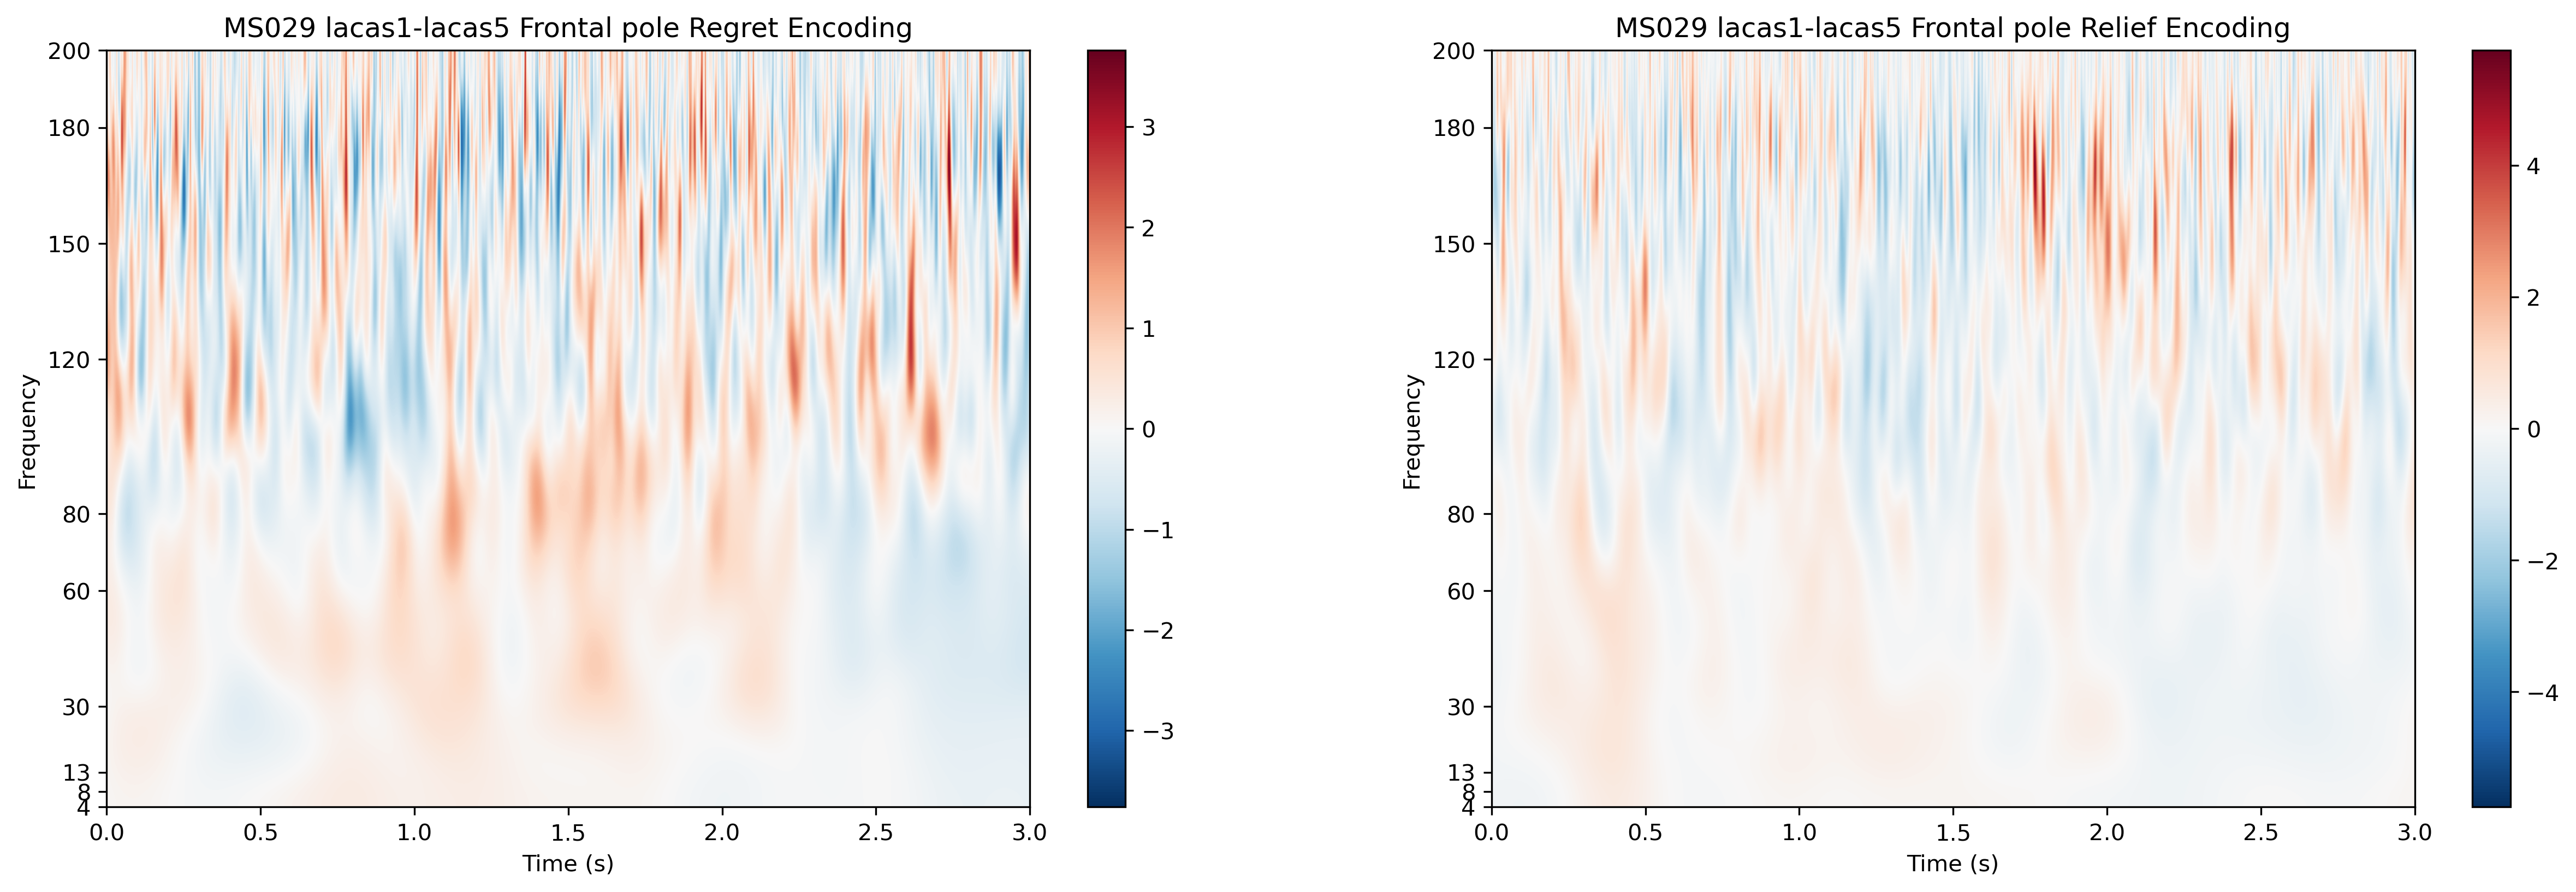

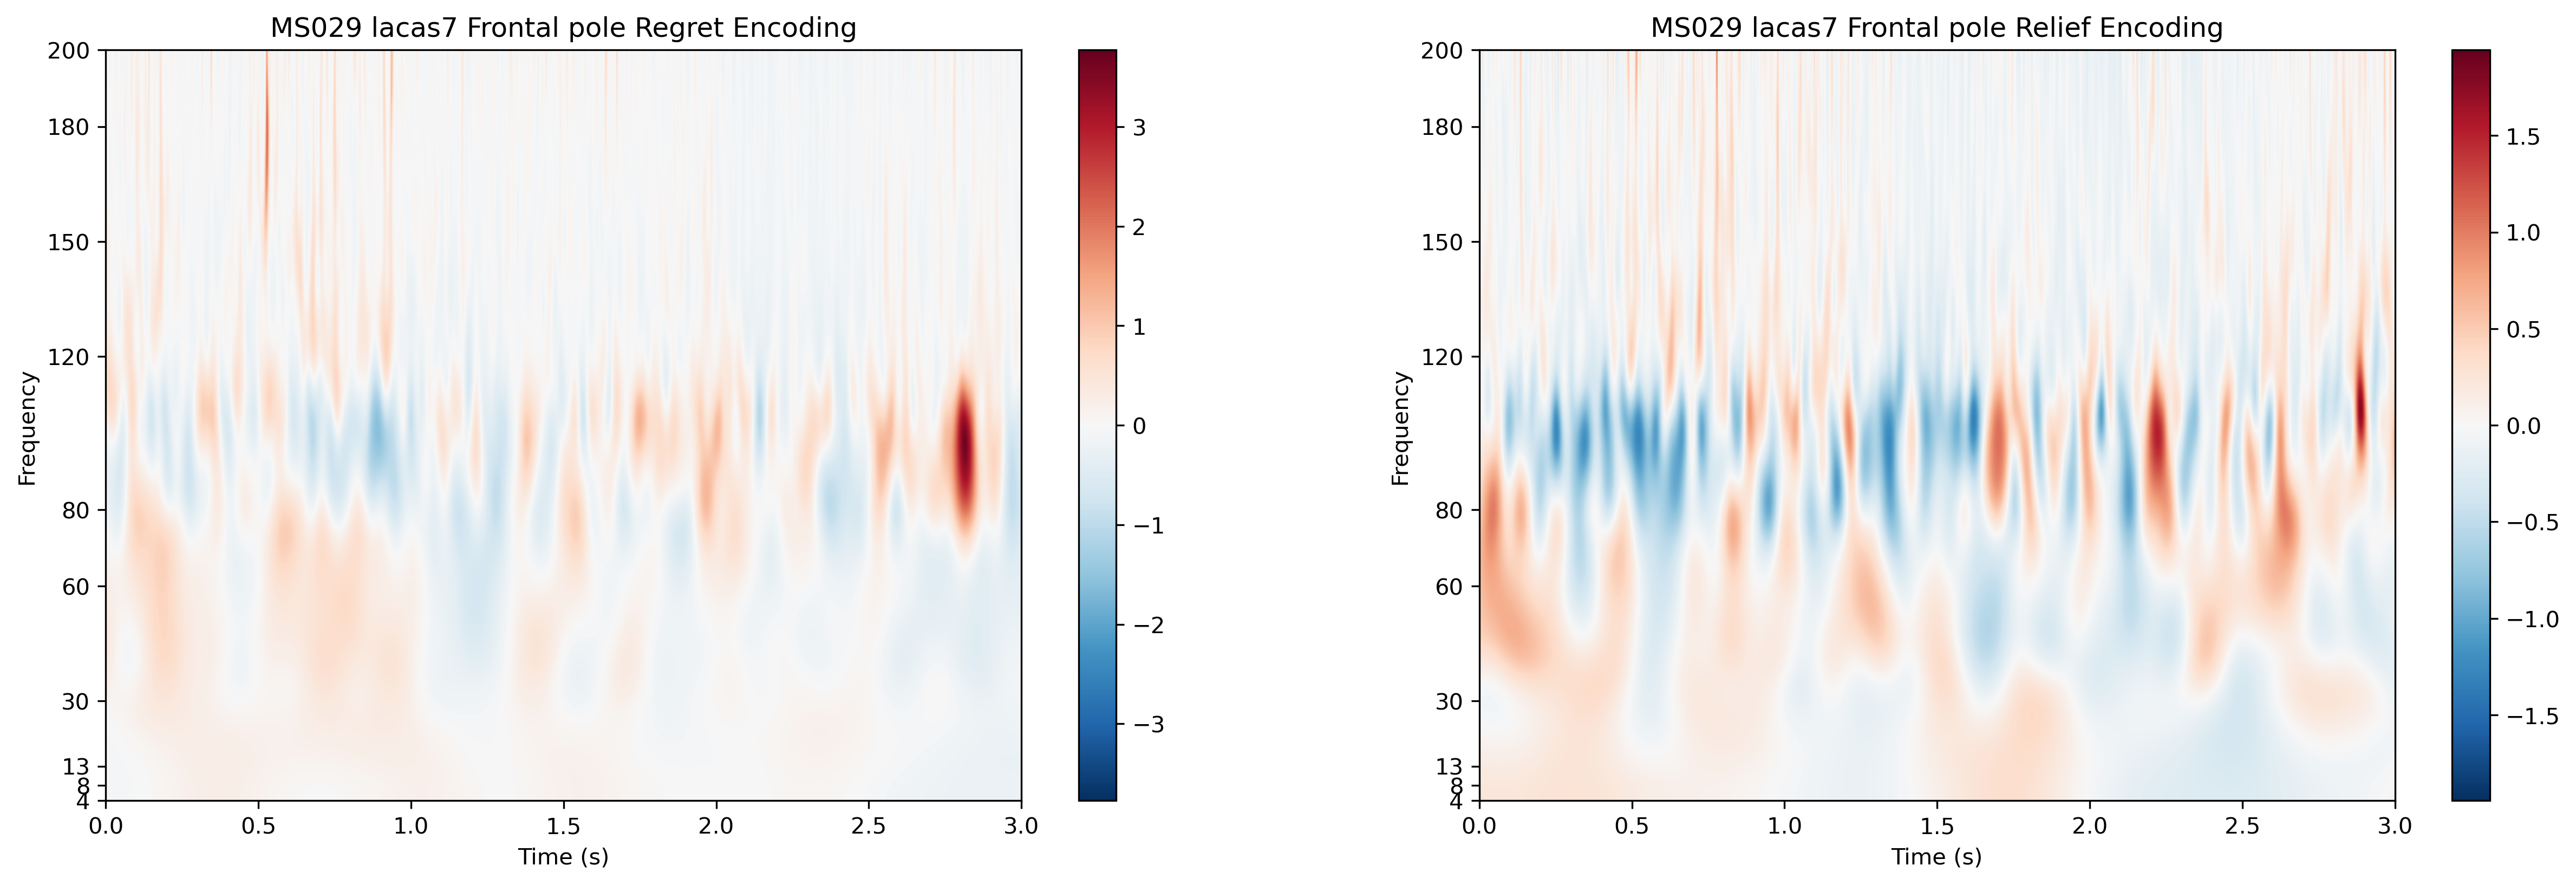

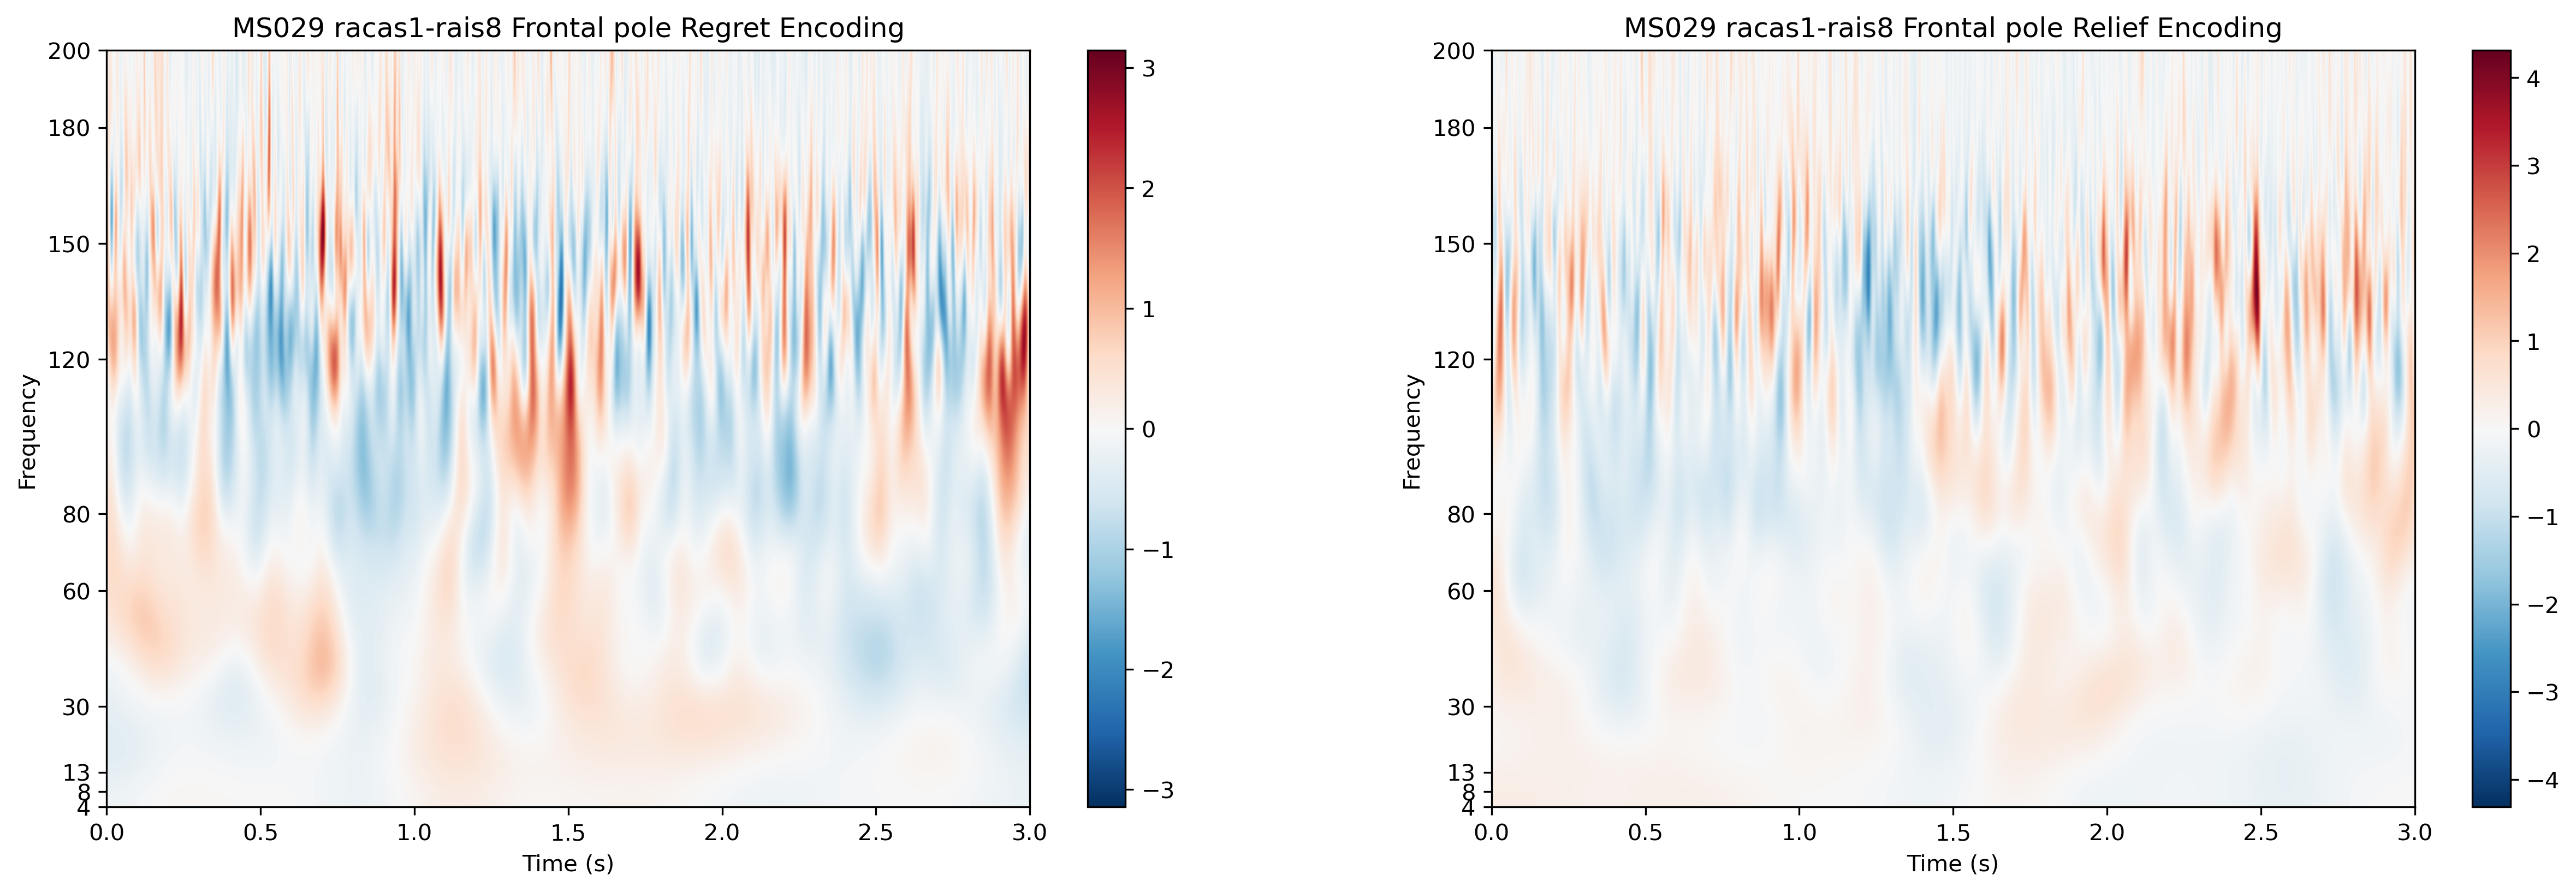

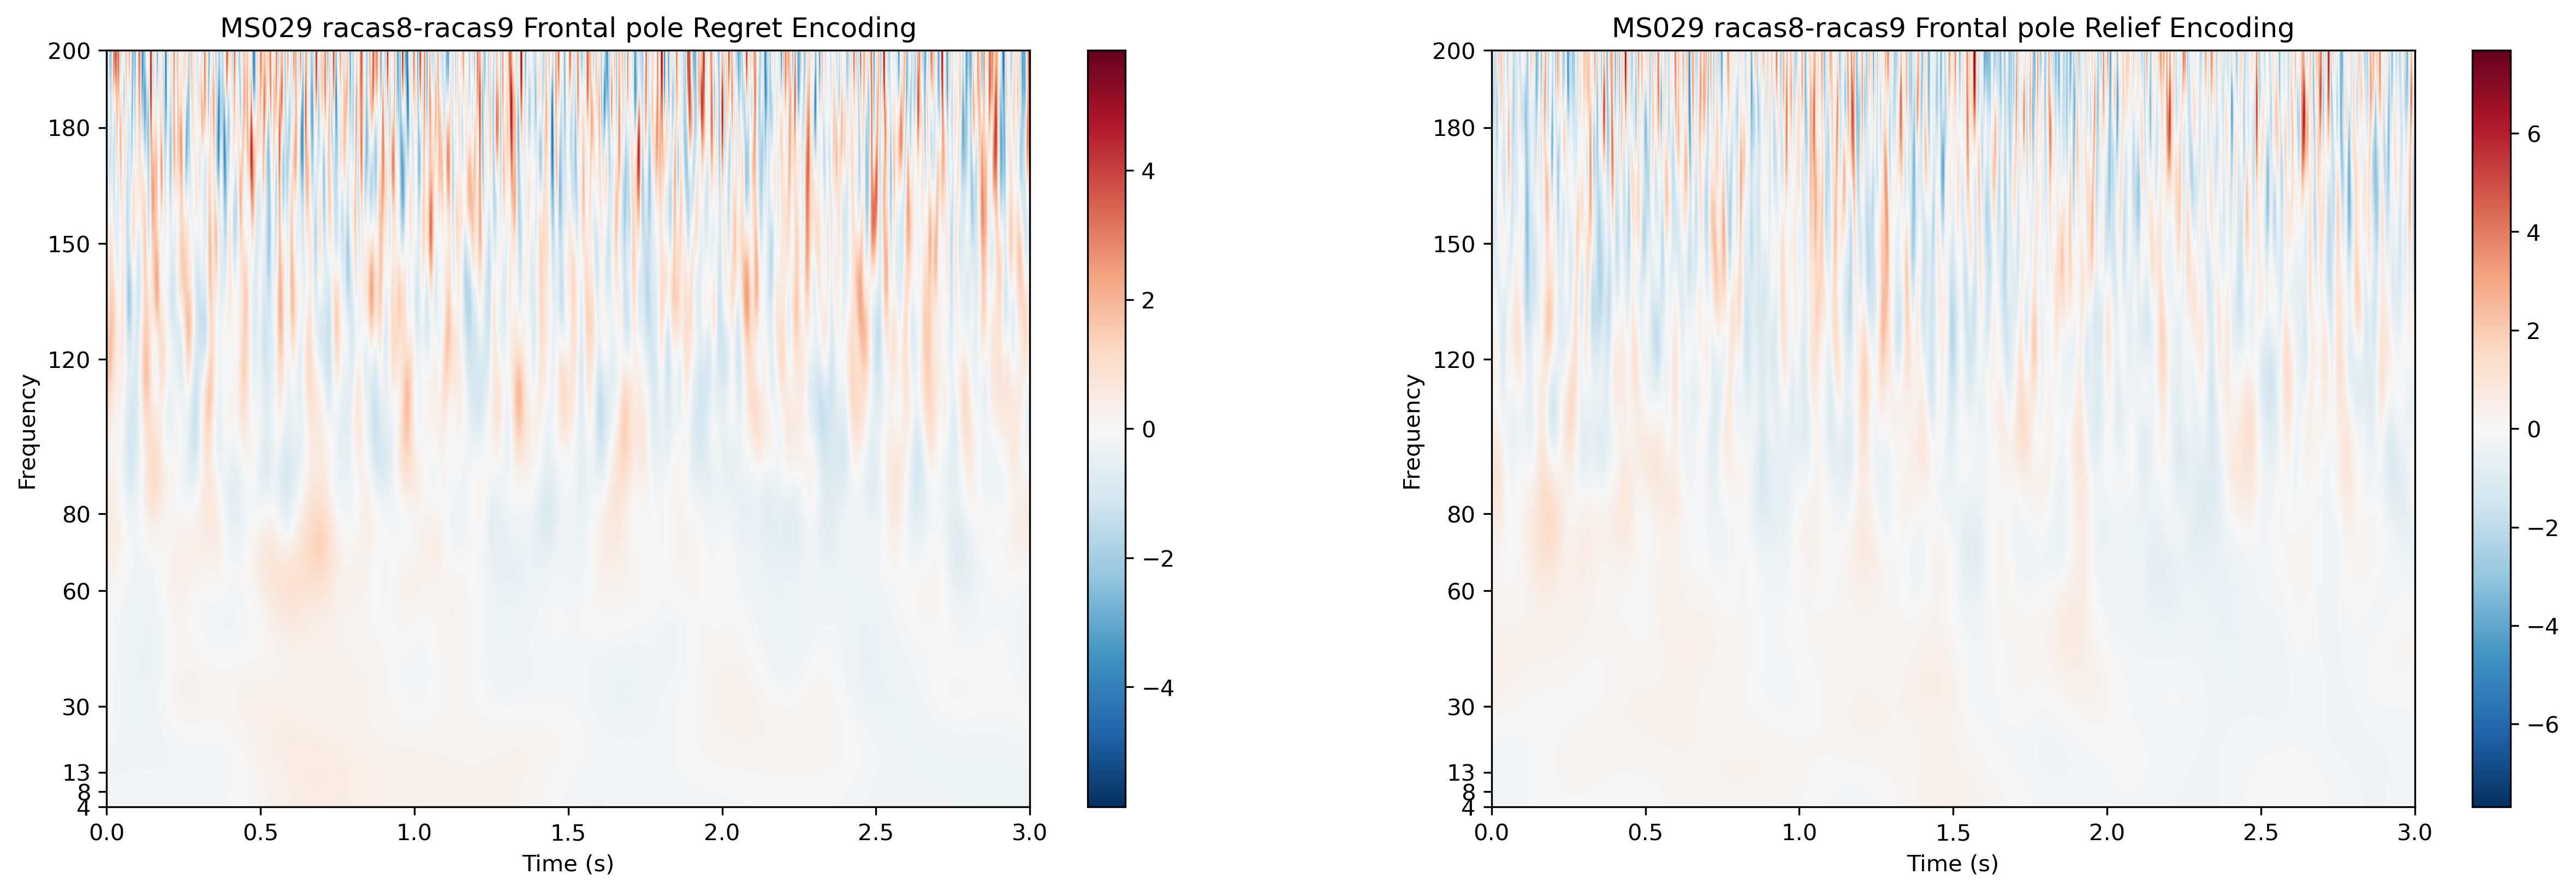

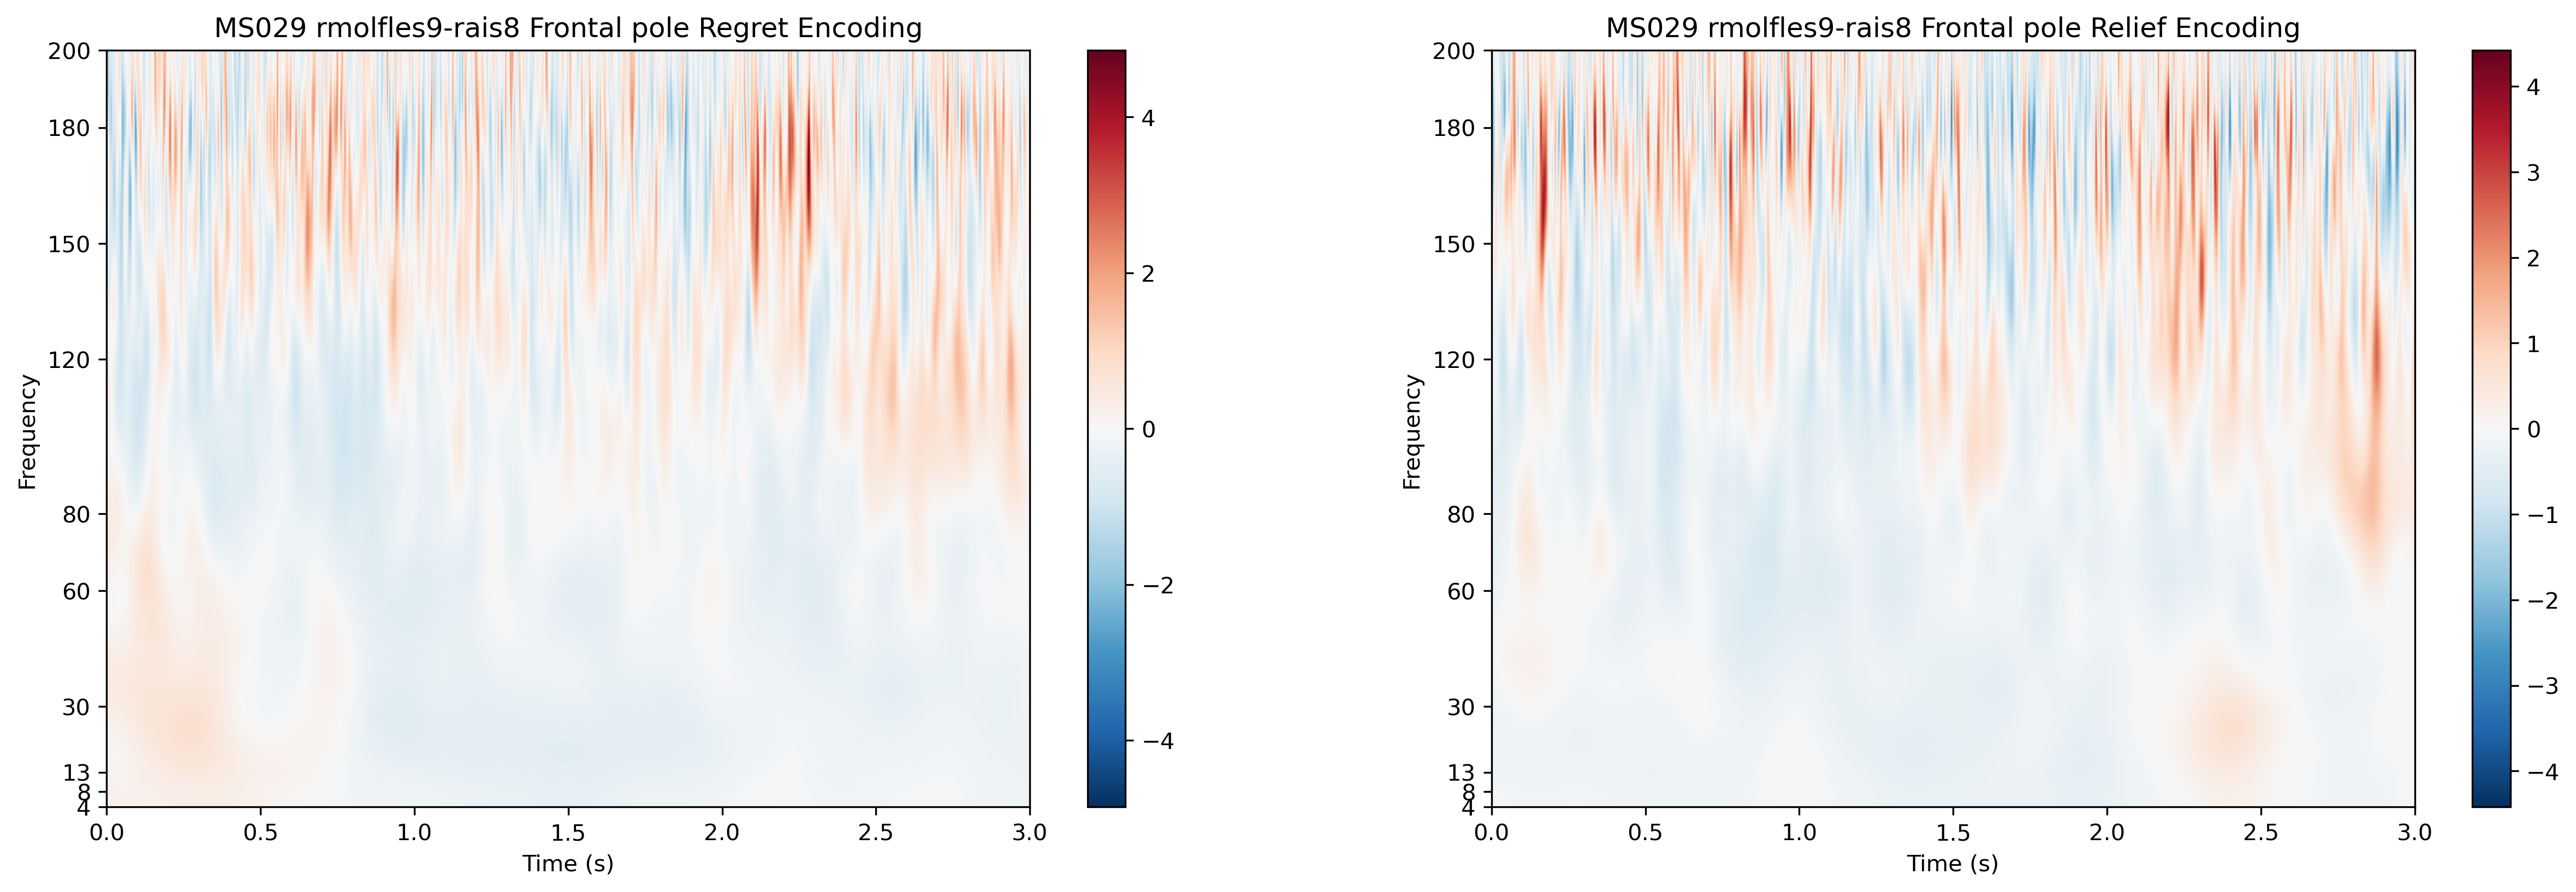

In [91]:
elecs = roi_dict[region][subj_id]
# if len(elecs) == 0:
#     continue
picks = []
for e in elecs:
    anode_list = [x.split('-')[0] for x in power_epochs[subj_id][event].ch_names]
    #names = list(zip(anode_list,power_epochs[subj_id][event].ch_names))
    electrode = [ch for an,ch in list(zip(anode_list,power_epochs[subj_id][event].ch_names)) if e == an] #preventing double digit elecs from overriding single digits
    if len(electrode)  == 0:
        continue
    picks.append(electrode[0])

for p in picks:

    fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
    for ix, cond in enumerate(conditions):
        # Set the times for 
        times = power_epochs[subj_id][event].times
        plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].copy().pick_channels([p]).data, axis=0), axis=0)
        im = ax[ix].imshow(plot_data,
                    extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
                    aspect='auto', origin='lower', cmap='RdBu_r', vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
        ax[ix].set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{subj_id} {p} {region_name} {plot_title[ix]} Encoding')
        fig.colorbar(im, ax=ax[ix])
    plt.savefig(f'{proj_dir}figs/regret_TFRs/{subj_id}_{p}_{region}_{cond_name}.png', dpi='figure', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)   


In [93]:
#frontal pole elecs by subj
ms3_fp_good_elecs = ['lacas7', 'racas1']
ms17_fp_good_elecs = ['lmolf6', 'lmolf7', 'lmolf8']
ms19_fp_good_elecs = ['lacas6', 'lacas7', 'racas6']
ms29_fp_good_elecs = ['lacas1', 'racas1', 'racas8', 'rmolfles9']

fpole_subj = ['MS003','MS017','MS019','MS029']

fpole_dict = {}
fpole_dict['MS003'] = ms3_fp_good_elecs
fpole_dict['MS017'] = ms17_fp_good_elecs
fpole_dict['MS019'] = ms19_fp_good_elecs
fpole_dict['MS029'] = ms29_fp_good_elecs

In [51]:
#orb elecs by subj
ms2_orb_good_elecs = ['lloif1', 'lloif2', 'lloif3', 'lmoif2', 'rmoif1', 'rmoif2', 'rmoif3', 'rmoif6', 'rmoif7']
ms3_orb_good_elecs = ['lmolf2', 'lmolf3', 'lmolf4', 'lmolf5', 'lmolf7', 'rmolf3']
ms16_orb_good_elecs = ['lmolf1', 'lmolf2', 'lmolf3', 'lmolf4', 'lmolf5', 'lmolf6']
ms17_orb_good_elecs = ['lmolf2', 'lmolf4']
ms19_orb_good_elecs = ['lmoif3', 'lmoif4', 'lmoif5', 'lmoif6']
ms22_orb_good_elecs = ['lmolf6']
ms26_orb_good_elecs = ['rmolf1', 'rmolf3', 'rmolf5']
ms27_orb_good_elecs = ['lmolf1', 'lmolf2', 'lmolf4', 'lmolf5', 'lmolf6', 'lmolf7', 'lmolf9', 'rmolf5', 'rmolf6']
ms29_orb_good_elecs = ['lmolf1', 'lmolf4', 'lmolf5', 'lmolf6']
ms30_orb_good_elecs = ['lmoporb4', 'lmoporb5', 'lmoporb6']

ofc_subj = ['MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']

ofc_dict = {}
ofc_dict['MS002'] = ms2_orb_good_elecs
ofc_dict['MS003'] = ms3_orb_good_elecs
ofc_dict['MS016'] = ms16_orb_good_elecs
ofc_dict['MS017'] = ms17_orb_good_elecs
ofc_dict['MS019'] = ms19_orb_good_elecs
ofc_dict['MS022'] = ms22_orb_good_elecs
ofc_dict['MS026'] = ms26_orb_good_elecs
ofc_dict['MS027'] = ms27_orb_good_elecs
ofc_dict['MS029'] = ms29_orb_good_elecs
ofc_dict['MS030'] = ms30_orb_good_elecs


In [46]:
#ins elecs by subj
da8_ins_good_elecs = ['ltp4']
ms2_ins_good_elecs = ['laims1', 'laims2', 'laims3', 'laims4', 'laims5', 'lpips1', 'lpips2', 'lpips4', 'raims1', 'raims2', 'raims3', 'raims4'] #shows HGA 
ms3_ins_good_elecs = ['laimm1', 'laimm2', 'laimm4', 'lsifo2', 'raimm1', 'raimm2', 'raimm3', 'raimm4', 'rsifo2']#shows HGA 
ms16_ins_good_elecs = ['laimm1', 'laimm2', 'laimm3', 'laimm4']
ms17_ins_good_elecs = ['lalps1', 'lalps2'] #shows HGA 
ms19_ins_good_elecs = ['rpioc2'] 
ms27_ins_good_elecs = [ 'raisp6', 'raisp7', 'raisp8'] #depressed
ms29_ins_good_elecs = ['lais1', 'lais2', 'lais3', 'lais4', 'lais5', 'rais2', 'rais3', 'rais4', 'rais5']
ms30_ins_good_elecs = ['lpipo2', 'lsipt2'] #shows HGA 

ins_subj = ['DA8','MS002','MS003','MS016','MS017','MS019','MS027','MS029','MS030']


ins_dict = {}
ins_dict['DA8'] = da8_ins_good_elecs
ins_dict['MS002'] = ms2_ins_good_elecs
ins_dict['MS003'] = ms3_ins_good_elecs
ins_dict['MS016'] = ms16_ins_good_elecs
ins_dict['MS017'] = ms17_ins_good_elecs
ins_dict['MS019'] = ms19_ins_good_elecs
ins_dict['MS027'] = ms27_ins_good_elecs
ins_dict['MS029'] = ms29_ins_good_elecs
ins_dict['MS030'] = ms30_ins_good_elecs


In [44]:
#cingulate elecs by subj
da23_cing_good_elecs = ['lac1', 'lac2', 'lac3', 'lmc3']
ms2_cing_good_elecs = ['lacas1', 'lacas2', 'lacas3', 'lacas4', 'lacas5', 'racas2', 'racas3']
ms3_cing_good_elecs = ['lacas2', 'lacas3', 'lacas4', 'racas2', 'racas3', 'racas4', 'racas5', 'rmcms1', 'rmcms3']
ms16_cing_good_elecs = ['lacas1','lmcms3', 'racas1']
ms17_cing_good_elecs = ['lacas2', 'lacas4', 'lacas5', 'lpcwr1']
ms19_cing_good_elecs = ['lacas1', 'lacas2', 'lacas3', 'lacas5', 'lmcms1', 'lmcms2', 'rmcms1', 'rmcms3']
ms22_cing_good_elecs = ['lacas1', 'lpcsma1', 'lpcsma3']
ms26_cing_good_elecs = ['lmcms3', 'racas6', 'rmcms3']
ms27_cing_good_elecs = ['lmcms2', 'racas2', 'racas6', 'rmcms1', 'rmcms2']
ms29_cing_good_elecs = ['lacas2', 'lacas3', 'lmcms1', 'lmcms2', 'lmcms3', 'racas2', 'racas5', 'racas6', 'rmcms1', 'rmcms2']
ms30_cing_good_elecs = ['lacas1', 'lacas2', 'lacas4', 'lacas5', 'lacas6', 'lmcms1', 'lmcms2', 'lmcms3']


cing_subj = ['DA023','MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']

cing_dict = {}
cing_dict['DA023'] = da23_cing_good_elecs
cing_dict['MS002'] = ms2_cing_good_elecs
cing_dict['MS003'] = ms3_cing_good_elecs
cing_dict['MS016'] = ms16_cing_good_elecs
cing_dict['MS017'] = ms17_cing_good_elecs
cing_dict['MS019'] = ms19_cing_good_elecs
cing_dict['MS022'] = ms22_cing_good_elecs
cing_dict['MS026'] = ms26_cing_good_elecs
cing_dict['MS027'] = ms27_cing_good_elecs
cing_dict['MS029'] = ms29_cing_good_elecs
cing_dict['MS030'] = ms30_cing_good_elecs


In [45]:
#amy elecs by subj

da23_amy_good_elecs = ['lam4', 'lam5']
ms2_amy_good_elecs = ['lagit1', 'lagit2', 'lagit3', 'ragit1', 'ragit2', 'ragit3']
ms3_amy_good_elecs =  ['raglt1', 'raglt2', 'raglt3']
ms16_amy_good_elecs = ['lagit1', 'lagit2', 'lagit3', 'ragit1', 'ragit2']
ms17_amy_good_elecs = ['laglt1', 'laglt2']
ms26_amy_good_elecs = ['raglt1', 'raglt2']
ms29_amy_good_elecs = ['laglt1', 'laglt2', 'laglt3']


amy_subj = ['DA023','MS002','MS003','MS016','MS017','MS026','MS029']


amy_dict = {}
amy_dict['DA023'] = da23_amy_good_elecs
amy_dict['MS002'] = ms2_amy_good_elecs
amy_dict['MS003'] = ms3_amy_good_elecs
amy_dict['MS016'] = ms16_amy_good_elecs
amy_dict['MS017'] = ms17_amy_good_elecs
amy_dict['MS026'] = ms26_amy_good_elecs
amy_dict['MS029'] = ms29_amy_good_elecs


In [ ]:
# #Single elec TFRs by ROI - multisubj

# region = 'orbital'
# #rois = ['orbital','superior frontal', 'middle frontal','frontal pole','cingulate','insular','amygdala','hippocampus']

# event = 'DecisionOnset'
# yticks = [4, 8, 13, 30, 60, 80, 120, 150, 180, 200] # band definitions for y-axis

# # task condition to contrast 
# cond_name = 'tregret'
# conditions = ["(tregret<0)",
#               "(tregret==0)"]

# plot_title = ['Regret','Relief']
# region_name = region[0].upper() + region[1:]

# for subj_id in subj_ids:
#     #find subj roi elecs 
#     elecs = roi_dict[region][subj_id]
#     if len(elecs) == 0:
#         continue
#     picks = []
#     for e in elecs:
#         electrode = [ch for ch in power_epochs[subj_id][event].ch_names if e in ch]
#         if len(electrode)  == 0:
#             continue
#         picks.append(electrode[0])


#     fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
#     for ix, cond in enumerate(conditions):
#         # Set the times for 
#         times = power_epochs[subj_id][event].times
#         plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].copy().pick_channels(picks).data, axis=0), axis=0)
#         im = ax[ix].imshow(plot_data,
#                     extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
#                     aspect='auto', origin='lower', cmap='RdBu_r', vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
#         ax[ix].set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{region_name} {plot_title[ix]} Encoding')
#         plt.title({subj_id})
#         fig.colorbar(im, ax=ax[ix])



# Make DFs for Regressions
- still need to load power epochs!

In [47]:
reg_freqs = np.array([4, 7.85210058, 10.28386103, 13.46872682, 17.6399313, 26.43944943, 34.62762872, 59.39685397, 67.97490592, 101.88356498, 152.70724797, 200])
reg_freq_name = ['theta','theta','alpha','beta','beta','beta','gamma','gamma','gamma','HGA','HGA','HGA']

In [732]:
freqs = np.logspace(*np.log10([4, 200]), num=30)

In [733]:
freqs

array([  4.        ,   4.57767719,   5.23878212,   5.99536335,
         6.86120952,   7.85210058,   8.98609544,  10.28386103,
        11.76904902,  13.46872682,  15.41387089,  17.6399313 ,
        20.1874778 ,  23.10293917,  26.43944943,  30.25781615,
        34.62762872,  39.62852655,  45.35165054,  51.90130407,
        59.39685397,  67.97490592,  77.79179411,  89.0264304 ,
       101.88356498, 116.59751791, 133.43644959, 152.70724797,
       174.76112152, 200.        ])

In [56]:
## compute within trial mean for regression data
# data is n_epochs, n_elecs, n_freq, time

orbital = []
ofc_subj = ['MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']

event = 'DecisionOnset'



for subj_id in ofc_subj:
    #subset out for picks here 
    anat = elec_dict[subj_id]
    elecs = ofc_dict[subj_id] #good ofc ch
    picks = []
    for e in elecs:
        anode_list = [x.split('-')[0] for x in power_epochs[subj_id][event].ch_names]
        electrode = [ch for an,ch in list(zip(anode_list,power_epochs[subj_id][event].ch_names)) if e == an] #preventing double digit elecs from overriding single digits
        if len(electrode)  == 0:
            continue
        picks.append(electrode[0])

    data = power_epochs[subj_id][event].copy().pick_channels(picks)
    data = data.to_data_frame()
    freqs = np.unique(data.freq)
    for ch in picks:
        for f in freqs:
            freq_data = data[data.freq==f]
            for epoch in range(150):
                #idx = (subj_num+1)*epoch*(freq+1)
                regret = power_epochs[subj_id]['DecisionOnset'].metadata.tregret[epoch]
                relief = power_epochs[subj_id]['DecisionOnset'].metadata.trelief[epoch]
                cpe = power_epochs[subj_id]['DecisionOnset'].metadata.tcpe[epoch]
                rpe = power_epochs[subj_id]['DecisionOnset'].metadata.rpe[epoch]
                cr = power_epochs[subj_id]['DecisionOnset'].metadata.cr[epoch]
                c_ev = power_epochs[subj_id]['DecisionOnset'].metadata.c_ev[epoch]
                g_ev = power_epochs[subj_id]['DecisionOnset'].metadata.g_ev[epoch]
                
                orbital.append({
                    'subj':subj_id,
                    'elec':ch,
                    'yba':list(anat['YBA_1'][anat.label == ch.split('-')[0]]),
                    'freq':f,
                    'epoch':epoch,
                    'av_pow': np.nanmean(freq_data[ch][freq_data.epoch==epoch]),
                    'regret':regret,
                    'relief':relief,
                    'cpe':cpe,
                    'rpe':rpe,
                    'cr':cr,
                    'c_ev':c_ev,
                    'g_ev':g_ev
                })


                

In [57]:
orbital_df = pd.DataFrame(orbital)


In [58]:
orbital_df

subj               elec                         yba   freq  epoch  \
0       MS002      lloif1-lmoif8  [Left frontal orbital 4 D]    4.0      0   
1       MS002      lloif1-lmoif8  [Left frontal orbital 4 D]    4.0      1   
2       MS002      lloif1-lmoif8  [Left frontal orbital 4 D]    4.0      2   
3       MS002      lloif1-lmoif8  [Left frontal orbital 4 D]    4.0      3   
4       MS002      lloif1-lmoif8  [Left frontal orbital 4 D]    4.0      4   
...       ...                ...                         ...    ...    ...   
211495  MS030  lmoporb6-lmoporb2  [Left frontal orbital 4 D]  200.0    145   
211496  MS030  lmoporb6-lmoporb2  [Left frontal orbital 4 D]  200.0    146   
211497  MS030  lmoporb6-lmoporb2  [Left frontal orbital 4 D]  200.0    147   
211498  MS030  lmoporb6-lmoporb2  [Left frontal orbital 4 D]  200.0    148   
211499  MS030  lmoporb6-lmoporb2  [Left frontal orbital 4 D]  200.0    149   

          av_pow  regret  relief   cpe    rpe   cr   c_ev   g_ev  
0      -0.660285   -0.57    0.00 -0.57  0.000  0.0  0.000 -0.265  
1      -0.824608   -0.95    0.00 -0.95 -0.475  0.0 -0.475 -0.475  
2      -0.139233    0.00    1.68  0.00  0.840  0.0  0.840  0.840  
3      -0.837469    0.00    0.80 -1.20  0.000  0.0  0.000  0.200  
4       0.448599    0.00    1.24  0.00  0.620  0.0  0.620  0.620  
...          ...     ...     ...   ...    ...  ...    ...    ...  
211495 -0.077435    0.00    1.80  0.00  0.900  0.0  0.900  0.900  
211496  0.191711   -0.84    0.00 -0.84 -0.420  0.0 -0.420 -0.420  
211497  0.029521   -1.33    0.00 -1.33 -0.665  0.0 -0.665 -0.665  
211498 -0.227315   -1.44    0.00 -1.44 -0.720  0.0 -0.720 -0.720  
211499 -0.161794    0.00    0.36  0.00  0.180  0.0 -0.180 -0.180  

[211500 rows x 13 columns]

In [59]:
save_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
orbital_df.to_csv(f'{save_path}orbital_df.csv',index=False)

In [60]:
insula = []
ins_subj = ['DA8','MS002','MS003','MS016','MS017','MS019','MS027','MS029','MS030']

event = 'DecisionOnset'

for subj_id in ins_subj:
    #subset out for picks here 
    anat = elec_dict[subj_id]
    elecs = ins_dict[subj_id] 
    picks = []
    for e in elecs:
        anode_list = [x.split('-')[0] for x in power_epochs[subj_id][event].ch_names]
        electrode = [ch for an,ch in list(zip(anode_list,power_epochs[subj_id][event].ch_names)) if e == an] #preventing double digit elecs from overriding single digits
        if len(electrode)  == 0:
            continue
        picks.append(electrode[0])

    data = power_epochs[subj_id][event].copy().pick_channels(picks)
    data = data.to_data_frame()
    freqs = np.unique(data.freq)
    for ch in picks:
        for f in freqs:
            freq_data = data[data.freq==f]
            for epoch in range(150):
                regret = power_epochs[subj_id]['DecisionOnset'].metadata.tregret[epoch]
                relief = power_epochs[subj_id]['DecisionOnset'].metadata.trelief[epoch]
                cpe = power_epochs[subj_id]['DecisionOnset'].metadata.tcpe[epoch]
                rpe = power_epochs[subj_id]['DecisionOnset'].metadata.rpe[epoch]
                cr = power_epochs[subj_id]['DecisionOnset'].metadata.cr[epoch]
                c_ev = power_epochs[subj_id]['DecisionOnset'].metadata.c_ev[epoch]
                g_ev = power_epochs[subj_id]['DecisionOnset'].metadata.g_ev[epoch]
                
                insula.append({
                    'subj':subj_id,
                    'elec':ch,
                    'yba':list(anat['YBA_1'][anat.label == ch.split('-')[0]]),
                    'freq':f,
                    'epoch':epoch,
                    'av_pow': np.nanmean(freq_data[ch][freq_data.epoch==epoch]),
                    'regret':regret,
                    'relief':relief,
                    'cpe':cpe,
                    'rpe':rpe,
                    'cr':cr,
                    'c_ev':c_ev,
                    'g_ev':g_ev
                })


In [61]:
insula_df = pd.DataFrame(insula)

In [62]:
insula_df

subj           elec                                  yba   freq  \
0         DA8      ltp4-lip2                            [Unknown]    4.0   
1         DA8      ltp4-lip2                            [Unknown]    4.0   
2         DA8      ltp4-lip2                            [Unknown]    4.0   
3         DA8      ltp4-lip2                            [Unknown]    4.0   
4         DA8      ltp4-lip2                            [Unknown]    4.0   
...       ...            ...                                  ...    ...   
193495  MS030  lsipt2-lsipt3  [Left middle short insular gyrus A]  200.0   
193496  MS030  lsipt2-lsipt3  [Left middle short insular gyrus A]  200.0   
193497  MS030  lsipt2-lsipt3  [Left middle short insular gyrus A]  200.0   
193498  MS030  lsipt2-lsipt3  [Left middle short insular gyrus A]  200.0   
193499  MS030  lsipt2-lsipt3  [Left middle short insular gyrus A]  200.0   

        epoch    av_pow  regret  relief   cpe    rpe   cr   c_ev   g_ev  
0           0  0.433432    0.00    0.80 -1.20  0.000  0.0  0.000  0.200  
1           1 -1.106508    0.00    0.66  0.00  0.330  0.0  0.030  0.030  
2           2 -0.334628   -1.50    0.00 -1.50  0.000  0.0  0.000  0.000  
3           3 -0.612912    0.00    0.63  0.00  0.315  0.0  0.315  0.315  
4           4 -0.498942    0.00    0.30 -0.20  0.000 -0.2  0.000 -0.250  
...       ...       ...     ...     ...   ...    ...  ...    ...    ...  
193495    145  0.078122    0.00    1.80  0.00  0.900  0.0  0.900  0.900  
193496    146 -0.243083   -0.84    0.00 -0.84 -0.420  0.0 -0.420 -0.420  
193497    147 -0.269168   -1.33    0.00 -1.33 -0.665  0.0 -0.665 -0.665  
193498    148  1.172612   -1.44    0.00 -1.44 -0.720  0.0 -0.720 -0.720  
193499    149 -0.684615    0.00    0.36  0.00  0.180  0.0 -0.180 -0.180  

[193500 rows x 13 columns]

In [63]:
save_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
insula_df.to_csv(f'{save_path}insula_df.csv',index=False)

In [64]:

cing_subj = ['DA023','MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']

cingulate = []

event = 'DecisionOnset'


for subj_id in cing_subj:
    #subset out for picks here 
    anat = elec_dict[subj_id]
    elecs = cing_dict[subj_id] #good ofc ch
    picks = []
    for e in elecs:
        anode_list = [x.split('-')[0] for x in power_epochs[subj_id][event].ch_names]
        electrode = [ch for an,ch in list(zip(anode_list,power_epochs[subj_id][event].ch_names)) if e == an] #preventing double digit elecs from overriding single digits
        if len(electrode)  == 0:
            continue
        picks.append(electrode[0])

    data = power_epochs[subj_id][event].copy().pick_channels(picks)
    data = data.to_data_frame()
    freqs = np.unique(data.freq)
    for ch in picks:
        for f in freqs:
            freq_data = data[data.freq==f]
            for epoch in range(150):
                regret = power_epochs[subj_id]['DecisionOnset'].metadata.tregret[epoch]
                relief = power_epochs[subj_id]['DecisionOnset'].metadata.trelief[epoch]
                cpe = power_epochs[subj_id]['DecisionOnset'].metadata.tcpe[epoch]
                rpe = power_epochs[subj_id]['DecisionOnset'].metadata.rpe[epoch]
                cr = power_epochs[subj_id]['DecisionOnset'].metadata.cr[epoch]
                c_ev = power_epochs[subj_id]['DecisionOnset'].metadata.c_ev[epoch]
                g_ev = power_epochs[subj_id]['DecisionOnset'].metadata.g_ev[epoch]
                
                cingulate.append({
                    'subj':subj_id,
                    'elec':ch,
                    'yba':list(anat['YBA_1'][anat.label == ch.split('-')[0]]),
                    'freq':f,
                    'epoch':epoch,
                    'av_pow': np.nanmean(freq_data[ch][freq_data.epoch==epoch]),
                    'regret':regret,
                    'relief':relief,
                    'cpe':cpe,
                    'rpe':rpe,
                    'cr':cr,
                    'c_ev':c_ev,
                    'g_ev':g_ev
                })


In [65]:
cingulate_df = pd.DataFrame(cingulate)

In [66]:
cingulate_df

subj           elec                       yba   freq  epoch  \
0       DA023      lac1-lmc1  [Left cingulate gyrus G]    4.0      0   
1       DA023      lac1-lmc1  [Left cingulate gyrus G]    4.0      1   
2       DA023      lac1-lmc1  [Left cingulate gyrus G]    4.0      2   
3       DA023      lac1-lmc1  [Left cingulate gyrus G]    4.0      3   
4       DA023      lac1-lmc1  [Left cingulate gyrus G]    4.0      4   
...       ...            ...                       ...    ...    ...   
287995  MS030  lmcms3-lcmmf9  [Left cingulate gyrus I]  200.0    145   
287996  MS030  lmcms3-lcmmf9  [Left cingulate gyrus I]  200.0    146   
287997  MS030  lmcms3-lcmmf9  [Left cingulate gyrus I]  200.0    147   
287998  MS030  lmcms3-lcmmf9  [Left cingulate gyrus I]  200.0    148   
287999  MS030  lmcms3-lcmmf9  [Left cingulate gyrus I]  200.0    149   

          av_pow  regret  relief   cpe    rpe   cr   c_ev   g_ev  
0      -0.967909    0.00    1.08  0.00  0.540  0.0  0.540  0.540  
1      -0.620690    0.00    1.24  0.00  0.620  0.0  0.620  0.620  
2      -0.244567   -1.12    0.00 -1.12 -0.560  0.0  0.560  0.560  
3      -0.367288   -0.56    0.00 -0.56 -0.280  0.0  0.280  0.280  
4      -0.529686    0.00    1.50 -0.78  0.000  0.0  0.000 -0.360  
...          ...     ...     ...   ...    ...  ...    ...    ...  
287995  0.301303    0.00    1.80  0.00  0.900  0.0  0.900  0.900  
287996 -0.735284   -0.84    0.00 -0.84 -0.420  0.0 -0.420 -0.420  
287997 -0.617974   -1.33    0.00 -1.33 -0.665  0.0 -0.665 -0.665  
287998  0.317625   -1.44    0.00 -1.44 -0.720  0.0 -0.720 -0.720  
287999 -0.426449    0.00    0.36  0.00  0.180  0.0 -0.180 -0.180  

[288000 rows x 13 columns]

In [67]:
save_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
cingulate_df.to_csv(f'{save_path}cingulate_df.csv',index=False)

In [68]:
amygdala = []
amy_subj = ['DA023','MS002','MS003','MS016','MS017','MS026','MS029']

event = 'DecisionOnset'


for subj_id in amy_subj:
    #subset out for picks here 
    anat = elec_dict[subj_id]
    elecs = amy_dict[subj_id] #good ofc ch
    picks = []
    for e in elecs:
        anode_list = [x.split('-')[0] for x in power_epochs[subj_id][event].ch_names]
        electrode = [ch for an,ch in list(zip(anode_list,power_epochs[subj_id][event].ch_names)) if e == an] #preventing double digit elecs from overriding single digits
        if len(electrode)  == 0:
            continue
        picks.append(electrode[0])

    data = power_epochs[subj_id][event].copy().pick_channels(picks)
    data = data.to_data_frame()
    freqs = np.unique(data.freq)
    for ch in picks:
        for f in freqs:
            freq_data = data[data.freq==f]
            for epoch in range(150):
                regret = power_epochs[subj_id]['DecisionOnset'].metadata.tregret[epoch]
                relief = power_epochs[subj_id]['DecisionOnset'].metadata.trelief[epoch]
                cpe = power_epochs[subj_id]['DecisionOnset'].metadata.tcpe[epoch]
                rpe = power_epochs[subj_id]['DecisionOnset'].metadata.rpe[epoch]
                cr = power_epochs[subj_id]['DecisionOnset'].metadata.cr[epoch]
                c_ev = power_epochs[subj_id]['DecisionOnset'].metadata.c_ev[epoch]
                g_ev = power_epochs[subj_id]['DecisionOnset'].metadata.g_ev[epoch]
                
                amygdala.append({
                    'subj':subj_id,
                    'elec':ch,
                    'yba':list(anat['YBA_1'][anat.label == ch.split('-')[0]]),
                    'freq':f,
                    'epoch':epoch,
                    'av_pow': np.nanmean(freq_data[ch][freq_data.epoch==epoch]),
                    'regret':regret,
                    'relief':relief,
                    'cpe':cpe,
                    'rpe':rpe,
                    'cr':cr,
                    'c_ev':c_ev,
                    'g_ev':g_ev
                })


In [69]:
amygdala_df = pd.DataFrame(amygdala)

In [70]:
amygdala_df

subj           elec                        yba   freq  epoch  \
0       DA023      lam4-lam6  [Left amygdala superior ]    4.0      0   
1       DA023      lam4-lam6  [Left amygdala superior ]    4.0      1   
2       DA023      lam4-lam6  [Left amygdala superior ]    4.0      2   
3       DA023      lam4-lam6  [Left amygdala superior ]    4.0      3   
4       DA023      lam4-lam6  [Left amygdala superior ]    4.0      4   
...       ...            ...                        ...    ...    ...   
103495  MS029  laglt3-laglt7   [Left amygdala inferior]  200.0    145   
103496  MS029  laglt3-laglt7   [Left amygdala inferior]  200.0    146   
103497  MS029  laglt3-laglt7   [Left amygdala inferior]  200.0    147   
103498  MS029  laglt3-laglt7   [Left amygdala inferior]  200.0    148   
103499  MS029  laglt3-laglt7   [Left amygdala inferior]  200.0    149   

          av_pow  regret  relief   cpe   rpe   cr  c_ev   g_ev  
0      -0.353974    0.00    1.08  0.00  0.54  0.0  0.54  0.540  
1       0.313502    0.00    1.24  0.00  0.62  0.0  0.62  0.620  
2      -0.139098   -1.12    0.00 -1.12 -0.56  0.0  0.56  0.560  
3      -0.364655   -0.56    0.00 -0.56 -0.28  0.0  0.28  0.280  
4       0.511300    0.00    1.50 -0.78  0.00  0.0  0.00 -0.360  
...          ...     ...     ...   ...   ...  ...   ...    ...  
103495  0.015541    0.00    0.72  0.00  0.36  0.0 -0.36 -0.360  
103496  0.029557   -2.42    0.00 -2.42 -1.21  0.0  0.11  0.110  
103497 -0.045936    0.00    0.00  0.00  0.00  0.0  0.00  0.050  
103498 -0.034278    0.00    0.30 -0.25  0.00  0.0  0.00 -0.025  
103499 -0.019217    0.00    4.50  0.00  2.25  0.0  0.75  0.750  

[103500 rows x 13 columns]

In [57]:
save_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
amygdala_df.to_csv(f'{save_path}amygdala_df.csv',index=False)

In [97]:
#frontal pole elecs by subj
ms3_fp_good_elecs = ['lacas7', 'racas1']
ms17_fp_good_elecs = ['lmolf6', 'lmolf7', 'lmolf8']
ms19_fp_good_elecs = ['lacas6', 'lacas7', 'racas6']
ms29_fp_good_elecs = ['lacas1', 'racas1', 'racas8', 'rmolfles9']

fpole_subj = ['MS003','MS017','MS019','MS029']

fpole_dict = {}
fpole_dict['MS003'] = ms3_fp_good_elecs
fpole_dict['MS017'] = ms17_fp_good_elecs
fpole_dict['MS019'] = ms19_fp_good_elecs
fpole_dict['MS029'] = ms29_fp_good_elecs

In [98]:
frontalpole = []
fpole_subj = ['MS003','MS017','MS019','MS029']

event = 'DecisionOnset'


for subj_id in fpole_subj:
    #subset out for picks here 
    anat = elec_dict[subj_id]
    elecs = fpole_dict[subj_id] #good ofc ch
    picks = []
    for e in elecs:
        anode_list = [x.split('-')[0] for x in power_epochs[subj_id][event].ch_names]
        electrode = [ch for an,ch in list(zip(anode_list,power_epochs[subj_id][event].ch_names)) if e == an] #preventing double digit elecs from overriding single digits
        if len(electrode)  == 0:
            continue
        picks.append(electrode[0])

    data = power_epochs[subj_id][event].copy().pick_channels(picks)
    data = data.to_data_frame()
    freqs = np.unique(data.freq)
    for ch in picks:
        for f in freqs:
            freq_data = data[data.freq==f]
            for epoch in range(150):
                regret = power_epochs[subj_id]['DecisionOnset'].metadata.tregret[epoch]
                relief = power_epochs[subj_id]['DecisionOnset'].metadata.trelief[epoch]
                cpe = power_epochs[subj_id]['DecisionOnset'].metadata.tcpe[epoch]
                rpe = power_epochs[subj_id]['DecisionOnset'].metadata.rpe[epoch]
                cr = power_epochs[subj_id]['DecisionOnset'].metadata.cr[epoch]
                c_ev = power_epochs[subj_id]['DecisionOnset'].metadata.c_ev[epoch]
                g_ev = power_epochs[subj_id]['DecisionOnset'].metadata.g_ev[epoch]
                
                frontalpole.append({
                    'subj':subj_id,
                    'elec':ch,
                    'yba':list(anat['YBA_1'][anat.label == ch.split('-')[0]]),
                    'freq':f,
                    'epoch':epoch,
                    'av_pow': np.nanmean(freq_data[ch][freq_data.epoch==epoch]),
                    'regret':regret,
                    'relief':relief,
                    'cpe':cpe,
                    'rpe':rpe,
                    'cr':cr,
                    'c_ev':c_ev,
                    'g_ev':g_ev
                })


In [99]:
frontalpole_df = pd.DataFrame(frontalpole)

In [100]:
frontalpole_df

subj             elec                       yba   freq  epoch  \
0      MS003    lacas7-laimm9   [Left frontal pole 4 A]    4.0      0   
1      MS003    lacas7-laimm9   [Left frontal pole 4 A]    4.0      1   
2      MS003    lacas7-laimm9   [Left frontal pole 4 A]    4.0      2   
3      MS003    lacas7-laimm9   [Left frontal pole 4 A]    4.0      3   
4      MS003    lacas7-laimm9   [Left frontal pole 4 A]    4.0      4   
...      ...              ...                       ...    ...    ...   
53995  MS029  rmolfles9-rais8  [Right frontal pole 4 F]  200.0    145   
53996  MS029  rmolfles9-rais8  [Right frontal pole 4 F]  200.0    146   
53997  MS029  rmolfles9-rais8  [Right frontal pole 4 F]  200.0    147   
53998  MS029  rmolfles9-rais8  [Right frontal pole 4 F]  200.0    148   
53999  MS029  rmolfles9-rais8  [Right frontal pole 4 F]  200.0    149   

         av_pow  regret  relief   cpe    rpe   cr   c_ev   g_ev  
0      0.043282   -1.90    0.00 -1.90 -0.950  0.0  0.950  0.950  
1      3.848607    0.00    0.39  0.00  0.195  0.0 -0.105 -0.105  
2     -0.486550    0.00    0.41 -0.60  0.000 -0.6  0.000 -0.505  
3     -0.925062    0.00    0.50 -2.00  0.000  0.5  0.000  1.250  
4     -0.891678   -1.32    0.00 -1.32 -0.660  0.0 -0.440 -0.440  
...         ...     ...     ...   ...    ...  ...    ...    ...  
53995 -0.283583    0.00    0.72  0.00  0.360  0.0 -0.360 -0.360  
53996  0.408013   -2.42    0.00 -2.42 -1.210  0.0  0.110  0.110  
53997 -0.142112    0.00    0.00  0.00  0.000  0.0  0.000  0.050  
53998 -0.382278    0.00    0.30 -0.25  0.000  0.0  0.000 -0.025  
53999 -0.347848    0.00    4.50  0.00  2.250  0.0  0.750  0.750  

[54000 rows x 13 columns]

In [101]:
save_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
frontalpole_df.to_csv(f'{save_path}frontalpole_df.csv',index=False)

# Run Regressions

### Orbital

In [19]:
load_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
orbital_df = pd.read_csv(f'{load_path}orbital_df.csv')

In [20]:
orbital_df

subj               elec                           yba   freq  epoch  \
0       MS002      lloif1-lmoif8  ['Left frontal orbital 4 D']    4.0      0   
1       MS002      lloif1-lmoif8  ['Left frontal orbital 4 D']    4.0      1   
2       MS002      lloif1-lmoif8  ['Left frontal orbital 4 D']    4.0      2   
3       MS002      lloif1-lmoif8  ['Left frontal orbital 4 D']    4.0      3   
4       MS002      lloif1-lmoif8  ['Left frontal orbital 4 D']    4.0      4   
...       ...                ...                           ...    ...    ...   
211495  MS030  lmoporb6-lmoporb2  ['Left frontal orbital 4 D']  200.0    145   
211496  MS030  lmoporb6-lmoporb2  ['Left frontal orbital 4 D']  200.0    146   
211497  MS030  lmoporb6-lmoporb2  ['Left frontal orbital 4 D']  200.0    147   
211498  MS030  lmoporb6-lmoporb2  ['Left frontal orbital 4 D']  200.0    148   
211499  MS030  lmoporb6-lmoporb2  ['Left frontal orbital 4 D']  200.0    149   

          av_pow  regret  relief   cpe    rpe   cr   c_ev   g_ev  
0      -0.660285   -0.57    0.00 -0.57  0.000  0.0  0.000 -0.265  
1      -0.824608   -0.95    0.00 -0.95 -0.475  0.0 -0.475 -0.475  
2      -0.139233    0.00    1.68  0.00  0.840  0.0  0.840  0.840  
3      -0.837469    0.00    0.80 -1.20  0.000  0.0  0.000  0.200  
4       0.448599    0.00    1.24  0.00  0.620  0.0  0.620  0.620  
...          ...     ...     ...   ...    ...  ...    ...    ...  
211495 -0.077435    0.00    1.80  0.00  0.900  0.0  0.900  0.900  
211496  0.191711   -0.84    0.00 -0.84 -0.420  0.0 -0.420 -0.420  
211497  0.029521   -1.33    0.00 -1.33 -0.665  0.0 -0.665 -0.665  
211498 -0.227315   -1.44    0.00 -1.44 -0.720  0.0 -0.720 -0.720  
211499 -0.161794    0.00    0.36  0.00  0.180  0.0 -0.180 -0.180  

[211500 rows x 13 columns]

In [21]:
#orb elecs by subj
ms2_orb_good_elecs = ['lloif1', 'lloif2', 'lloif3', 'lmoif2', 'rmoif1', 'rmoif2', 'rmoif3', 'rmoif6', 'rmoif7']
ms3_orb_good_elecs = ['lmolf2', 'lmolf3', 'lmolf4', 'lmolf5', 'lmolf7', 'rmolf3']
ms16_orb_good_elecs = ['lmolf1', 'lmolf2', 'lmolf3', 'lmolf4', 'lmolf5', 'lmolf6']
ms17_orb_good_elecs = ['lmolf2', 'lmolf4']
ms19_orb_good_elecs = ['lmoif3', 'lmoif4', 'lmoif5', 'lmoif6']
ms22_orb_good_elecs = ['lmolf6']
ms26_orb_good_elecs = ['rmolf1', 'rmolf3', 'rmolf5']
ms27_orb_good_elecs = ['lmolf1', 'lmolf2', 'lmolf4', 'lmolf5', 'lmolf6', 'lmolf7', 'lmolf9', 'rmolf5', 'rmolf6']
ms29_orb_good_elecs = ['lmolf1', 'lmolf4', 'lmolf5', 'lmolf6']
ms30_orb_good_elecs = ['lmoporb4', 'lmoporb5', 'lmoporb6']

ofc_subj = ['MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']

ofc_dict = {}
ofc_dict['MS002'] = ms2_orb_good_elecs
ofc_dict['MS003'] = ms3_orb_good_elecs
ofc_dict['MS016'] = ms16_orb_good_elecs
ofc_dict['MS017'] = ms17_orb_good_elecs
ofc_dict['MS019'] = ms19_orb_good_elecs
ofc_dict['MS022'] = ms22_orb_good_elecs
ofc_dict['MS026'] = ms26_orb_good_elecs
ofc_dict['MS027'] = ms27_orb_good_elecs
ofc_dict['MS029'] = ms29_orb_good_elecs
ofc_dict['MS030'] = ms30_orb_good_elecs


In [22]:
### loop through df 
ofc_subj = ['MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']


alpha = 0.05
rmin = 0.03
ofc_regret_regression = []

for subj_id in ofc_subj:
    subj_df = orbital_df[(orbital_df.subj==subj_id)]
    ofc_elecs = np.unique(subj_df.elec)
    for elec in ofc_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ regret', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    ofc_regret_regression.append({'subj_id':subj_id,
                                        'elec' : elec,
                                        'freq' : f,
                                        'yba':np.unique(freq_elec_subj_df.yba),
                                        'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                        'regret_coeff':result.params.regret,
                                        'p_value':result.pvalues[1],
                                        'r_squared':result.rsquared})


In [23]:
ofc_regret_regression ### need nested dict - only saving last significant elec for each subj 

[{'subj_id': 'MS002',
  'elec': 'lloif2-lmoif5',
  'freq': 26.439449428243947,
  'yba': array(["['Left frontal orbital 4 D']"], dtype=object),
  'av_pow': 0.03720096085126938,
  'regret_coeff': -0.17810679612971256,
  'p_value': 0.005011449061673492,
  'r_squared': 0.0519905123428821},
 {'subj_id': 'MS002',
  'elec': 'lloif2-lmoif5',
  'freq': 30.257816153516423,
  'yba': array(["['Left frontal orbital 4 D']"], dtype=object),
  'av_pow': 0.027334352826682545,
  'regret_coeff': -0.22216775754386298,
  'p_value': 0.0009922380995120628,
  'r_squared': 0.07086673234353225},
 {'subj_id': 'MS002',
  'elec': 'lloif2-lmoif5',
  'freq': 34.62762872066384,
  'yba': array(["['Left frontal orbital 4 D']"], dtype=object),
  'av_pow': 0.010171956333194725,
  'regret_coeff': -0.24371788399458483,
  'p_value': 0.0011410678101398683,
  'r_squared': 0.06923652521440127},
 {'subj_id': 'MS002',
  'elec': 'lloif2-lmoif5',
  'freq': 39.628526551041,
  'yba': array(["['Left frontal orbital 4 D']"], dtype=obj

In [24]:
ofc_regret_regression = pd.DataFrame(ofc_regret_regression)

In [25]:
### loop through df 
ofc_subj = ['MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']


alpha = 0.05
rmin = 0.03
ofc_relief_regression = []

for subj_id in ofc_subj:
    subj_df = orbital_df[(orbital_df.subj==subj_id)]
    ofc_elecs = np.unique(subj_df.elec)
    for elec in ofc_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ relief', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    ofc_relief_regression.append({'subj_id':subj_id,
                                        'elec' : elec,
                                        'freq' : f,
                                        'yba':np.unique(freq_elec_subj_df.yba),
                                        'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                        'relief_coeff':result.params.relief,
                                        'p_value':result.pvalues[1],
                                        'r_squared':result.rsquared})


In [26]:
ofc_relief_regression

[{'subj_id': 'MS002',
  'elec': 'lloif2-lmoif5',
  'freq': 15.413870891516057,
  'yba': array(["['Left frontal orbital 4 D']"], dtype=object),
  'av_pow': -0.0006207383114527095,
  'relief_coeff': 0.139470199311582,
  'p_value': 0.01412178079311098,
  'r_squared': 0.04000980904014906},
 {'subj_id': 'MS002',
  'elec': 'lloif2-lmoif5',
  'freq': 17.639931304746067,
  'yba': array(["['Left frontal orbital 4 D']"], dtype=object),
  'av_pow': 0.02716038222620402,
  'relief_coeff': 0.17007193962389278,
  'p_value': 0.00649439461480708,
  'r_squared': 0.048980724564878564},
 {'subj_id': 'MS002',
  'elec': 'lloif2-lmoif5',
  'freq': 20.18747780010469,
  'yba': array(["['Left frontal orbital 4 D']"], dtype=object),
  'av_pow': 0.0385837674555977,
  'relief_coeff': 0.15058289478610298,
  'p_value': 0.015528921175309553,
  'r_squared': 0.03891965377842721},
 {'subj_id': 'MS002',
  'elec': 'lloif3-lmoif10',
  'freq': 6.861209520782086,
  'yba': array(["['Left frontal orbital 4 D']"], dtype=object)

In [27]:
ofc_relief_regression = pd.DataFrame(ofc_relief_regression)

## Cingulate

In [28]:
load_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
cingulate_df = pd.read_csv(f'{load_path}cingulate_df.csv')

In [29]:
#cingulate elecs by subj
da23_cing_good_elecs = ['lac1', 'lac2', 'lac3', 'lmc3']
ms2_cing_good_elecs = ['lacas1', 'lacas2', 'lacas3', 'lacas4', 'lacas5', 'racas2', 'racas3']
ms3_cing_good_elecs = ['lacas2', 'lacas3', 'lacas4', 'racas2', 'racas3', 'racas4', 'racas5', 'rmcms1', 'rmcms3']
ms16_cing_good_elecs = ['lacas1','lmcms3', 'racas1']
ms17_cing_good_elecs = ['lacas2', 'lacas4', 'lacas5', 'lpcwr1']
ms19_cing_good_elecs = ['lacas1', 'lacas2', 'lacas3', 'lacas5', 'lmcms1', 'lmcms2', 'rmcms1', 'rmcms3']
ms22_cing_good_elecs = ['lacas1', 'lpcsma1', 'lpcsma3']
ms26_cing_good_elecs = ['lmcms3', 'racas6', 'rmcms3']
ms27_cing_good_elecs = ['lmcms2', 'racas2', 'racas6', 'rmcms1', 'rmcms2']
ms29_cing_good_elecs = ['lacas2', 'lacas3', 'lmcms1', 'lmcms2', 'lmcms3', 'racas2', 'racas5', 'racas6', 'rmcms1', 'rmcms2']
ms30_cing_good_elecs = ['lacas1', 'lacas2', 'lacas4', 'lacas5', 'lacas6', 'lmcms1', 'lmcms2', 'lmcms3']


cing_subj = ['DA023','MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']

cing_dict = {}
cing_dict['DA023'] = da23_cing_good_elecs
cing_dict['MS002'] = ms2_cing_good_elecs
cing_dict['MS003'] = ms3_cing_good_elecs
cing_dict['MS016'] = ms16_cing_good_elecs
cing_dict['MS017'] = ms17_cing_good_elecs
cing_dict['MS019'] = ms19_cing_good_elecs
cing_dict['MS022'] = ms22_cing_good_elecs
cing_dict['MS026'] = ms26_cing_good_elecs
cing_dict['MS027'] = ms27_cing_good_elecs
cing_dict['MS029'] = ms29_cing_good_elecs
cing_dict['MS030'] = ms30_cing_good_elecs

In [30]:
### loop through df 
cing_subj = ['DA023','MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']


alpha = 0.05
rmin = 0.03
cing_regret_regression = []

for subj_id in cing_subj:
    subj_df = cingulate_df[(cingulate_df.subj==subj_id)]
    cing_elecs = np.unique(subj_df.elec)
    for elec in cing_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ regret', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    cing_regret_regression.append({'subj_id':subj_id,
                                            'elec' : elec,
                                            'freq' : f,
                                            'yba':np.unique(freq_elec_subj_df.yba),
                                            'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                            'regret_coeff':result.params.regret,
                                            'p_value':result.pvalues[1],
                                            'r_squared':result.rsquared})



In [31]:
cing_regret_regression

[{'subj_id': 'DA023',
  'elec': 'lac2-lmc1',
  'freq': 4.0,
  'yba': array(["['Left cingulate gyrus H']"], dtype=object),
  'av_pow': -0.002220602558884046,
  'regret_coeff': -0.33310012732154215,
  'p_value': 0.027909036008592864,
  'r_squared': 0.03223907884902755},
 {'subj_id': 'DA023',
  'elec': 'lac2-lmc1',
  'freq': 4.577677191899995,
  'yba': array(["['Left cingulate gyrus H']"], dtype=object),
  'av_pow': -0.0020379409761534834,
  'regret_coeff': -0.41160472743631904,
  'p_value': 0.004736581405065303,
  'r_squared': 0.0526462419900553},
 {'subj_id': 'DA023',
  'elec': 'lac2-lmc1',
  'freq': 5.238782118310356,
  'yba': array(["['Left cingulate gyrus H']"], dtype=object),
  'av_pow': 0.006472966435597505,
  'regret_coeff': -0.4645352974906061,
  'p_value': 0.0004916443301022063,
  'r_squared': 0.07905115311839894},
 {'subj_id': 'DA023',
  'elec': 'lac2-lmc1',
  'freq': 5.995363354080713,
  'yba': array(["['Left cingulate gyrus H']"], dtype=object),
  'av_pow': 0.0199488858264094

In [32]:
cing_regret_regression = pd.DataFrame(cing_regret_regression)

In [33]:
### relief
cing_subj = ['DA023','MS002','MS003','MS016','MS017','MS019','MS022','MS026','MS027','MS029','MS030']


alpha = 0.05
rmin = 0.03
cing_relief_regression = []

for subj_id in cing_subj:
    subj_df = cingulate_df[(cingulate_df.subj==subj_id)]
    cing_elecs = np.unique(subj_df.elec)
    for elec in cing_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ relief', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    cing_relief_regression.append({'subj_id':subj_id,
                                            'elec' : elec,
                                            'freq' : f,
                                            'yba':np.unique(freq_elec_subj_df.yba),
                                            'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                            'relief_coeff':result.params.relief,
                                            'p_value':result.pvalues[1],
                                            'r_squared':result.rsquared})


In [34]:
cing_relief_regression

[{'subj_id': 'DA023',
  'elec': 'lac1-lmc1',
  'freq': 5.995363354080713,
  'yba': array(["['Left cingulate gyrus G']"], dtype=object),
  'av_pow': 0.017946345449672167,
  'relief_coeff': -0.2253560776926674,
  'p_value': 0.03389062292208412,
  'r_squared': 0.030048766460221144},
 {'subj_id': 'DA023',
  'elec': 'lac2-lmc1',
  'freq': 5.238782118310356,
  'yba': array(["['Left cingulate gyrus H']"], dtype=object),
  'av_pow': 0.006472966435597505,
  'relief_coeff': -0.29700750150064925,
  'p_value': 0.008749438400912432,
  'r_squared': 0.04552856547249817},
 {'subj_id': 'DA023',
  'elec': 'lac2-lmc1',
  'freq': 5.995363354080713,
  'yba': array(["['Left cingulate gyrus H']"], dtype=object),
  'av_pow': 0.01994888582640945,
  'relief_coeff': -0.3339157444644122,
  'p_value': 0.002157206942975869,
  'r_squared': 0.06180734712349867},
 {'subj_id': 'DA023',
  'elec': 'lac2-lmc1',
  'freq': 6.861209520782086,
  'yba': array(["['Left cingulate gyrus H']"], dtype=object),
  'av_pow': 0.0113352

In [35]:
cing_relief_regression = pd.DataFrame(cing_relief_regression)

## Insula

In [36]:
load_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
insula_df = pd.read_csv(f'{load_path}insula_df.csv')

In [37]:
#ins elecs by subj
da8_ins_good_elecs = ['ltp4']
ms2_ins_good_elecs = ['laims1', 'laims2', 'laims3', 'laims4', 'laims5', 'lpips1', 'lpips2', 'lpips4', 'raims1', 'raims2', 'raims3', 'raims4'] #shows HGA 
ms3_ins_good_elecs = ['laimm1', 'laimm2', 'laimm4', 'lsifo2', 'raimm1', 'raimm2', 'raimm3', 'raimm4', 'rsifo2']#shows HGA 
ms16_ins_good_elecs = ['laimm1', 'laimm2', 'laimm3', 'laimm4']
ms17_ins_good_elecs = ['lalps1', 'lalps2'] #shows HGA 
ms19_ins_good_elecs = ['rpioc2'] 
ms27_ins_good_elecs = [ 'raisp6', 'raisp7', 'raisp8'] #depressed
ms29_ins_good_elecs = ['lais1', 'lais2', 'lais3', 'lais4', 'lais5', 'rais2', 'rais3', 'rais4', 'rais5']
ms30_ins_good_elecs = ['lpipo2', 'lsipt2'] #shows HGA 

ins_subj = ['DA8','MS002','MS003','MS016','MS017','MS019','MS027','MS029','MS030']


ins_dict = {}
ins_dict['DA8'] = da8_ins_good_elecs
ins_dict['MS002'] = ms2_ins_good_elecs
ins_dict['MS003'] = ms3_ins_good_elecs
ins_dict['MS016'] = ms16_ins_good_elecs
ins_dict['MS017'] = ms17_ins_good_elecs
ins_dict['MS019'] = ms19_ins_good_elecs
ins_dict['MS027'] = ms27_ins_good_elecs
ins_dict['MS029'] = ms29_ins_good_elecs
ins_dict['MS030'] = ms30_ins_good_elecs

In [38]:
### loop through df 
ins_subj = ['DA8','MS002','MS003','MS016','MS017','MS019','MS027','MS029','MS030']


alpha = 0.05
rmin = 0.03
ins_regret_regression = []

for subj_id in ins_subj:
    subj_df = insula_df[(insula_df.subj==subj_id)]
    ins_elecs = np.unique(subj_df.elec)
    for elec in ins_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ regret', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    ins_regret_regression.append({'subj_id':subj_id,
                                            'elec' : elec,
                                            'freq' : f,
                                            'yba':np.unique(freq_elec_subj_df.yba),
                                            'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                            'regret_coeff':result.params.regret,
                                            'p_value':result.pvalues[1],
                                            'r_squared':result.rsquared})


In [39]:
ins_regret_regression

[{'subj_id': 'DA8',
  'elec': 'ltp4-lip2',
  'freq': 4.0,
  'yba': array(["['Unknown']"], dtype=object),
  'av_pow': 0.029125784918194435,
  'regret_coeff': 0.20965551119736064,
  'p_value': 0.025439752150326657,
  'r_squared': 0.03373815882253428},
 {'subj_id': 'DA8',
  'elec': 'ltp4-lip2',
  'freq': 4.577677191899995,
  'yba': array(["['Unknown']"], dtype=object),
  'av_pow': 0.03404125587877627,
  'regret_coeff': 0.17671923839385997,
  'p_value': 0.032528288378715416,
  'r_squared': 0.030923247496017714},
 {'subj_id': 'MS002',
  'elec': 'laims3-lmoif8',
  'freq': 77.79179410904005,
  'yba': array(["['Unknown']"], dtype=object),
  'av_pow': 0.10889939331051643,
  'regret_coeff': -0.14641448382250558,
  'p_value': 0.026085069296428606,
  'r_squared': 0.033004393245061325},
 {'subj_id': 'MS002',
  'elec': 'laims3-lmoif8',
  'freq': 89.02643040248329,
  'yba': array(["['Unknown']"], dtype=object),
  'av_pow': 0.12902070937897336,
  'regret_coeff': -0.18476178948207822,
  'p_value': 0.01

In [40]:
ins_regret_regression = pd.DataFrame(ins_regret_regression)

In [41]:
### loop through df 
ins_subj = ['DA8','MS002','MS003','MS016','MS017','MS019','MS027','MS029','MS030']


alpha = 0.05
rmin = 0.03
ins_relief_regression = []

for subj_id in ins_subj:
    subj_df = insula_df[(insula_df.subj==subj_id)]
    ins_elecs = np.unique(subj_df.elec)
    for elec in ins_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ relief', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    ins_relief_regression.append({'subj_id':subj_id,
                                            'elec' : elec,
                                            'freq' : f,
                                            'yba':np.unique(freq_elec_subj_df.yba),
                                            'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                            'relief_coeff':result.params.relief,
                                            'p_value':result.pvalues[1],
                                            'r_squared':result.rsquared})


In [42]:
ins_relief_regression

[{'subj_id': 'DA8',
  'elec': 'ltp4-lip2',
  'freq': 4.0,
  'yba': array(["['Unknown']"], dtype=object),
  'av_pow': 0.029125784918194435,
  'relief_coeff': 0.19470458620309988,
  'p_value': 0.02908469139919081,
  'r_squared': 0.032202203556159104},
 {'subj_id': 'DA8',
  'elec': 'ltp4-lip2',
  'freq': 34.62762872066384,
  'yba': array(["['Unknown']"], dtype=object),
  'av_pow': 0.020517678546648807,
  'relief_coeff': -0.09081570058415038,
  'p_value': 0.025768796602802832,
  'r_squared': 0.03359049418312321},
 {'subj_id': 'MS002',
  'elec': 'laims1-lmoif8',
  'freq': 11.76904902201768,
  'yba': array(["['Left middle short insular gyrus C']"], dtype=object),
  'av_pow': -0.0343653054273836,
  'relief_coeff': 0.15952040341104534,
  'p_value': 0.025468993969343483,
  'r_squared': 0.033275377786658455},
 {'subj_id': 'MS002',
  'elec': 'laims1-lmoif8',
  'freq': 13.468726819610822,
  'yba': array(["['Left middle short insular gyrus C']"], dtype=object),
  'av_pow': -0.0023164193889140703,
 

In [43]:
ins_relief_regression = pd.DataFrame(ins_relief_regression)

## Amygdala


In [44]:
load_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
amygdala_df = pd.read_csv(f'{load_path}amygdala_df.csv')

In [45]:
#amy elecs by subj

da23_amy_good_elecs = ['lam4', 'lam5']
ms2_amy_good_elecs = ['lagit1', 'lagit2', 'lagit3', 'ragit1', 'ragit2', 'ragit3']
ms3_amy_good_elecs =  ['raglt1', 'raglt2', 'raglt3']
ms16_amy_good_elecs = ['lagit1', 'lagit2', 'lagit3', 'ragit1', 'ragit2']
ms17_amy_good_elecs = ['laglt1', 'laglt2']
ms26_amy_good_elecs = ['raglt1', 'raglt2']
ms29_amy_good_elecs = ['laglt1', 'laglt2', 'laglt3']


amy_subj = ['DA023','MS002','MS003','MS016','MS017','MS026','MS029']


amy_dict = {}
amy_dict['DA023'] = da23_amy_good_elecs
amy_dict['MS002'] = ms2_amy_good_elecs
amy_dict['MS003'] = ms3_amy_good_elecs
amy_dict['MS016'] = ms16_amy_good_elecs
amy_dict['MS017'] = ms17_amy_good_elecs
amy_dict['MS026'] = ms26_amy_good_elecs
amy_dict['MS029'] = ms29_amy_good_elecs

In [46]:
### loop through df 
amy_subj = ['DA023','MS002','MS003','MS016','MS017','MS026','MS029']


alpha = 0.05
rmin = 0.03
amy_regret_regression = []

for subj_id in amy_subj:
    subj_df = amygdala_df[(amygdala_df.subj==subj_id)]
    amy_elecs = np.unique(subj_df.elec)
    for elec in amy_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ regret', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    amy_regret_regression.append({'subj_id':subj_id,
                                            'elec' : elec,
                                            'freq' : f,
                                            'yba':np.unique(freq_elec_subj_df.yba),
                                            'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                            'regret_coeff':result.params.regret,
                                            'p_value':result.pvalues[1],
                                            'r_squared':result.rsquared})



In [47]:
amy_regret_regression

[{'subj_id': 'MS002',
  'elec': 'lagit1-lagit6',
  'freq': 152.70724796969046,
  'yba': array(["['Left amygdala inferior']"], dtype=object),
  'av_pow': -0.046919804404517956,
  'regret_coeff': 0.14628915800482475,
  'p_value': 0.01963983162693768,
  'r_squared': 0.03623265570804701},
 {'subj_id': 'MS002',
  'elec': 'lagit1-lagit6',
  'freq': 174.76112151716725,
  'yba': array(["['Left amygdala inferior']"], dtype=object),
  'av_pow': -0.04888611548472967,
  'regret_coeff': 0.1603554447550991,
  'p_value': 0.02368353619763554,
  'r_squared': 0.0341004721247441},
 {'subj_id': 'MS002',
  'elec': 'lagit2-lagit6',
  'freq': 34.62762872066384,
  'yba': array(["['Left amygdala inferior']"], dtype=object),
  'av_pow': -0.008939711375113396,
  'regret_coeff': -0.2559264399199773,
  'p_value': 0.02212954308852794,
  'r_squared': 0.03487228271627296},
 {'subj_id': 'MS002',
  'elec': 'lagit2-lagit6',
  'freq': 39.628526551041,
  'yba': array(["['Left amygdala inferior']"], dtype=object),
  'av_po

In [48]:
amy_regret_regression = pd.DataFrame(amy_regret_regression)

In [49]:
### loop through df 
amy_subj = ['DA023','MS002','MS003','MS016','MS017','MS026','MS029']


alpha = 0.05
rmin = 0.03
amy_relief_regression = []

for subj_id in amy_subj:
    subj_df = amygdala_df[(amygdala_df.subj==subj_id)]
    amy_elecs = np.unique(subj_df.elec)
    subj_dict = {}
    for elec in amy_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        elec_dict = {}
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ relief', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    amy_relief_regression.append({'subj_id':subj_id,
                                            'elec' : elec,
                                            'freq' : f,
                                            'yba':np.unique(freq_elec_subj_df.yba),
                                            'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                            'relief_coeff':result.params.relief,
                                            'p_value':result.pvalues[1],
                                            'r_squared':result.rsquared})


In [50]:
amy_relief_regression

[{'subj_id': 'DA023',
  'elec': 'lam4-lam6',
  'freq': 30.257816153516423,
  'yba': array(["['Left amygdala superior ']"], dtype=object),
  'av_pow': -0.012704759150913863,
  'relief_coeff': -0.17506180018908432,
  'p_value': 0.014150539355783089,
  'r_squared': 0.03998644124898365},
 {'subj_id': 'DA023',
  'elec': 'lam4-lam6',
  'freq': 34.62762872066384,
  'yba': array(["['Left amygdala superior ']"], dtype=object),
  'av_pow': -0.0021684247293033494,
  'relief_coeff': -0.21642143316547102,
  'p_value': 0.002666288096275042,
  'r_squared': 0.05933696423717738},
 {'subj_id': 'DA023',
  'elec': 'lam4-lam6',
  'freq': 39.628526551041,
  'yba': array(["['Left amygdala superior ']"], dtype=object),
  'av_pow': 0.01801173734905593,
  'relief_coeff': -0.22448002737709155,
  'p_value': 0.003275043200690795,
  'r_squared': 0.05694063179029207},
 {'subj_id': 'DA023',
  'elec': 'lam4-lam6',
  'freq': 45.351650535325945,
  'yba': array(["['Left amygdala superior ']"], dtype=object),
  'av_pow': 

In [51]:
amy_relief_regression = pd.DataFrame(amy_relief_regression)

## Frontal Pole

In [52]:
load_path = f'{swb_dir}presentations/cpc_2023_poster/data/'
frontalpole_df = pd.read_csv(f'{load_path}frontalpole_df.csv')

In [53]:
#frontal pole elecs by subj
ms3_fp_good_elecs = ['lacas7', 'racas1']
ms17_fp_good_elecs = ['lmolf6', 'lmolf7', 'lmolf8']
ms19_fp_good_elecs = ['lacas6', 'lacas7', 'racas6']
ms29_fp_good_elecs = ['lacas1', 'racas1', 'racas8', 'rmolfles9']

fpole_subj = ['MS003','MS017','MS019','MS029']

fpole_dict = {}
fpole_dict['MS003'] = ms3_fp_good_elecs
fpole_dict['MS017'] = ms17_fp_good_elecs
fpole_dict['MS019'] = ms19_fp_good_elecs
fpole_dict['MS029'] = ms29_fp_good_elecs

In [54]:
### loop through df 
fpole_subj = ['MS003','MS017','MS019','MS029']


alpha = 0.05
rmin = 0.03
fpole_regret_regression = []

for subj_id in fpole_subj:
    subj_df = frontalpole_df[(frontalpole_df.subj==subj_id)]
    fp_elecs = np.unique(subj_df.elec)
    for elec in fp_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ regret', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    fpole_regret_regression.append({'subj_id':subj_id,
                                            'elec' : elec,
                                            'freq' : f,
                                            'yba':np.unique(freq_elec_subj_df.yba),
                                            'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                            'regret_coeff':result.params.regret,
                                            'p_value':result.pvalues[1],
                                            'r_squared':result.rsquared})


In [50]:
fpole_regret_regression

[{'subj_id': 'MS017',
  'elec': 'lmolf7-lalps4',
  'freq': 39.628526551041,
  'yba': array(["['Left frontal pole 3 F']"], dtype=object),
  'av_pow': 0.18387836466073398,
  'regret_coeff': 0.27222513473327636,
  'p_value': 0.009184091455804975,
  'r_squared': 0.044968046699248365},
 {'subj_id': 'MS017',
  'elec': 'lmolf7-lalps4',
  'freq': 45.351650535325945,
  'yba': array(["['Left frontal pole 3 F']"], dtype=object),
  'av_pow': 0.1777358132095696,
  'regret_coeff': 0.36678268471010333,
  'p_value': 0.0008142047603741937,
  'r_squared': 0.07317288623384},
 {'subj_id': 'MS017',
  'elec': 'lmolf7-lalps4',
  'freq': 51.901304067645206,
  'yba': array(["['Left frontal pole 3 F']"], dtype=object),
  'av_pow': 0.1732967097815624,
  'regret_coeff': 0.42595959729570343,
  'p_value': 0.0002239666276549665,
  'r_squared': 0.0881920829117755},
 {'subj_id': 'MS017',
  'elec': 'lmolf7-lalps4',
  'freq': 59.39685396508148,
  'yba': array(["['Left frontal pole 3 F']"], dtype=object),
  'av_pow': 0.1

In [51]:
fpole_regret_regression = pd.DataFrame(fpole_regret_regression)

In [52]:
### loop through df 
fpole_subj = ['MS003','MS017','MS019','MS029']


alpha = 0.05
rmin = 0.03
fpole_relief_regression = []

for subj_id in fpole_subj:
    subj_df = frontalpole_df[(frontalpole_df.subj==subj_id)]
    fp_elecs = np.unique(subj_df.elec)
    subj_dict = {}
    for elec in fp_elecs:
        elec_subj_df = subj_df[subj_df.elec==elec]
        freqs = np.unique(elec_subj_df.freq)
        elec_dict = {}
        for f in freqs:
            freq_elec_subj_df = elec_subj_df[elec_subj_df.freq==f]
            lm = sm.OLS.from_formula('av_pow ~ relief', freq_elec_subj_df)
            result = lm.fit()
            if result.pvalues[1] <= alpha:
                if result.rsquared >= rmin:
                    fpole_relief_regression.append({'subj_id':subj_id,
                                            'elec' : elec,
                                            'freq' : f,
                                            'yba':np.unique(freq_elec_subj_df.yba),
                                            'av_pow':np.nanmean(freq_elec_subj_df.av_pow),
                                            'relief_coeff':result.params.relief,
                                            'p_value':result.pvalues[1],
                                            'r_squared':result.rsquared})


In [53]:
fpole_relief_regression

[{'subj_id': 'MS003',
  'elec': 'racas1-rmolf5',
  'freq': 23.10293917188169,
  'yba': array(["['Right frontal pole 1 C']"], dtype=object),
  'av_pow': -0.11692368327329745,
  'relief_coeff': 0.20281417723952183,
  'p_value': 0.021410160136837643,
  'r_squared': 0.035248580323703704},
 {'subj_id': 'MS003',
  'elec': 'racas1-rmolf5',
  'freq': 26.439449428243947,
  'yba': array(["['Right frontal pole 1 C']"], dtype=object),
  'av_pow': -0.12339872476917399,
  'relief_coeff': 0.21665831285985013,
  'p_value': 0.014335613716587542,
  'r_squared': 0.03983720490979048},
 {'subj_id': 'MS017',
  'elec': 'lmolf7-lalps4',
  'freq': 4.0,
  'yba': array(["['Left frontal pole 3 F']"], dtype=object),
  'av_pow': 0.10961137895397703,
  'relief_coeff': -0.25374308510402327,
  'p_value': 0.004534042825638682,
  'r_squared': 0.05315441201727822},
 {'subj_id': 'MS017',
  'elec': 'lmolf7-lalps4',
  'freq': 45.351650535325945,
  'yba': array(["['Left frontal pole 3 F']"], dtype=object),
  'av_pow': 0.1777

In [54]:
fpole_relief_regression = pd.DataFrame(fpole_relief_regression)

# Regression Results + Figs

### Add freq names to regression results 

In [55]:
freq_name_dict = {'theta':[4,8],'alpha':[8,13],'beta':[13,30],'gamma':[30,70],'HGA':[70,205]} #extended HFA because wasn't finding 200Hz 


In [56]:
ofc_freq_names = []
for f in list(ofc_regret_regression.freq):
    for name in freq_name_dict:
        bounds = freq_name_dict[name]
        if (f>=bounds[0]) & (f<=bounds[1]):
            ofc_freq_names.append(name)

ofc_regret_regression['freq_band'] = ofc_freq_names

In [57]:
ofc_freq_rel_names = []
for f in list(ofc_relief_regression.freq):
    for name in freq_name_dict:
        bounds = freq_name_dict[name]
        if (f>=bounds[0]) & (f<=bounds[1]):
            ofc_freq_rel_names.append(name)
ofc_relief_regression['freq_band'] = ofc_freq_rel_names

In [58]:
cing_freq_reg_names = []
for f in list(cing_regret_regression.freq):
    for name in freq_name_dict:
        bounds = freq_name_dict[name]
        if (f>=bounds[0]) & (f<=bounds[1]):
            cing_freq_reg_names.append(name)
cing_regret_regression['freq_band'] = cing_freq_reg_names

In [59]:
cing_freq_rel_names = []
for f in list(cing_relief_regression.freq):
    for name in freq_name_dict:
        bounds = freq_name_dict[name]
        if (f>=bounds[0]) & (f<=bounds[1]):
            cing_freq_rel_names.append(name)
cing_relief_regression['freq_band'] = cing_freq_rel_names

In [60]:
ins_freq_reg_names = []
for f in list(ins_regret_regression.freq):
    for name in freq_name_dict:
        bounds = freq_name_dict[name]
        if (f>=bounds[0]) & (f<=bounds[1]):
            ins_freq_reg_names.append(name)

ins_regret_regression['freq_band'] = ins_freq_reg_names

In [61]:
ins_freq_rel_names = []
for f in list(ins_relief_regression.freq):
    for name in freq_name_dict:
        bounds = freq_name_dict[name]
        if (f>=bounds[0]) & (f<=bounds[1]):
            ins_freq_rel_names.append(name)


ins_relief_regression['freq_band'] = ins_freq_rel_names

In [62]:
amy_freq_reg_names = []
for f in list(amy_regret_regression.freq):
    for name in freq_name_dict:
        bounds = freq_name_dict[name]
        if (f>=bounds[0]) & (f<=bounds[1]):
            amy_freq_reg_names.append(name)


amy_regret_regression['freq_band'] = amy_freq_reg_names

In [63]:
amy_freq_rel_names = []
for f in list(amy_relief_regression.freq):
    for name in freq_name_dict:
        bounds = freq_name_dict[name]
        if (f>=bounds[0]) & (f<=bounds[1]):
            amy_freq_rel_names.append(name)


amy_relief_regression['freq_band'] = amy_freq_rel_names

## OFC

#### Regret

In [65]:
ofc_regret_regression

subj_id               elec        freq                             yba  \
0    MS002      lloif2-lmoif5   26.439449  [['Left frontal orbital 4 D']]   
1    MS002      lloif2-lmoif5   30.257816  [['Left frontal orbital 4 D']]   
2    MS002      lloif2-lmoif5   34.627629  [['Left frontal orbital 4 D']]   
3    MS002      lloif2-lmoif5   39.628527  [['Left frontal orbital 4 D']]   
4    MS002      lloif2-lmoif5   45.351651  [['Left frontal orbital 4 D']]   
..     ...                ...         ...                             ...   
80   MS030  lmoporb6-lmoporb2  116.597518  [['Left frontal orbital 4 D']]   
81   MS030  lmoporb6-lmoporb2  133.436450  [['Left frontal orbital 4 D']]   
82   MS030  lmoporb6-lmoporb2  152.707248  [['Left frontal orbital 4 D']]   
83   MS030  lmoporb6-lmoporb2  174.761122  [['Left frontal orbital 4 D']]   
84   MS030  lmoporb6-lmoporb2  200.000000  [['Left frontal orbital 4 D']]   

      av_pow  regret_coeff   p_value  r_squared freq_band  
0   0.037201     -0.178107  0.005011   0.051991      beta  
1   0.027334     -0.222168  0.000992   0.070867     gamma  
2   0.010172     -0.243718  0.001141   0.069237     gamma  
3  -0.015643     -0.253747  0.002682   0.059271     gamma  
4  -0.037076     -0.233877  0.009519   0.044554     gamma  
..       ...           ...       ...        ...       ...  
80  0.020293      0.194403  0.022802   0.034763       HGA  
81 -0.006005      0.181021  0.008081   0.046758       HGA  
82 -0.013240      0.157829  0.008844   0.045707       HGA  
83 -0.008663      0.149949  0.009416   0.044978       HGA  
84 -0.007323      0.147005  0.005764   0.050699       HGA  

[85 rows x 9 columns]

In [66]:
for subj_id in np.unique(ofc_regret_regression.subj_id):
    elecs = np.unique(ofc_regret_regression[ofc_regret_regression.subj_id==subj_id].elec)
    print(subj_id, elecs)

MS002 ['lloif2-lmoif5' 'rmoif3-raims7']
MS003 ['rmolf3-rmolf2']
MS016 ['lmolf1-lacas3' 'lmolf2-lacas3' 'lmolf3-lacas2' 'lmolf4-lacas4'
 'lmolf5-lacas3' 'lmolf6-lacas5']
MS026 ['rmolf1-racas3' 'rmolf5-racas3']
MS027 ['lmolf4-lacas3' 'lmolf5-lacas3' 'lmolf7-lacas3' 'rmolf5-rmolf7']
MS029 ['lmolf6-lacas5']
MS030 ['lmoporb4-lmoporb7' 'lmoporb6-lmoporb2']


In [ ]:
['HGA','gamma','beta','theta']

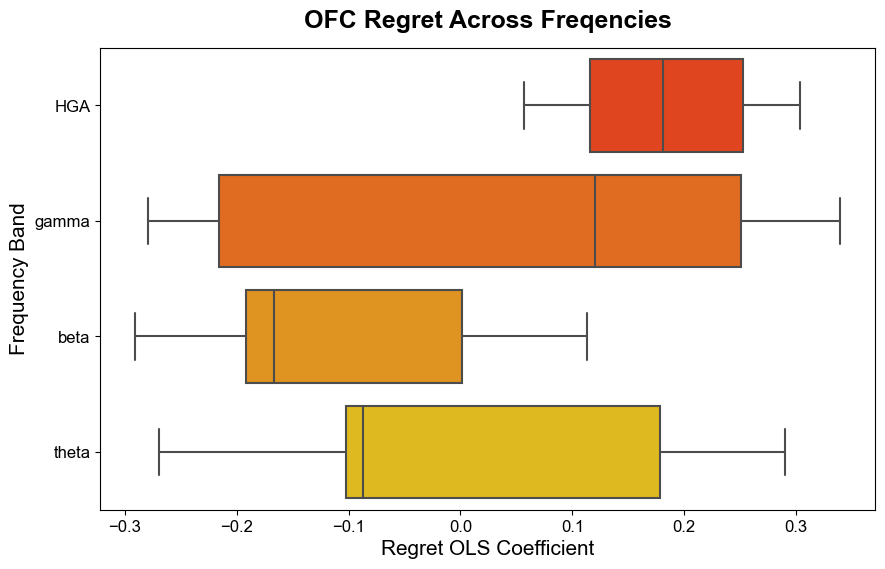

In [67]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.boxplot(data=ofc_regret_regression, x='regret_coeff',y='freq_band',order=['HGA','gamma','beta','theta'],palette='autumn')#flare_r,flare,Reds,YlOrRd, rocket
ax.set_title('OFC Regret Across Freqencies',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('Regret OLS Coefficient',weight='medium',fontsize=15,y=0.0001)
ax.set_ylabel('Frequency Band',weight='medium',fontsize=15,x=0.02)
ax.tick_params(labelsize=12)


plt.savefig(f'{proj_dir}figs/ephys_freq_band_encoding/ofc_regret.png', dpi='figure', format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   

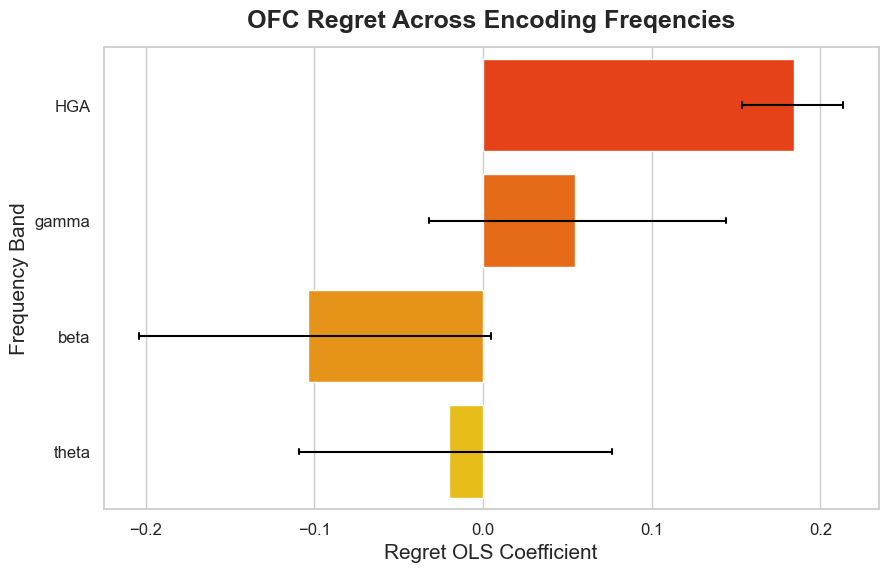

In [70]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=ofc_regret_regression, x='regret_coeff',y='freq_band',order=['HGA','gamma','beta','theta'],palette='autumn',saturation=0.8,capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket

ax.set_title('OFC Regret Across Encoding Freqencies',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('Regret OLS Coefficient',weight='medium',fontsize=15,y=0.0001)
ax.set_ylabel('Frequency Band',weight='medium',fontsize=15,x=0.02)
ax.tick_params(labelsize=12)


plt.savefig(f'{proj_dir}figs/ephys_freq_band_encoding/ofc_regret.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   

### Relief

In [71]:
for subj_id in np.unique(ofc_relief_regression.subj_id):
    elecs = np.unique(ofc_relief_regression[ofc_relief_regression.subj_id==subj_id].elec)
    print(subj_id, elecs)

MS002 ['lloif2-lmoif5' 'lloif3-lmoif10' 'lmoif2-lmoif6' 'rmoif2-racas5'
 'rmoif3-raims7' 'rmoif6-raims7']
MS003 ['lmolf5-lmolf6' 'rmolf3-rmolf2']
MS016 ['lmolf1-lacas3' 'lmolf2-lacas3' 'lmolf3-lacas2' 'lmolf5-lacas3']
MS027 ['lmolf1-lacas3' 'lmolf6-lacas3' 'rmolf5-rmolf7' 'rmolf6-rmolf4']
MS029 ['lmolf4-lacas4' 'lmolf5-lmolf7' 'lmolf6-lacas5']
MS030 ['lmoporb4-lmoporb7' 'lmoporb5-lmoporb2' 'lmoporb6-lmoporb2']


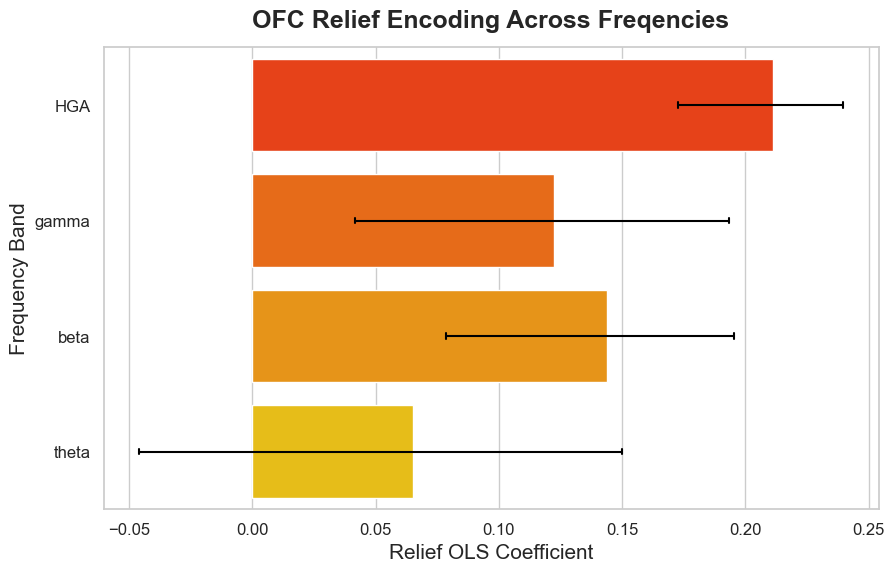

In [73]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=ofc_relief_regression, x='relief_coeff',y='freq_band',order=['HGA','gamma','beta','theta'],palette='autumn',saturation=0.8,capsize=0.05,errcolor='black',errwidth=1.5)

ax.set_title('OFC Relief Encoding Across Freqencies',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('Relief OLS Coefficient',weight='medium',fontsize=15,y=0.0001)
ax.set_ylabel('Frequency Band',weight='medium',fontsize=15,x=0.02)
ax.tick_params(labelsize=12)


plt.savefig(f'{proj_dir}figs/ephys_freq_band_encoding/ofc_relief.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   

## Cingulate

### Regret

In [93]:
cing_regret_regression

subj_id           elec       freq                           yba    av_pow  \
0    DA023      lac2-lmc1   4.000000  [['Left cingulate gyrus H']] -0.002221   
1    DA023      lac2-lmc1   4.577677  [['Left cingulate gyrus H']] -0.002038   
2    DA023      lac2-lmc1   5.238782  [['Left cingulate gyrus H']]  0.006473   
3    DA023      lac2-lmc1   5.995363  [['Left cingulate gyrus H']]  0.019949   
4    DA023      lac2-lmc1   6.861210  [['Left cingulate gyrus H']]  0.011335   
..     ...            ...        ...                           ...       ...   
79   MS030  lmcms1-lcmmf7  59.396854                 [['Unknown']]  0.017624   
80   MS030  lmcms3-lcmmf9  30.257816  [['Left cingulate gyrus I']] -0.092507   
81   MS030  lmcms3-lcmmf9  34.627629  [['Left cingulate gyrus I']] -0.014257   
82   MS030  lmcms3-lcmmf9  39.628527  [['Left cingulate gyrus I']]  0.048444   
83   MS030  lmcms3-lcmmf9  45.351651  [['Left cingulate gyrus I']]  0.087923   

    regret_coeff   p_value  r_squared freq_band  
0      -0.333100  0.027909   0.032239     theta  
1      -0.411605  0.004737   0.052646     theta  
2      -0.464535  0.000492   0.079051     theta  
3      -0.421934  0.001065   0.070045     theta  
4      -0.301323  0.016047   0.038544     theta  
..           ...       ...        ...       ...  
79     -0.213714  0.031739   0.030994     gamma  
80     -0.276809  0.006936   0.048218     gamma  
81     -0.339386  0.000658   0.075649     gamma  
82     -0.303663  0.001281   0.067891     gamma  
83     -0.207966  0.025156   0.033416     gamma  

[84 rows x 9 columns]

In [74]:
for subj_id in np.unique(cing_regret_regression.subj_id):
    elecs = np.unique(cing_regret_regression[cing_regret_regression.subj_id==subj_id].elec)
    print(subj_id, elecs)

DA023 ['lac2-lmc1' 'lmc3-lmc2']
MS002 ['lacas1-lmoif6' 'lacas2-lmoif3' 'lacas3-lmoif7' 'lacas4-lmoif5']
MS003 ['racas2-rmolf5' 'racas3-rmolf5' 'racas5-rmolf2' 'rmcms1-rmcms5']
MS017 ['lacas4-lmolf1' 'lacas5-lmolf5' 'lpcwr1']
MS019 ['rmcms1-rpioc3']
MS022 ['lacas1-lacas5']
MS026 ['rmcms3-rmcms4']
MS027 ['racas2-racas4']
MS029 ['lacas2-lmolf2' 'lacas3-lacas6' 'lmcms3-lmcms5' 'racas5-rais7'
 'rmcms2-rmcms4']
MS030 ['lacas1-lmoporb3' 'lacas2-lmoporb1' 'lacas4-lmoporb1' 'lacas6-lmoporb3'
 'lmcms1-lcmmf7' 'lmcms3-lcmmf9']


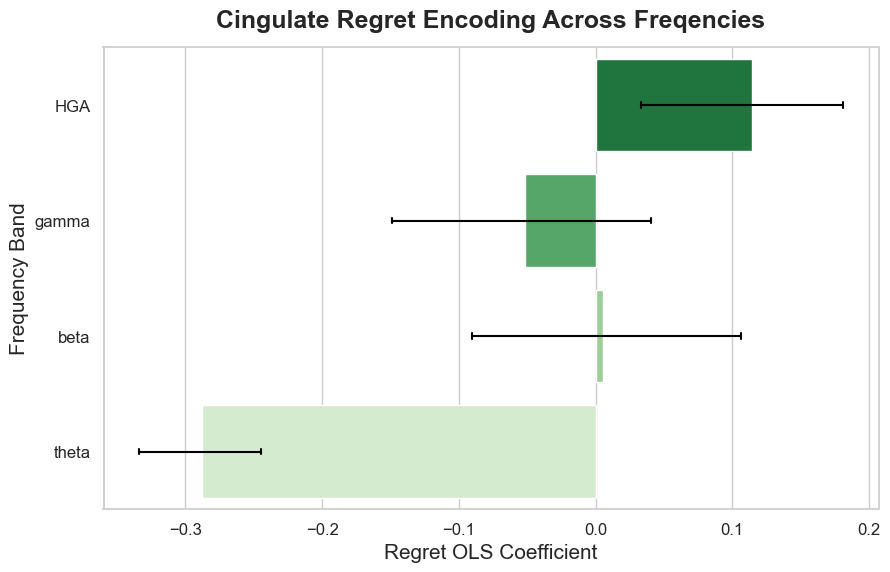

In [76]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=cing_regret_regression, x='regret_coeff',y='freq_band',order=['HGA','gamma','beta','theta'],saturation=0.8,palette='Greens_r',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket

ax.set_title('Cingulate Regret Encoding Across Freqencies',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('Regret OLS Coefficient',weight='medium',fontsize=15,y=0.0001)
ax.set_ylabel('Frequency Band',weight='medium',fontsize=15,x=0.02)
ax.tick_params(labelsize=12)


plt.savefig(f'{proj_dir}figs/ephys_freq_band_encoding/cing_regret.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   

### Relief

In [95]:
cing_relief_regression

subj_id           elec       freq                           yba    av_pow  \
0     DA023      lac1-lmc1   5.995363  [['Left cingulate gyrus G']]  0.017946   
1     DA023      lac2-lmc1   5.238782  [['Left cingulate gyrus H']]  0.006473   
2     DA023      lac2-lmc1   5.995363  [['Left cingulate gyrus H']]  0.019949   
3     DA023      lac2-lmc1   6.861210  [['Left cingulate gyrus H']]  0.011335   
4     DA023      lac2-lmc1   7.852101  [['Left cingulate gyrus H']] -0.018242   
..      ...            ...        ...                           ...       ...   
158   MS030  lmcms2-lcmmf8  39.628527  [['Left cingulate gyrus I']]  0.051117   
159   MS030  lmcms2-lcmmf8  45.351651  [['Left cingulate gyrus I']]  0.026317   
160   MS030  lmcms3-lcmmf9  67.974906  [['Left cingulate gyrus I']]  0.151942   
161   MS030  lmcms3-lcmmf9  77.791794  [['Left cingulate gyrus I']]  0.168815   
162   MS030  lmcms3-lcmmf9  89.026430  [['Left cingulate gyrus I']]  0.186714   

     relief_coeff   p_value  r_squared freq_band  
0       -0.225356  0.033891   0.030049     theta  
1       -0.297008  0.008749   0.045529     theta  
2       -0.333916  0.002157   0.061807     theta  
3       -0.309507  0.003177   0.057294     theta  
4       -0.279098  0.003124   0.057491     theta  
..            ...       ...        ...       ...  
158      0.296618  0.001205   0.068603     gamma  
159      0.221267  0.016625   0.038138     gamma  
160     -0.233512  0.009774   0.044249     gamma  
161     -0.256269  0.004097   0.054334       HGA  
162     -0.210717  0.014663   0.039578       HGA  

[163 rows x 9 columns]

In [77]:
for subj_id in np.unique(cing_relief_regression.subj_id):
    elecs = np.unique(cing_relief_regression[cing_relief_regression.subj_id==subj_id].elec)
    print(subj_id, elecs)

DA023 ['lac1-lmc1' 'lac2-lmc1']
MS002 ['lacas2-lmoif3' 'lacas3-lmoif7' 'racas2-raims7' 'racas3-raims7']
MS003 ['lacas2-lmolf1' 'lacas4-lacas8' 'racas2-rmolf5' 'racas4-racas9'
 'racas5-rmolf2' 'rmcms1-rmcms5' 'rmcms3-rmcms2']
MS016 ['lacas1-lacas3' 'lmcms3-lmcms2']
MS017 ['lacas2-lalps4' 'lacas5-lmolf5' 'lpcwr1']
MS019 ['lacas3-lmoif1' 'lacas5-lmoif1']
MS022 ['lacas1-lacas5' 'lpcsma1-lplfo1']
MS026 ['rmcms3-rmcms4']
MS027 ['lmcms2-lmcms5' 'rmcms2-racas8']
MS029 ['lacas2-lmolf2' 'lmcms3-lmcms5' 'rmcms2-rmcms4']
MS030 ['lacas1-lmoporb3' 'lacas2-lmoporb1' 'lacas4-lmoporb1' 'lacas6-lmoporb3'
 'lmcms2-lcmmf8' 'lmcms3-lcmmf9']


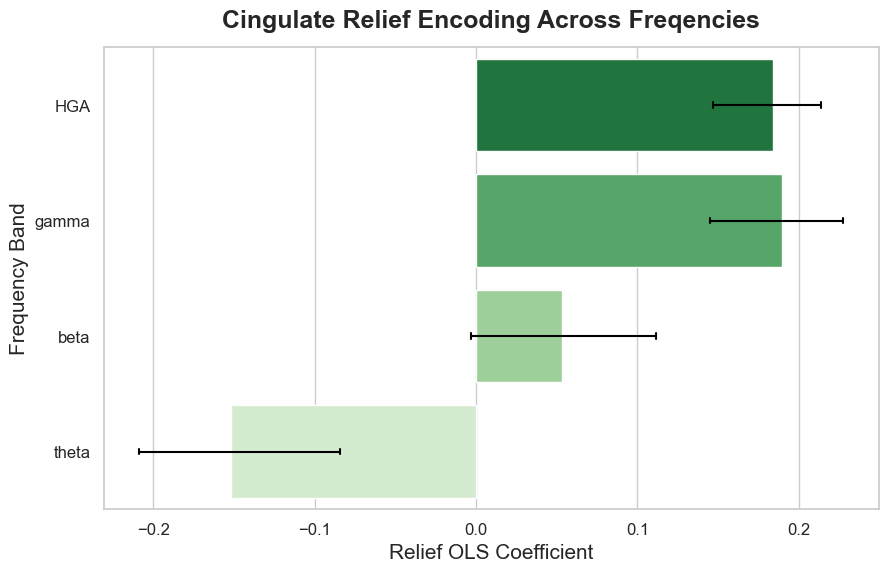

In [78]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=cing_relief_regression, x='relief_coeff',y='freq_band',order=['HGA','gamma','beta','theta'],saturation=0.8,palette='Greens_r',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket

ax.set_title('Cingulate Relief Encoding Across Freqencies',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('Relief OLS Coefficient',weight='medium',fontsize=15,y=0.0001)
ax.set_ylabel('Frequency Band',weight='medium',fontsize=15,x=0.02)
ax.tick_params(labelsize=12)


plt.savefig(f'{proj_dir}figs/ephys_freq_band_encoding/cing_relief.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   

## Insula

### Regret

In [97]:
ins_regret_regression

subj_id           elec        freq  \
0      DA8      ltp4-lip2    4.000000   
1      DA8      ltp4-lip2    4.577677   
2    MS002  laims3-lmoif8   77.791794   
3    MS002  laims3-lmoif8   89.026430   
4    MS002  laims3-lmoif8  101.883565   
..     ...            ...         ...   
82   MS030  lsipt2-lsipt3   67.974906   
83   MS030  lsipt2-lsipt3   77.791794   
84   MS030  lsipt2-lsipt3   89.026430   
85   MS030  lsipt2-lsipt3  101.883565   
86   MS030  lsipt2-lsipt3  116.597518   

                                        yba    av_pow  regret_coeff   p_value  \
0                             [['Unknown']]  0.029126      0.209656  0.025440   
1                             [['Unknown']]  0.034041      0.176719  0.032528   
2                             [['Unknown']]  0.108899     -0.146414  0.026085   
3                             [['Unknown']]  0.129021     -0.184762  0.012235   
4                             [['Unknown']]  0.140971     -0.221510  0.005569   
..                                      ...       ...           ...       ...   
82  [['Left middle short insular gyrus A']]  0.025669     -0.202806  0.000076   
83  [['Left middle short insular gyrus A']]  0.012370     -0.192191  0.000386   
84  [['Left middle short insular gyrus A']]  0.002737     -0.180979  0.002985   
85  [['Left middle short insular gyrus A']] -0.001961     -0.180623  0.013594   
86  [['Left middle short insular gyrus A']] -0.009926     -0.190840  0.032493   

    r_squared freq_band  
0    0.033738     theta  
1    0.030923     theta  
2    0.033004       HGA  
3    0.041659       HGA  
4    0.050765       HGA  
..        ...       ...  
82   0.102751     gamma  
83   0.083500       HGA  
84   0.059187       HGA  
85   0.041269       HGA  
86   0.031146       HGA  

[87 rows x 9 columns]

In [79]:
for subj_id in np.unique(ins_regret_regression.subj_id):
    elecs = np.unique(ins_regret_regression[ins_regret_regression.subj_id==subj_id].elec)
    print(subj_id, elecs)

DA8 ['ltp4-lip2']
MS002 ['laims3-lmoif8' 'lpips1-lpips3' 'raims1-ragit5']
MS003 ['laimm1-laglt5' 'laimm2-laglt5' 'laimm4-lsifo1' 'raimm2-rmolf5'
 'raimm3-rmolf9' 'raimm4-rsifo1' 'rsifo2-rsifo5']
MS017 ['lalps1-lalps6' 'lalps2-lalps6']
MS030 ['lsipt2-lsipt3']


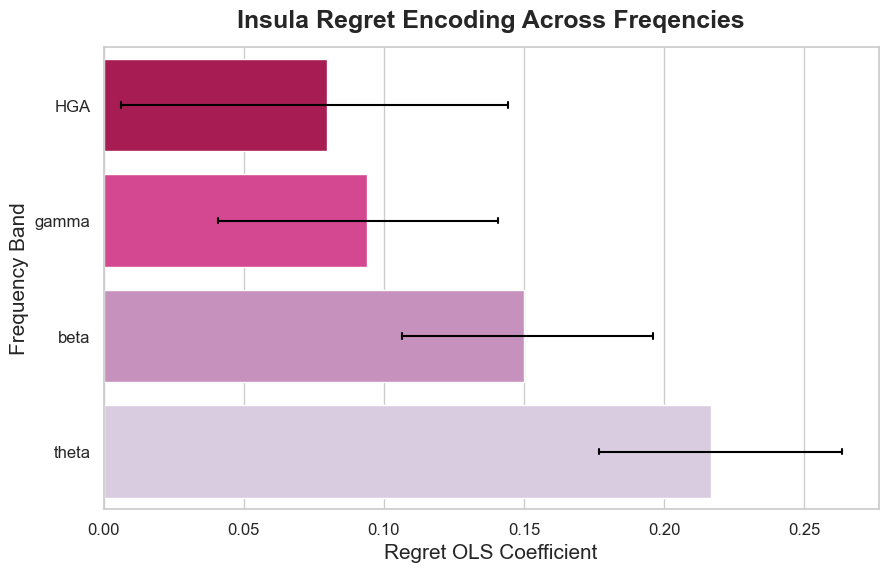

In [80]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=ins_regret_regression, x='regret_coeff',y='freq_band',order=['HGA','gamma','beta','theta'],saturation=0.8,palette='PuRd_r',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket

ax.set_title('Insula Regret Encoding Across Freqencies',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('Regret OLS Coefficient',weight='medium',fontsize=15,y=0.0001)
ax.set_ylabel('Frequency Band',weight='medium',fontsize=15,x=0.02)
ax.tick_params(labelsize=12)


plt.savefig(f'{proj_dir}figs/ephys_freq_band_encoding/ins_regret.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   


### Relief

In [81]:
for subj_id in np.unique(ins_relief_regression.subj_id):
    elecs = np.unique(ins_relief_regression[ins_relief_regression.subj_id==subj_id].elec)
    print(subj_id, elecs)

DA8 ['ltp4-lip2']
MS002 ['laims1-lmoif8' 'laims2-lmoif8' 'laims3-lmoif8' 'laims4-laims7'
 'laims5-laims7' 'lpips1-lpips3' 'lpips4-lpips5' 'raims1-ragit5'
 'raims2-ragit5' 'raims3-raims7' 'raims4-raims8']
MS003 ['laimm1-laglt5' 'laimm2-laglt5' 'laimm4-lsifo1' 'lsifo2-lsifo1'
 'raimm1-rmolf8' 'raimm2-rmolf5' 'raimm3-rmolf9' 'raimm4-rsifo1']
MS016 ['laimm1-lagit4' 'laimm2-lagit4' 'laimm3-lagit4' 'laimm4-lagit4']
MS017 ['lalps1-lalps6' 'lalps2-lalps6']
MS027 ['raisp7-raisp11' 'raisp8-raisp11']
MS029 ['rais3-rais7' 'rais4-rais7']
MS030 ['lpipo2-lpipo1' 'lsipt2-lsipt3']


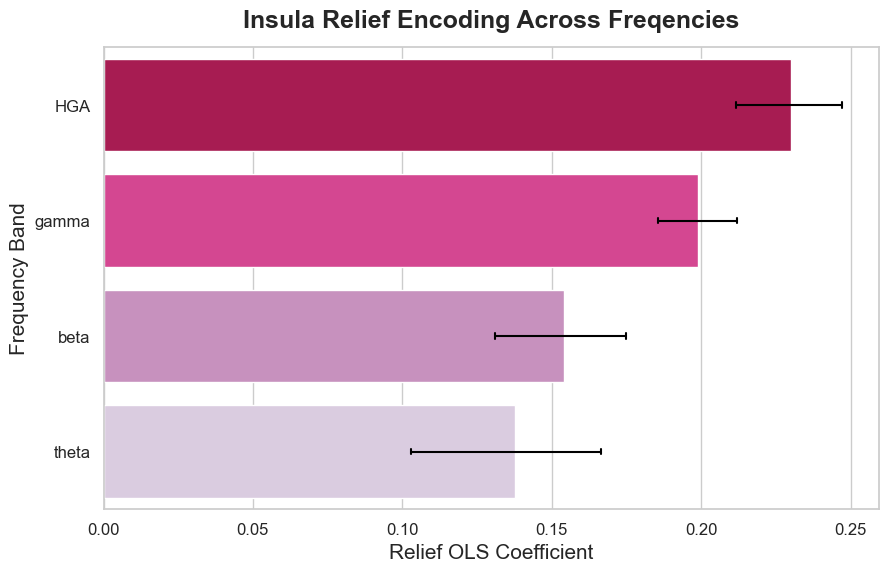

In [82]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=ins_relief_regression, x='relief_coeff',y='freq_band',order=['HGA','gamma','beta','theta'],saturation=0.8,palette='PuRd_r',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket

ax.set_title('Insula Relief Encoding Across Freqencies',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('Relief OLS Coefficient',weight='medium',fontsize=15,y=0.0001)
ax.set_ylabel('Frequency Band',weight='medium',fontsize=15,x=0.02)
ax.tick_params(labelsize=12)


plt.savefig(f'{proj_dir}figs/ephys_freq_band_encoding/ins_relief.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)  

## Amygdala

### Regret

In [99]:
amy_regret_regression.head()

subj_id           elec        freq                            yba    av_pow  \
0   MS002  lagit1-lagit6  152.707248   [['Left amygdala inferior']] -0.046920   
1   MS002  lagit1-lagit6  174.761122   [['Left amygdala inferior']] -0.048886   
2   MS002  lagit2-lagit6   34.627629   [['Left amygdala inferior']] -0.008940   
3   MS002  lagit2-lagit6   39.628527   [['Left amygdala inferior']] -0.029176   
4   MS002  ragit1-rhplt6    5.238782  [['Right amygdala superior']]  0.005400   

   regret_coeff   p_value  r_squared freq_band  
0      0.146289  0.019640   0.036233       HGA  
1      0.160355  0.023684   0.034100       HGA  
2     -0.255926  0.022130   0.034872     gamma  
3     -0.251929  0.021678   0.035107     gamma  
4     -0.165441  0.026044   0.033022     theta

In [100]:
for subj_id in np.unique(amy_regret_regression.subj_id):
    elecs = np.unique(amy_regret_regression[amy_regret_regression.subj_id==subj_id].elec)
    print(subj_id, elecs)

MS002 ['lagit1-lagit6' 'lagit2-lagit6' 'ragit1-rhplt6']
MS003 ['raglt1-rmolf2' 'raglt3-rsifo1']
MS016 ['lagit1-lagit4' 'ragit1-ragit4' 'ragit2-ragit4']


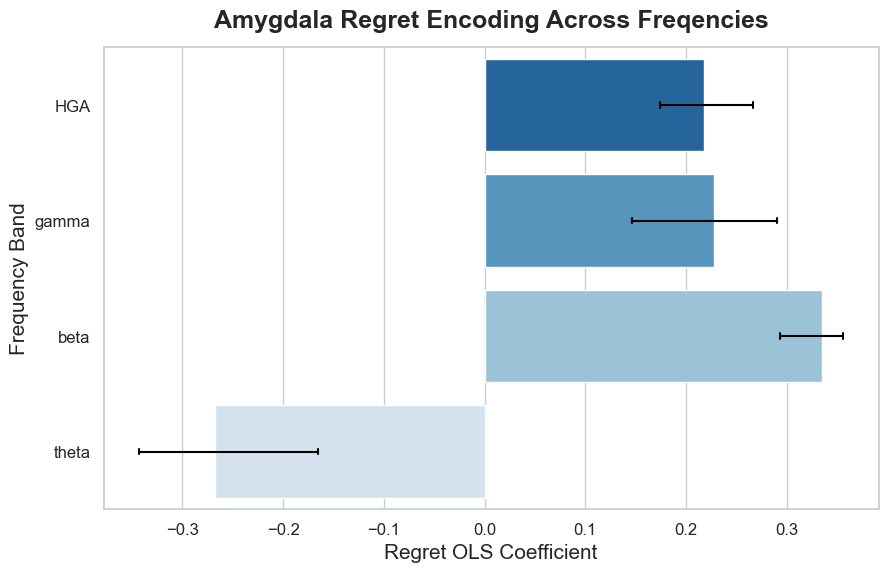

In [83]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=amy_regret_regression, x='regret_coeff',y='freq_band',order=['HGA','gamma','beta','theta'],saturation=0.8,palette='Blues_r',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket

ax.set_title('Amygdala Regret Encoding Across Freqencies',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('Regret OLS Coefficient',weight='medium',fontsize=15,y=0.0001)
ax.set_ylabel('Frequency Band',weight='medium',fontsize=15,x=0.02)
ax.tick_params(labelsize=12)


plt.savefig(f'{proj_dir}figs/ephys_freq_band_encoding/amy_regret.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)  

### Relief

In [101]:
amy_relief_regression.head()

subj_id       elec       freq                            yba    av_pow  \
0   DA023  lam4-lam6  30.257816  [['Left amygdala superior ']] -0.012705   
1   DA023  lam4-lam6  34.627629  [['Left amygdala superior ']] -0.002168   
2   DA023  lam4-lam6  39.628527  [['Left amygdala superior ']]  0.018012   
3   DA023  lam4-lam6  45.351651  [['Left amygdala superior ']]  0.027291   
4   DA023  lam5-lam6  30.257816  [['Left amygdala superior ']] -0.025576   

   relief_coeff   p_value  r_squared freq_band  
0     -0.175062  0.014151   0.039986     gamma  
1     -0.216421  0.002666   0.059337     gamma  
2     -0.224480  0.003275   0.056941     gamma  
3     -0.143670  0.019734   0.036178     gamma  
4     -0.205802  0.028222   0.032113     gamma

In [84]:
for subj_id in np.unique(amy_relief_regression.subj_id):
    elecs = np.unique(amy_relief_regression[amy_relief_regression.subj_id==subj_id].elec)
    print(subj_id, elecs)

DA023 ['lam4-lam6' 'lam5-lam6']
MS002 ['lagit1-lagit6' 'lagit2-lagit6']
MS003 ['raglt1-rmolf2']
MS016 ['lagit1-lagit4' 'ragit1-ragit4' 'ragit2-ragit4']
MS017 ['laglt1-ltplt4']


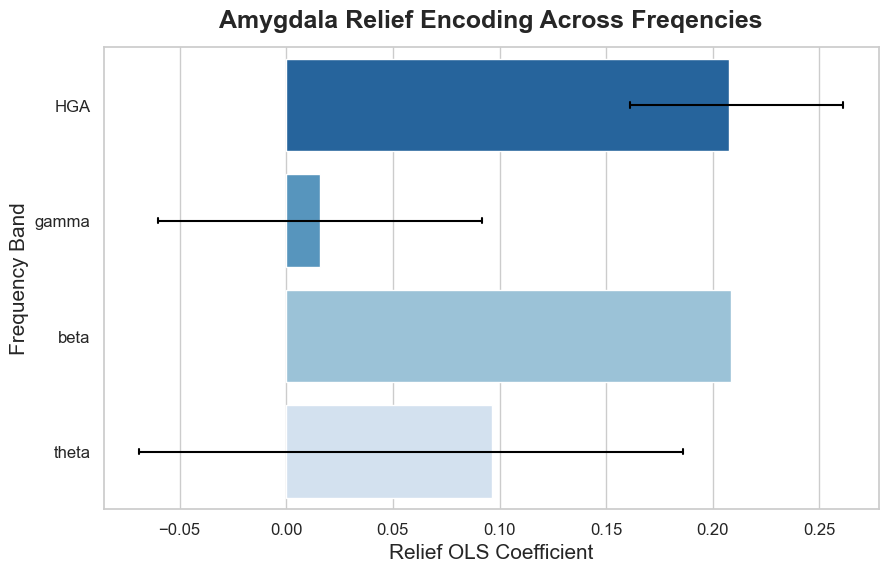

In [85]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=amy_relief_regression, x='relief_coeff',y='freq_band',order=['HGA','gamma','beta','theta'],saturation=0.8,palette='Blues_r',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket

ax.set_title('Amygdala Relief Encoding Across Freqencies',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('Relief OLS Coefficient',weight='medium',fontsize=15,y=0.0001)
ax.set_ylabel('Frequency Band',weight='medium',fontsize=15,x=0.02)
ax.tick_params(labelsize=12)


plt.savefig(f'{proj_dir}figs/ephys_freq_band_encoding/amy_relief.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)  

## Frontal Pole

### Regret

In [103]:
fpole_regret_regression.head()

subj_id           elec       freq                          yba    av_pow  \
0   MS017  lmolf7-lalps4  39.628527  [['Left frontal pole 3 F']]  0.183878   
1   MS017  lmolf7-lalps4  45.351651  [['Left frontal pole 3 F']]  0.177736   
2   MS017  lmolf7-lalps4  51.901304  [['Left frontal pole 3 F']]  0.173297   
3   MS017  lmolf7-lalps4  59.396854  [['Left frontal pole 3 F']]  0.173667   
4   MS017  lmolf7-lalps4  67.974906  [['Left frontal pole 3 F']]  0.171469   

   regret_coeff   p_value  r_squared freq_band  
0      0.272225  0.009184   0.044968     gamma  
1      0.366783  0.000814   0.073173     gamma  
2      0.425960  0.000224   0.088192     gamma  
3      0.393300  0.000738   0.074314     gamma  
4      0.321065  0.005257   0.051436     gamma

<AxesSubplot: xlabel='regret_coeff', ylabel='freq_band'>

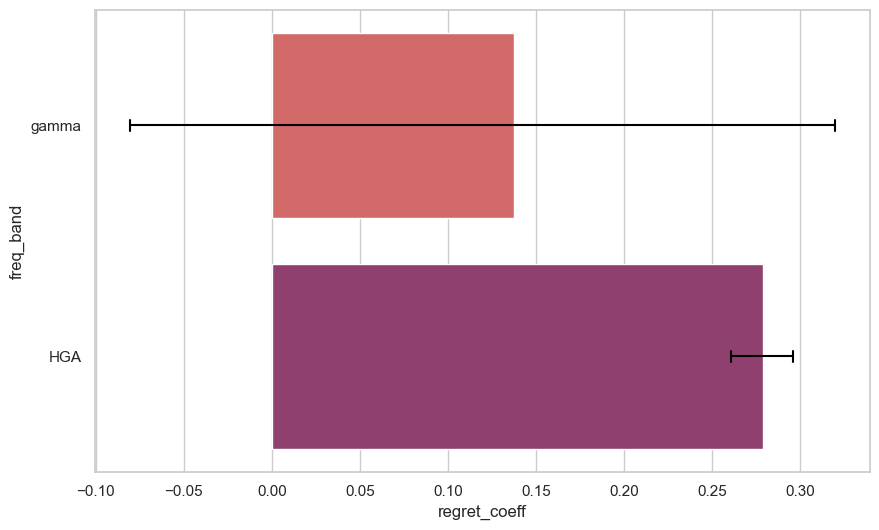

In [119]:
#magma,cubehelix,twilight
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=fpole_regret_regression, x='regret_coeff',y='freq_band',order=['gamma','HGA'],saturation=0.8,palette='flare',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket
#ax.set_title('SWB Model Evaluation',weight='semibold',fontsize=18,y=1.025)
#ax.set_xlabel('SWB Models',weight='medium',fontsize=15)
#ax.set_ylabel('Mean BIC Score',weight='medium',fontsize=15,x=0.025)
#ax.tick_params(labelsize=12)

### Relief

In [105]:
fpole_relief_regression.head()

subj_id           elec       freq                           yba    av_pow  \
0   MS003  racas1-rmolf5  23.102939  [['Right frontal pole 1 C']] -0.116924   
1   MS003  racas1-rmolf5  26.439449  [['Right frontal pole 1 C']] -0.123399   
2   MS017  lmolf7-lalps4   4.000000   [['Left frontal pole 3 F']]  0.109611   
3   MS017  lmolf7-lalps4  45.351651   [['Left frontal pole 3 F']]  0.177736   
4   MS017  lmolf7-lalps4  51.901304   [['Left frontal pole 3 F']]  0.173297   

   relief_coeff   p_value  r_squared freq_band  
0      0.202814  0.021410   0.035249      beta  
1      0.216658  0.014336   0.039837      beta  
2     -0.253743  0.004534   0.053154     theta  
3      0.214852  0.020380   0.035810     gamma  
4      0.224788  0.021826   0.035030     gamma

In [106]:
for subj_id in np.unique(fpole_relief_regression.subj_id):
    elecs = np.unique(fpole_relief_regression[fpole_relief_regression.subj_id==subj_id].elec)
    print(subj_id, elecs)

MS003 ['racas1-rmolf5']
MS017 ['lmolf7-lalps4' 'lmolf8-lalps4']
MS019 ['racas6-racas4']


<AxesSubplot: xlabel='relief_coeff', ylabel='freq_band'>

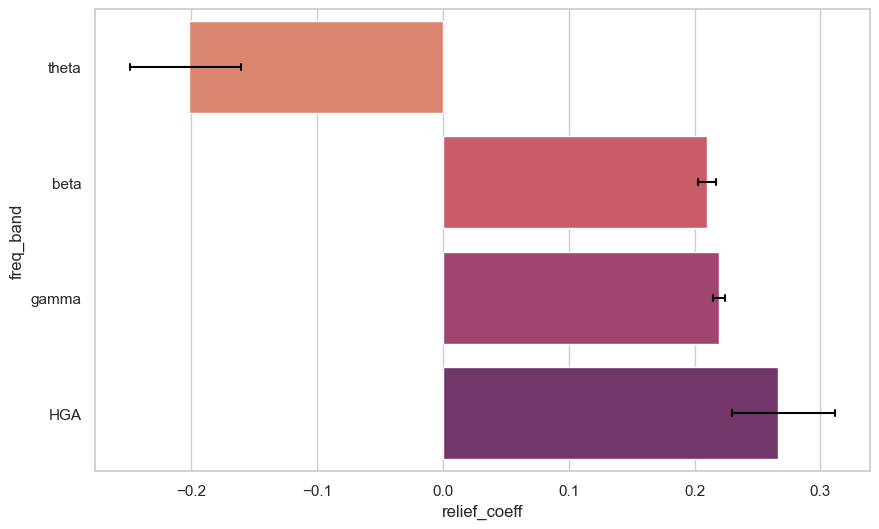

In [122]:
#magma,cubehelix,twilight
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=fpole_relief_regression, x='relief_coeff',y='freq_band',order=['theta','beta','gamma','HGA'],saturation=0.8,palette='flare',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket
#ax.set_title('SWB Model Evaluation',weight='semibold',fontsize=18,y=1.025)
#ax.set_xlabel('SWB Models',weight='medium',fontsize=15)
#ax.set_ylabel('Mean BIC Score',weight='medium',fontsize=15,x=0.025)
#ax.tick_params(labelsize=12)

# Depression Analyses

#### Add BDI to dfs

In [123]:
bdi_list = pd.read_excel(f'{proj_dir}subjects.xlsx', sheet_name='patient_info', usecols=[0,3])
bdi_list

PatientID  SWB_BDI
0        DA8       13
1        DA9       32
2       DA10       11
3       DA11       41
4      DA023       14
5      MS002       14
6      MS003        8
7      MS016       10
8      MS017       26
9      MS019       12
10     MS022       10
11     MS025       10
12     MS026        9
13     MS027       22
14     MS029       32
15     MS030       19

In [124]:
bdi_subj = list(zip(subj_ids,list(bdi_list.SWB_BDI)))
bdi_dict = {}
for subj_id in subj_ids:
    bdi = int(bdi_list.SWB_BDI[bdi_list.PatientID==subj_id])
    bdi_dict[subj_id]=bdi


In [125]:
bdi_dict

{'DA8': 13,
 'DA9': 32,
 'DA10': 11,
 'DA11': 41,
 'DA023': 14,
 'MS002': 14,
 'MS003': 8,
 'MS016': 10,
 'MS017': 26,
 'MS019': 12,
 'MS022': 10,
 'MS025': 10,
 'MS026': 9,
 'MS027': 22,
 'MS029': 32,
 'MS030': 19}

In [126]:
print('ofc_regret',np.unique(ofc_regret_regression.subj_id))
print('ofc_relief',np.unique(ofc_relief_regression.subj_id))
print('ins_regret',np.unique(ins_regret_regression.subj_id))
print('ins_relief',np.unique(ins_relief_regression.subj_id))
print('cing_regret',np.unique(cing_regret_regression.subj_id))
print('cing_relief',np.unique(cing_relief_regression.subj_id))
print('amy_regret',np.unique(amy_regret_regression.subj_id)) #no depressed subj
print('amy_relief',np.unique(amy_relief_regression.subj_id)) #only ms17
print('fpole_regret',np.unique(fpole_regret_regression.subj_id)) #only depressed pts
print('fpole_relief',np.unique(fpole_relief_regression.subj_id)) #only ms17

ofc_regret ['MS002' 'MS003' 'MS016' 'MS026' 'MS027' 'MS029' 'MS030']
ofc_relief ['MS002' 'MS003' 'MS016' 'MS027' 'MS029' 'MS030']
ins_regret ['DA8' 'MS002' 'MS003' 'MS017' 'MS030']
ins_relief ['DA8' 'MS002' 'MS003' 'MS016' 'MS017' 'MS027' 'MS029' 'MS030']
cing_regret ['DA023' 'MS002' 'MS003' 'MS017' 'MS019' 'MS022' 'MS026' 'MS027' 'MS029'
 'MS030']
cing_relief ['DA023' 'MS002' 'MS003' 'MS016' 'MS017' 'MS019' 'MS022' 'MS026' 'MS027'
 'MS029' 'MS030']
amy_regret ['MS002' 'MS003' 'MS016']
amy_relief ['DA023' 'MS002' 'MS003' 'MS016' 'MS017']
fpole_regret ['MS017' 'MS029']
fpole_relief ['MS003' 'MS017' 'MS019']


In [127]:
ofc_reg_bdi = []

for subj_id in ofc_regret_regression.subj_id:
    bdi = bdi_dict[subj_id]
    ofc_reg_bdi.append(bdi)

ofc_regret_regression['bdi'] = ofc_reg_bdi
ofc_regret_regression

subj_id               elec        freq                             yba  \
0    MS002      lloif2-lmoif5   26.439449  [['Left frontal orbital 4 D']]   
1    MS002      lloif2-lmoif5   30.257816  [['Left frontal orbital 4 D']]   
2    MS002      lloif2-lmoif5   34.627629  [['Left frontal orbital 4 D']]   
3    MS002      lloif2-lmoif5   39.628527  [['Left frontal orbital 4 D']]   
4    MS002      lloif2-lmoif5   45.351651  [['Left frontal orbital 4 D']]   
..     ...                ...         ...                             ...   
80   MS030  lmoporb6-lmoporb2  116.597518  [['Left frontal orbital 4 D']]   
81   MS030  lmoporb6-lmoporb2  133.436450  [['Left frontal orbital 4 D']]   
82   MS030  lmoporb6-lmoporb2  152.707248  [['Left frontal orbital 4 D']]   
83   MS030  lmoporb6-lmoporb2  174.761122  [['Left frontal orbital 4 D']]   
84   MS030  lmoporb6-lmoporb2  200.000000  [['Left frontal orbital 4 D']]   

      av_pow  regret_coeff   p_value  r_squared freq_band  bdi  
0   0.037201     -0.178107  0.005011   0.051991      beta   14  
1   0.027334     -0.222168  0.000992   0.070867     gamma   14  
2   0.010172     -0.243718  0.001141   0.069237     gamma   14  
3  -0.015643     -0.253747  0.002682   0.059271     gamma   14  
4  -0.037076     -0.233877  0.009519   0.044554     gamma   14  
..       ...           ...       ...        ...       ...  ...  
80  0.020293      0.194403  0.022802   0.034763       HGA   19  
81 -0.006005      0.181021  0.008081   0.046758       HGA   19  
82 -0.013240      0.157829  0.008844   0.045707       HGA   19  
83 -0.008663      0.149949  0.009416   0.044978       HGA   19  
84 -0.007323      0.147005  0.005764   0.050699       HGA   19  

[85 rows x 10 columns]

In [128]:
ofc_rel_bdi = []

for subj_id in ofc_relief_regression.subj_id:
    bdi = bdi_dict[subj_id]
    ofc_rel_bdi.append(bdi)

ofc_relief_regression['bdi'] = ofc_rel_bdi
ofc_relief_regression

subj_id               elec        freq                             yba  \
0    MS002      lloif2-lmoif5   15.413871  [['Left frontal orbital 4 D']]   
1    MS002      lloif2-lmoif5   17.639931  [['Left frontal orbital 4 D']]   
2    MS002      lloif2-lmoif5   20.187478  [['Left frontal orbital 4 D']]   
3    MS002     lloif3-lmoif10    6.861210  [['Left frontal orbital 4 D']]   
4    MS002      lmoif2-lmoif6  133.436450  [['Left frontal orbital 3 B']]   
..     ...                ...         ...                             ...   
87   MS030  lmoporb6-lmoporb2  116.597518  [['Left frontal orbital 4 D']]   
88   MS030  lmoporb6-lmoporb2  133.436450  [['Left frontal orbital 4 D']]   
89   MS030  lmoporb6-lmoporb2  152.707248  [['Left frontal orbital 4 D']]   
90   MS030  lmoporb6-lmoporb2  174.761122  [['Left frontal orbital 4 D']]   
91   MS030  lmoporb6-lmoporb2  200.000000  [['Left frontal orbital 4 D']]   

      av_pow  relief_coeff   p_value  r_squared freq_band  bdi  
0  -0.000621      0.139470  0.014122   0.040010      beta   14  
1   0.027160      0.170072  0.006494   0.048981      beta   14  
2   0.038584      0.150583  0.015529   0.038920      beta   14  
3   0.024550     -0.203998  0.030955   0.031069     theta   14  
4  -0.026811      0.250182  0.030816   0.031120       HGA   14  
..       ...           ...       ...        ...       ...  ...  
87  0.020293      0.270589  0.000112   0.096859       HGA   19  
88 -0.006005      0.222539  0.000074   0.101630       HGA   19  
89 -0.013240      0.181397  0.000264   0.086831       HGA   19  
90 -0.008663      0.169153  0.000389   0.082316       HGA   19  
91 -0.007323      0.162431  0.000219   0.089019       HGA   19  

[92 rows x 10 columns]

In [129]:
ins_reg_bdi = []

for subj_id in ins_regret_regression.subj_id:
    bdi = bdi_dict[subj_id]
    ins_reg_bdi.append(bdi)

ins_regret_regression['bdi'] = ins_reg_bdi
ins_regret_regression

subj_id           elec        freq  \
0      DA8      ltp4-lip2    4.000000   
1      DA8      ltp4-lip2    4.577677   
2    MS002  laims3-lmoif8   77.791794   
3    MS002  laims3-lmoif8   89.026430   
4    MS002  laims3-lmoif8  101.883565   
..     ...            ...         ...   
82   MS030  lsipt2-lsipt3   67.974906   
83   MS030  lsipt2-lsipt3   77.791794   
84   MS030  lsipt2-lsipt3   89.026430   
85   MS030  lsipt2-lsipt3  101.883565   
86   MS030  lsipt2-lsipt3  116.597518   

                                        yba    av_pow  regret_coeff   p_value  \
0                             [['Unknown']]  0.029126      0.209656  0.025440   
1                             [['Unknown']]  0.034041      0.176719  0.032528   
2                             [['Unknown']]  0.108899     -0.146414  0.026085   
3                             [['Unknown']]  0.129021     -0.184762  0.012235   
4                             [['Unknown']]  0.140971     -0.221510  0.005569   
..                                      ...       ...           ...       ...   
82  [['Left middle short insular gyrus A']]  0.025669     -0.202806  0.000076   
83  [['Left middle short insular gyrus A']]  0.012370     -0.192191  0.000386   
84  [['Left middle short insular gyrus A']]  0.002737     -0.180979  0.002985   
85  [['Left middle short insular gyrus A']] -0.001961     -0.180623  0.013594   
86  [['Left middle short insular gyrus A']] -0.009926     -0.190840  0.032493   

    r_squared freq_band  bdi  
0    0.033738     theta   13  
1    0.030923     theta   13  
2    0.033004       HGA   14  
3    0.041659       HGA   14  
4    0.050765       HGA   14  
..        ...       ...  ...  
82   0.102751     gamma   19  
83   0.083500       HGA   19  
84   0.059187       HGA   19  
85   0.041269       HGA   19  
86   0.031146       HGA   19  

[87 rows x 10 columns]

In [130]:
ins_rel_bdi = []

for subj_id in ins_relief_regression.subj_id:
    bdi = bdi_dict[subj_id]
    ins_rel_bdi.append(bdi)

ins_relief_regression['bdi'] = ins_rel_bdi
ins_relief_regression

subj_id           elec        freq  \
0       DA8      ltp4-lip2    4.000000   
1       DA8      ltp4-lip2   34.627629   
2     MS002  laims1-lmoif8   11.769049   
3     MS002  laims1-lmoif8   13.468727   
4     MS002  laims1-lmoif8   15.413871   
..      ...            ...         ...   
304   MS030  lsipt2-lsipt3    5.238782   
305   MS030  lsipt2-lsipt3    5.995363   
306   MS030  lsipt2-lsipt3    6.861210   
307   MS030  lsipt2-lsipt3   23.102939   
308   MS030  lsipt2-lsipt3  200.000000   

                                         yba    av_pow  relief_coeff  \
0                              [['Unknown']]  0.029126      0.194705   
1                              [['Unknown']]  0.020518     -0.090816   
2    [['Left middle short insular gyrus C']] -0.034365      0.159520   
3    [['Left middle short insular gyrus C']] -0.002316      0.238756   
4    [['Left middle short insular gyrus C']]  0.015324      0.249540   
..                                       ...       ...           ...   
304  [['Left middle short insular gyrus A']] -0.004839      0.208329   
305  [['Left middle short insular gyrus A']] -0.026340      0.181126   
306  [['Left middle short insular gyrus A']] -0.054337      0.142363   
307  [['Left middle short insular gyrus A']] -0.027874      0.129353   
308  [['Left middle short insular gyrus A']] -0.040017      0.234275   

      p_value  r_squared freq_band  bdi  
0    0.029085   0.032202     theta   13  
1    0.025769   0.033590     gamma   13  
2    0.025469   0.033275     alpha   14  
3    0.000278   0.085692      beta   14  
4    0.000014   0.120450      beta   14  
..        ...        ...       ...  ...  
304  0.001213   0.069896     theta   19  
305  0.002882   0.059607     theta   19  
306  0.014442   0.040561     theta   19  
307  0.013575   0.041286      beta   19  
308  0.004702   0.053797       HGA   19  

[309 rows x 10 columns]

In [131]:
cing_reg_bdi = []

for subj_id in cing_regret_regression.subj_id:
    bdi = bdi_dict[subj_id]
    cing_reg_bdi.append(bdi)

cing_regret_regression['bdi'] = cing_reg_bdi
cing_regret_regression

subj_id           elec       freq                           yba    av_pow  \
0    DA023      lac2-lmc1   4.000000  [['Left cingulate gyrus H']] -0.002221   
1    DA023      lac2-lmc1   4.577677  [['Left cingulate gyrus H']] -0.002038   
2    DA023      lac2-lmc1   5.238782  [['Left cingulate gyrus H']]  0.006473   
3    DA023      lac2-lmc1   5.995363  [['Left cingulate gyrus H']]  0.019949   
4    DA023      lac2-lmc1   6.861210  [['Left cingulate gyrus H']]  0.011335   
..     ...            ...        ...                           ...       ...   
79   MS030  lmcms1-lcmmf7  59.396854                 [['Unknown']]  0.017624   
80   MS030  lmcms3-lcmmf9  30.257816  [['Left cingulate gyrus I']] -0.092507   
81   MS030  lmcms3-lcmmf9  34.627629  [['Left cingulate gyrus I']] -0.014257   
82   MS030  lmcms3-lcmmf9  39.628527  [['Left cingulate gyrus I']]  0.048444   
83   MS030  lmcms3-lcmmf9  45.351651  [['Left cingulate gyrus I']]  0.087923   

    regret_coeff   p_value  r_squared freq_band  bdi  
0      -0.333100  0.027909   0.032239     theta   14  
1      -0.411605  0.004737   0.052646     theta   14  
2      -0.464535  0.000492   0.079051     theta   14  
3      -0.421934  0.001065   0.070045     theta   14  
4      -0.301323  0.016047   0.038544     theta   14  
..           ...       ...        ...       ...  ...  
79     -0.213714  0.031739   0.030994     gamma   19  
80     -0.276809  0.006936   0.048218     gamma   19  
81     -0.339386  0.000658   0.075649     gamma   19  
82     -0.303663  0.001281   0.067891     gamma   19  
83     -0.207966  0.025156   0.033416     gamma   19  

[84 rows x 10 columns]

In [132]:
cing_rel_bdi = []

for subj_id in cing_relief_regression.subj_id:
    bdi = bdi_dict[subj_id]
    cing_rel_bdi.append(bdi)

cing_relief_regression['bdi'] = cing_rel_bdi
cing_relief_regression

subj_id           elec       freq                           yba    av_pow  \
0     DA023      lac1-lmc1   5.995363  [['Left cingulate gyrus G']]  0.017946   
1     DA023      lac2-lmc1   5.238782  [['Left cingulate gyrus H']]  0.006473   
2     DA023      lac2-lmc1   5.995363  [['Left cingulate gyrus H']]  0.019949   
3     DA023      lac2-lmc1   6.861210  [['Left cingulate gyrus H']]  0.011335   
4     DA023      lac2-lmc1   7.852101  [['Left cingulate gyrus H']] -0.018242   
..      ...            ...        ...                           ...       ...   
158   MS030  lmcms2-lcmmf8  39.628527  [['Left cingulate gyrus I']]  0.051117   
159   MS030  lmcms2-lcmmf8  45.351651  [['Left cingulate gyrus I']]  0.026317   
160   MS030  lmcms3-lcmmf9  67.974906  [['Left cingulate gyrus I']]  0.151942   
161   MS030  lmcms3-lcmmf9  77.791794  [['Left cingulate gyrus I']]  0.168815   
162   MS030  lmcms3-lcmmf9  89.026430  [['Left cingulate gyrus I']]  0.186714   

     relief_coeff   p_value  r_squared freq_band  bdi  
0       -0.225356  0.033891   0.030049     theta   14  
1       -0.297008  0.008749   0.045529     theta   14  
2       -0.333916  0.002157   0.061807     theta   14  
3       -0.309507  0.003177   0.057294     theta   14  
4       -0.279098  0.003124   0.057491     theta   14  
..            ...       ...        ...       ...  ...  
158      0.296618  0.001205   0.068603     gamma   19  
159      0.221267  0.016625   0.038138     gamma   19  
160     -0.233512  0.009774   0.044249     gamma   19  
161     -0.256269  0.004097   0.054334       HGA   19  
162     -0.210717  0.014663   0.039578       HGA   19  

[163 rows x 10 columns]

In [133]:
amy_reg_bdi = []

for subj_id in amy_regret_regression.subj_id:
    bdi = bdi_dict[subj_id]
    amy_reg_bdi.append(bdi)

amy_regret_regression['bdi'] = amy_reg_bdi
amy_regret_regression.head()

subj_id           elec        freq                            yba    av_pow  \
0   MS002  lagit1-lagit6  152.707248   [['Left amygdala inferior']] -0.046920   
1   MS002  lagit1-lagit6  174.761122   [['Left amygdala inferior']] -0.048886   
2   MS002  lagit2-lagit6   34.627629   [['Left amygdala inferior']] -0.008940   
3   MS002  lagit2-lagit6   39.628527   [['Left amygdala inferior']] -0.029176   
4   MS002  ragit1-rhplt6    5.238782  [['Right amygdala superior']]  0.005400   

   regret_coeff   p_value  r_squared freq_band  bdi  
0      0.146289  0.019640   0.036233       HGA   14  
1      0.160355  0.023684   0.034100       HGA   14  
2     -0.255926  0.022130   0.034872     gamma   14  
3     -0.251929  0.021678   0.035107     gamma   14  
4     -0.165441  0.026044   0.033022     theta   14

In [134]:
amy_rel_bdi = []

for subj_id in amy_relief_regression.subj_id:
    bdi = bdi_dict[subj_id]
    amy_rel_bdi.append(bdi)

amy_relief_regression['bdi'] = amy_rel_bdi
amy_relief_regression.head()

subj_id       elec       freq                            yba    av_pow  \
0   DA023  lam4-lam6  30.257816  [['Left amygdala superior ']] -0.012705   
1   DA023  lam4-lam6  34.627629  [['Left amygdala superior ']] -0.002168   
2   DA023  lam4-lam6  39.628527  [['Left amygdala superior ']]  0.018012   
3   DA023  lam4-lam6  45.351651  [['Left amygdala superior ']]  0.027291   
4   DA023  lam5-lam6  30.257816  [['Left amygdala superior ']] -0.025576   

   relief_coeff   p_value  r_squared freq_band  bdi  
0     -0.175062  0.014151   0.039986     gamma   14  
1     -0.216421  0.002666   0.059337     gamma   14  
2     -0.224480  0.003275   0.056941     gamma   14  
3     -0.143670  0.019734   0.036178     gamma   14  
4     -0.205802  0.028222   0.032113     gamma   14

In [135]:
fp_reg_bdi = []

for subj_id in fpole_regret_regression.subj_id:
    bdi = bdi_dict[subj_id]
    fp_reg_bdi.append(bdi)

fpole_regret_regression['bdi'] = fp_reg_bdi
fpole_regret_regression.head()

subj_id           elec       freq                          yba    av_pow  \
0   MS017  lmolf7-lalps4  39.628527  [['Left frontal pole 3 F']]  0.183878   
1   MS017  lmolf7-lalps4  45.351651  [['Left frontal pole 3 F']]  0.177736   
2   MS017  lmolf7-lalps4  51.901304  [['Left frontal pole 3 F']]  0.173297   
3   MS017  lmolf7-lalps4  59.396854  [['Left frontal pole 3 F']]  0.173667   
4   MS017  lmolf7-lalps4  67.974906  [['Left frontal pole 3 F']]  0.171469   

   regret_coeff   p_value  r_squared freq_band  bdi  
0      0.272225  0.009184   0.044968     gamma   26  
1      0.366783  0.000814   0.073173     gamma   26  
2      0.425960  0.000224   0.088192     gamma   26  
3      0.393300  0.000738   0.074314     gamma   26  
4      0.321065  0.005257   0.051436     gamma   26

In [136]:
fp_rel_bdi = []

for subj_id in fpole_relief_regression.subj_id:
    bdi = bdi_dict[subj_id]
    fp_rel_bdi.append(bdi)

fpole_relief_regression['bdi'] = fp_rel_bdi
fpole_relief_regression.head()

subj_id           elec       freq                           yba    av_pow  \
0   MS003  racas1-rmolf5  23.102939  [['Right frontal pole 1 C']] -0.116924   
1   MS003  racas1-rmolf5  26.439449  [['Right frontal pole 1 C']] -0.123399   
2   MS017  lmolf7-lalps4   4.000000   [['Left frontal pole 3 F']]  0.109611   
3   MS017  lmolf7-lalps4  45.351651   [['Left frontal pole 3 F']]  0.177736   
4   MS017  lmolf7-lalps4  51.901304   [['Left frontal pole 3 F']]  0.173297   

   relief_coeff   p_value  r_squared freq_band  bdi  
0      0.202814  0.021410   0.035249      beta    8  
1      0.216658  0.014336   0.039837      beta    8  
2     -0.253743  0.004534   0.053154     theta   26  
3      0.214852  0.020380   0.035810     gamma   26  
4      0.224788  0.021826   0.035030     gamma   26

## OFC

In [137]:
ofc_regret_regression

subj_id               elec        freq                             yba  \
0    MS002      lloif2-lmoif5   26.439449  [['Left frontal orbital 4 D']]   
1    MS002      lloif2-lmoif5   30.257816  [['Left frontal orbital 4 D']]   
2    MS002      lloif2-lmoif5   34.627629  [['Left frontal orbital 4 D']]   
3    MS002      lloif2-lmoif5   39.628527  [['Left frontal orbital 4 D']]   
4    MS002      lloif2-lmoif5   45.351651  [['Left frontal orbital 4 D']]   
..     ...                ...         ...                             ...   
80   MS030  lmoporb6-lmoporb2  116.597518  [['Left frontal orbital 4 D']]   
81   MS030  lmoporb6-lmoporb2  133.436450  [['Left frontal orbital 4 D']]   
82   MS030  lmoporb6-lmoporb2  152.707248  [['Left frontal orbital 4 D']]   
83   MS030  lmoporb6-lmoporb2  174.761122  [['Left frontal orbital 4 D']]   
84   MS030  lmoporb6-lmoporb2  200.000000  [['Left frontal orbital 4 D']]   

      av_pow  regret_coeff   p_value  r_squared freq_band  bdi  
0   0.037201     -0.178107  0.005011   0.051991      beta   14  
1   0.027334     -0.222168  0.000992   0.070867     gamma   14  
2   0.010172     -0.243718  0.001141   0.069237     gamma   14  
3  -0.015643     -0.253747  0.002682   0.059271     gamma   14  
4  -0.037076     -0.233877  0.009519   0.044554     gamma   14  
..       ...           ...       ...        ...       ...  ...  
80  0.020293      0.194403  0.022802   0.034763       HGA   19  
81 -0.006005      0.181021  0.008081   0.046758       HGA   19  
82 -0.013240      0.157829  0.008844   0.045707       HGA   19  
83 -0.008663      0.149949  0.009416   0.044978       HGA   19  
84 -0.007323      0.147005  0.005764   0.050699       HGA   19  

[85 rows x 10 columns]

In [138]:
ofc_regret_dep = ofc_regret_regression[(ofc_regret_regression.bdi>=20)]
ofc_regret_nodep = ofc_regret_regression[(ofc_regret_regression.bdi<20)]

In [139]:
stats.ttest_ind(ofc_regret_dep.regret_coeff, ofc_regret_nodep.regret_coeff, equal_var=False)

Ttest_indResult(statistic=-1.25788249689085, pvalue=0.21416555183579167)

In [140]:
np.mean(ofc_regret_dep.regret_coeff)

0.010235725781364044

In [141]:
np.mean(ofc_regret_nodep.regret_coeff)

0.062356379880028595

In [142]:
ofc_regret_dep_hga = ofc_regret_regression[(ofc_regret_regression.bdi>=20)&(ofc_regret_regression.freq_band=='HGA')]
ofc_regret_nodep_hga = ofc_regret_regression[(ofc_regret_regression.bdi<20)&(ofc_regret_regression.freq_band=='HGA')]
ofc_regret_dep_gamma = ofc_regret_regression[(ofc_regret_regression.bdi>=20)&(ofc_regret_regression.freq_band=='gamma')]
ofc_regret_nodep_gamma = ofc_regret_regression[(ofc_regret_regression.bdi<20)&(ofc_regret_regression.freq_band=='gamma')]
ofc_regret_dep_beta = ofc_regret_regression[(ofc_regret_regression.bdi>=20)&(ofc_regret_regression.freq_band=='beta')]
ofc_regret_nodep_beta = ofc_regret_regression[(ofc_regret_regression.bdi<20)&(ofc_regret_regression.freq_band=='beta')]
ofc_regret_dep_alpha = ofc_regret_regression[(ofc_regret_regression.bdi>=20)&(ofc_regret_regression.freq_band=='alpha')]
ofc_regret_nodep_alpha = ofc_regret_regression[(ofc_regret_regression.bdi<20)&(ofc_regret_regression.freq_band=='alpha')]
ofc_regret_dep_theta = ofc_regret_regression[(ofc_regret_regression.bdi>=20)&(ofc_regret_regression.freq_band=='theta')]
ofc_regret_nodep_theta = ofc_regret_regression[(ofc_regret_regression.bdi<20)&(ofc_regret_regression.freq_band=='theta')]


In [147]:
stats.ttest_ind(ofc_regret_dep_hga.regret_coeff, ofc_regret_nodep_hga.regret_coeff, equal_var=False)

Ttest_indResult(statistic=-9.555474199742225, pvalue=8.031368316250338e-10)

In [148]:
np.mean(ofc_regret_dep_hga.regret_coeff)

0.08304994956669565

In [149]:
np.mean(ofc_regret_nodep_hga.regret_coeff)

0.22694098588728204

In [150]:
stats.ttest_ind(ofc_regret_dep_gamma.regret_coeff, ofc_regret_nodep_gamma.regret_coeff, equal_var=False)

Ttest_indResult(statistic=-1.6429880468552929, pvalue=0.1268272076821526)

In [151]:
np.mean(ofc_regret_dep_gamma.regret_coeff)

-0.05507584331383589

In [152]:
np.mean(ofc_regret_nodep_gamma.regret_coeff)

0.08594362240954198

In [153]:
stats.ttest_ind(ofc_regret_dep_beta.regret_coeff, ofc_regret_nodep_beta.regret_coeff, equal_var=False)

Ttest_indResult(statistic=2.119396199979799, pvalue=0.13405029173475216)

In [156]:
np.mean(ofc_regret_dep_beta.regret_coeff)

0.017695408432202197

In [157]:
np.mean(ofc_regret_nodep_beta.regret_coeff)

-0.19432585660636698

In [158]:
stats.ttest_ind(ofc_regret_dep_alpha.regret_coeff, ofc_regret_nodep_alpha.regret_coeff, equal_var=False)

Ttest_indResult(statistic=0.6203959254247379, pvalue=0.6431234181555123)

In [159]:
stats.ttest_ind(ofc_regret_dep_theta.regret_coeff, ofc_regret_nodep_theta.regret_coeff, equal_var=False)

Ttest_indResult(statistic=-0.106457305114702, pvalue=0.9308054346342145)

In [161]:
ofc_relief_dep = ofc_relief_regression[ofc_relief_regression.bdi>=20]
ofc_relief_nodep = ofc_relief_regression[ofc_relief_regression.bdi<20]

In [162]:
stats.ttest_ind(ofc_relief_dep.relief_coeff, ofc_relief_nodep.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-3.747023769558821, pvalue=0.0009068793899291137)

In [685]:
np.mean(ofc_relief_dep.relief_coeff)

0.013311316307495638

In [164]:
np.mean(ofc_relief_nodep.relief_coeff)

0.19807839316811188

In [166]:
ofc_relief_dep_hga = ofc_relief_regression[(ofc_relief_regression.bdi>=20)&(ofc_relief_regression.freq_band=='HGA')]
ofc_relief_nodep_hga = ofc_relief_regression[(ofc_relief_regression.bdi<20)&(ofc_relief_regression.freq_band=='HGA')]
ofc_relief_dep_gamma = ofc_relief_regression[(ofc_relief_regression.bdi>=20)&(ofc_relief_regression.freq_band=='gamma')]
ofc_relief_nodep_gamma = ofc_relief_regression[(ofc_relief_regression.bdi<20)&(ofc_relief_regression.freq_band=='gamma')]
ofc_relief_dep_beta = ofc_relief_regression[(ofc_relief_regression.bdi>=20)&(ofc_relief_regression.freq_band=='beta')]
ofc_relief_nodep_beta = ofc_relief_regression[(ofc_relief_regression.bdi<20)&(ofc_relief_regression.freq_band=='beta')]
ofc_relief_dep_alpha = ofc_relief_regression[(ofc_relief_regression.bdi>=20)&(ofc_relief_regression.freq_band=='alpha')]
ofc_relief_nodep_alpha = ofc_relief_regression[(ofc_relief_regression.bdi<20)&(ofc_relief_regression.freq_band=='alpha')]
ofc_relief_dep_theta = ofc_relief_regression[(ofc_relief_regression.bdi>=20)&(ofc_relief_regression.freq_band=='theta')]
ofc_relief_nodep_theta = ofc_relief_regression[(ofc_relief_regression.bdi<20)&(ofc_relief_regression.freq_band=='theta')]

In [167]:
stats.ttest_ind(ofc_relief_dep_hga.relief_coeff, ofc_relief_nodep_hga.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-0.9929092061735177, pvalue=0.5016837537327603)

In [168]:
stats.ttest_ind(ofc_relief_dep_gamma.relief_coeff, ofc_relief_nodep_gamma.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-4.37934371413554, pvalue=0.0030582407103099682)

In [169]:
np.mean(ofc_relief_dep_gamma.relief_coeff)

-0.1460676646117079

In [170]:
np.mean(ofc_relief_nodep_gamma.relief_coeff)

0.22963156451070335

In [171]:
stats.ttest_ind(ofc_relief_dep_beta.relief_coeff, ofc_relief_nodep_beta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-1.6751123627154534, pvalue=0.15091548892118473)

In [173]:
np.mean(ofc_relief_dep_beta.relief_coeff)

0.03282488992871937

In [175]:
np.mean(ofc_relief_nodep_beta.relief_coeff)

0.1880017351850313

In [176]:
stats.ttest_ind(ofc_relief_dep_alpha.relief_coeff, ofc_relief_nodep_alpha.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [187]:
stats.ttest_ind(ofc_relief_dep_theta.relief_coeff, ofc_relief_nodep_theta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=0.7756813965765389, pvalue=0.46092762888963423)

0.46092762888963423

#### OFC Depression Plot Data

In [189]:
ofc_regret_dep_plot = {}
sig_freqs = ['HGA','beta']

for f in sig_freqs:
    dep_df = ofc_regret_regression[(ofc_regret_regression.bdi>=20)&(ofc_regret_regression.freq_band==f)]
    nodep_df = ofc_regret_regression[(ofc_regret_regression.bdi<20)&(ofc_regret_regression.freq_band==f)]
    dep_subj = np.unique(dep_df.subj_id)
    nodep_subj = np.unique(nodep_df.subj_id)
    res = stats.ttest_ind(dep_df.regret_coeff, nodep_df.regret_coeff, equal_var=False)
    p = res.pvalue
    ofc_regret_dep_plot[f] = {'dep_subj':dep_subj,
                            'nodep_subj':nodep_subj,
                            'freq':f,
                            'dep_df':dep_df,
                            'nodep_df':nodep_df,
                            'p':p
                            }


In [190]:
ofc_relief_dep_plot = {}
sig_freqs = ['gamma','beta']

for f in sig_freqs:
    dep_df = ofc_relief_regression[(ofc_relief_regression.bdi>=20)&(ofc_relief_regression.freq_band==f)]
    nodep_df = ofc_relief_regression[(ofc_relief_regression.bdi<20)&(ofc_relief_regression.freq_band==f)]
    dep_subj = np.unique(dep_df.subj_id)
    nodep_subj = np.unique(nodep_df.subj_id)
    res = stats.ttest_ind(dep_df.relief_coeff, nodep_df.relief_coeff, equal_var=False)
    p = res.pvalue
    ofc_relief_dep_plot[f] = {'dep_subj':dep_subj,
                            'nodep_subj':nodep_subj,
                            'freq':f,
                            'dep_df':dep_df,
                            'nodep_df':nodep_df,
                            'p':p
                            }

## Ins

In [194]:
ins_regret_dep = ins_regret_regression[(ins_regret_regression.bdi>=20)]
ins_regret_nodep = ins_regret_regression[(ins_regret_regression.bdi<20)]

In [195]:
stats.ttest_ind(ins_regret_dep.regret_coeff, ins_regret_nodep.regret_coeff, equal_var=False)

Ttest_indResult(statistic=9.694469054777885, pvalue=1.8874452771561112e-14)

In [196]:
np.mean(ins_regret_dep.regret_coeff)

0.28493102549601046

In [197]:
np.mean(ins_regret_nodep.regret_coeff)

0.09441733900183434

In [214]:
ins_regret_dep_hga = ins_regret_regression[(ins_regret_regression.bdi>=20)&(ins_regret_regression.freq_band=='HGA')]
ins_regret_nodep_hga = ins_regret_regression[(ins_regret_regression.bdi<20)&(ins_regret_regression.freq_band=='HGA')]
# ins_regret_dep_gamma = ins_regret_regression[(ins_regret_regression.bdi>=20)&(ins_regret_regression.freq_band=='gamma')]
# ins_regret_nodep_gamma = ins_regret_regression[(ins_regret_regression.bdi<20)&(ins_regret_regression.freq_band=='gamma')]
# ins_regret_dep_beta = ins_regret_regression[(ins_regret_regression.bdi>=20)&(ins_regret_regression.freq_band=='beta')]
# ins_regret_nodep_beta = ins_regret_regression[(ins_regret_regression.bdi<20)&(ins_regret_regression.freq_band=='beta')]
# ins_regret_dep_alpha = ins_regret_regression[(ins_regret_regression.bdi>=20)&(ins_regret_regression.freq_band=='alpha')]
# ins_regret_nodep_alpha = ins_regret_regression[(ins_regret_regression.bdi<20)&(ins_regret_regression.freq_band=='alpha')]
# ins_regret_dep_theta = ins_regret_regression[(ins_regret_regression.bdi>=20)&(ins_regret_regression.freq_band=='theta')]
# ins_regret_nodep_theta = ins_regret_regression[(ins_regret_regression.bdi<20)&(ins_regret_regression.freq_band=='theta')]


In [199]:
stats.ttest_ind(ins_regret_dep_hga.regret_coeff, ins_regret_nodep_hga.regret_coeff, equal_var=False)

Ttest_indResult(statistic=6.25989516048678, pvalue=9.325412827877453e-07)

In [200]:
np.mean(ins_regret_dep_hga.regret_coeff)

0.28493102549601046

In [201]:
np.mean(ins_regret_nodep_hga.regret_coeff)

0.04181329009853269

In [202]:
ins_relief_dep = ins_relief_regression[(ins_relief_regression.bdi>=20)]
ins_relief_nodep = ins_relief_regression[(ins_relief_regression.bdi<20)]

In [203]:
stats.ttest_ind(ins_relief_dep.relief_coeff, ins_relief_nodep.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-0.8463827195991304, pvalue=0.40278514327553283)

In [204]:
ins_relief_dep_hga = ins_relief_regression[(ins_relief_regression.bdi>=20)&(ins_relief_regression.freq_band=='HGA')]
ins_relief_nodep_hga = ins_relief_regression[(ins_relief_regression.bdi<20)&(ins_relief_regression.freq_band=='HGA')]
ins_relief_dep_gamma = ins_relief_regression[(ins_relief_regression.bdi>=20)&(ins_relief_regression.freq_band=='gamma')]
ins_relief_nodep_gamma = ins_relief_regression[(ins_relief_regression.bdi<20)&(ins_relief_regression.freq_band=='gamma')]
ins_relief_dep_beta = ins_relief_regression[(ins_relief_regression.bdi>=20)&(ins_relief_regression.freq_band=='beta')]
ins_relief_nodep_beta = ins_relief_regression[(ins_relief_regression.bdi<20)&(ins_relief_regression.freq_band=='beta')]
ins_relief_dep_alpha = ins_relief_regression[(ins_relief_regression.bdi>=20)&(ins_relief_regression.freq_band=='alpha')]
ins_relief_nodep_alpha = ins_relief_regression[(ins_relief_regression.bdi<20)&(ins_relief_regression.freq_band=='alpha')]
ins_relief_dep_theta = ins_relief_regression[(ins_relief_regression.bdi>=20)&(ins_relief_regression.freq_band=='theta')]
ins_relief_nodep_theta = ins_relief_regression[(ins_relief_regression.bdi<20)&(ins_relief_regression.freq_band=='theta')]

In [205]:
stats.ttest_ind(ins_relief_dep_hga.relief_coeff, ins_relief_nodep_hga.relief_coeff, equal_var=False)


Ttest_indResult(statistic=0.3812000924344175, pvalue=0.7171044527948226)

In [206]:
stats.ttest_ind(ins_relief_dep_gamma.relief_coeff, ins_relief_nodep_gamma.relief_coeff, equal_var=False)


Ttest_indResult(statistic=2.8162087025714424, pvalue=0.010446438304905194)

In [207]:
np.mean(ins_relief_dep_gamma.relief_coeff)

0.25052114989704155

In [208]:
np.mean(ins_relief_nodep_gamma.relief_coeff)

0.18873788412565753

In [209]:
stats.ttest_ind(ins_relief_dep_beta.relief_coeff, ins_relief_nodep_beta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-3.0499280735036742, pvalue=0.01807904329976811)

In [210]:
np.mean(ins_relief_dep_beta.relief_coeff)

-0.05634845825753838

In [211]:
np.mean(ins_relief_nodep_beta.relief_coeff)

0.17198055362210543

In [212]:
stats.ttest_ind(ins_relief_dep_alpha.relief_coeff, ins_relief_nodep_alpha.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [213]:
stats.ttest_ind(ins_relief_dep_theta.relief_coeff, ins_relief_nodep_theta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=0.4164021023376918, pvalue=0.6809760308162338)

#### Ins Depression Plot Data

In [219]:
ins_regret_dep_plot = {}
sig_freqs = ['HGA']

for f in sig_freqs:
    dep_df = ins_regret_regression[(ins_regret_regression.bdi>=20)&(ins_regret_regression.freq_band==f)]
    nodep_df = ins_regret_regression[(ins_regret_regression.bdi<20)&(ins_regret_regression.freq_band==f)]
    dep_subj = np.unique(dep_df.subj_id)
    nodep_subj = np.unique(nodep_df.subj_id)
    res = stats.ttest_ind(dep_df.regret_coeff, nodep_df.regret_coeff, equal_var=False)
    p = res.pvalue
    ins_regret_dep_plot[f] = {'dep_subj':dep_subj,
                            'nodep_subj':nodep_subj,
                            'freq':f,
                            'dep_df':dep_df,
                            'nodep_df':nodep_df,
                            'p':p
                            }


ins_relief_dep_plot = {}
sig_freqs = ['gamma','beta']

for f in sig_freqs:
    dep_df = ins_relief_regression[(ins_relief_regression.bdi>=20)&(ins_relief_regression.freq_band==f)]
    nodep_df = ins_relief_regression[(ins_relief_regression.bdi<20)&(ins_relief_regression.freq_band==f)]
    dep_subj = np.unique(dep_df.subj_id)
    nodep_subj = np.unique(nodep_df.subj_id)
    res = stats.ttest_ind(dep_df.relief_coeff, nodep_df.relief_coeff, equal_var=False)
    p = res.pvalue
    ins_relief_dep_plot[f] = {'dep_subj':dep_subj,
                            'nodep_subj':nodep_subj,
                            'freq':f,
                            'dep_df':dep_df,
                            'nodep_df':nodep_df,
                            'p':p
                            }

## Amy

In [706]:
amy_relief_dep

subj_id           elec        freq                           yba    av_pow  \
30   MS017  laglt1-ltplt4   51.901304  [['Left amygdala superior']] -0.296992   
31   MS017  laglt1-ltplt4   59.396854  [['Left amygdala superior']] -0.281330   
32   MS017  laglt1-ltplt4  133.436450  [['Left amygdala superior']]  0.022615   
33   MS017  laglt1-ltplt4  152.707248  [['Left amygdala superior']]  0.028518   
34   MS017  laglt1-ltplt4  174.761122  [['Left amygdala superior']]  0.029102   
35   MS017  laglt1-ltplt4  200.000000  [['Left amygdala superior']]  0.029764   

    relief_coeff   p_value  r_squared freq_band  bdi  
30      0.175637  0.033888   0.030049     gamma   26  
31      0.178488  0.032294   0.030592     gamma   26  
32      0.175363  0.026904   0.032654       HGA   26  
33      0.172023  0.018479   0.036929       HGA   26  
34      0.167900  0.016051   0.038541       HGA   26  
35      0.167466  0.016222   0.038419       HGA   26

In [707]:
amy_relief_nodep

subj_id           elec        freq                            yba  \
0    DA023      lam4-lam6   30.257816  [['Left amygdala superior ']]   
1    DA023      lam4-lam6   34.627629  [['Left amygdala superior ']]   
2    DA023      lam4-lam6   39.628527  [['Left amygdala superior ']]   
3    DA023      lam4-lam6   45.351651  [['Left amygdala superior ']]   
4    DA023      lam5-lam6   30.257816  [['Left amygdala superior ']]   
5    DA023      lam5-lam6   34.627629  [['Left amygdala superior ']]   
6    MS002  lagit1-lagit6   34.627629   [['Left amygdala inferior']]   
7    MS002  lagit1-lagit6   39.628527   [['Left amygdala inferior']]   
8    MS002  lagit2-lagit6   39.628527   [['Left amygdala inferior']]   
9    MS003  raglt1-rmolf2   34.627629  [['Right amygdala superior']]   
10   MS003  raglt1-rmolf2   39.628527  [['Right amygdala superior']]   
11   MS003  raglt1-rmolf2   45.351651  [['Right amygdala superior']]   
12   MS003  raglt1-rmolf2   51.901304  [['Right amygdala superior']]   
13   MS003  raglt1-rmolf2   59.396854  [['Right amygdala superior']]   
14   MS003  raglt1-rmolf2   67.974906  [['Right amygdala superior']]   
15   MS003  raglt1-rmolf2   77.791794  [['Right amygdala superior']]   
16   MS003  raglt1-rmolf2   89.026430  [['Right amygdala superior']]   
17   MS003  raglt1-rmolf2  101.883565  [['Right amygdala superior']]   
18   MS016  lagit1-lagit4    7.852101   [['Left amygdala superior']]   
19   MS016  ragit1-ragit4    5.995363  [['Right amygdala inferior']]   
20   MS016  ragit1-ragit4    6.861210  [['Right amygdala inferior']]   
21   MS016  ragit1-ragit4    7.852101  [['Right amygdala inferior']]   
22   MS016  ragit1-ragit4   59.396854  [['Right amygdala inferior']]   
23   MS016  ragit1-ragit4   67.974906  [['Right amygdala inferior']]   
24   MS016  ragit1-ragit4   77.791794  [['Right amygdala inferior']]   
25   MS016  ragit1-ragit4   89.026430  [['Right amygdala inferior']]   
26   MS016  ragit2-ragit4    6.861210  [['Right amygdala inferior']]   
27   MS016  ragit2-ragit4   20.187478  [['Right amygdala inferior']]   
28   MS016  ragit2-ragit4   51.901304  [['Right amygdala inferior']]   
29   MS016  ragit2-ragit4   59.396854  [['Right amygdala inferior']]   

      av_pow  relief_coeff   p_value  r_squared freq_band  bdi  
0  -0.012705     -0.175062  0.014151   0.039986     gamma   14  
1  -0.002168     -0.216421  0.002666   0.059337     gamma   14  
2   0.018012     -0.224480  0.003275   0.056941     gamma   14  
3   0.027291     -0.143670  0.019734   0.036178     gamma   14  
4  -0.025576     -0.205802  0.028222   0.032113     gamma   14  
5  -0.003387     -0.216598  0.028360   0.032058     gamma   14  
6  -0.072177     -0.226687  0.012637   0.041287     gamma   14  
7  -0.054540     -0.171842  0.032101   0.030659     gamma   14  
8  -0.029176     -0.247700  0.024426   0.033750     gamma   14  
9  -0.029152      0.181078  0.033096   0.030316     gamma    8  
10 -0.000845      0.194865  0.020212   0.035905     gamma    8  
11  0.014246      0.194392  0.022305   0.034782     gamma    8  
12  0.020882      0.185246  0.030112   0.031381     gamma    8  
13  0.035517      0.202407  0.019417   0.036363     gamma    8  
14  0.056715      0.266126  0.002136   0.061923     gamma    8  
15  0.064953      0.334272  0.000088   0.098966       HGA    8  
16  0.052184      0.334441  0.000048   0.105946       HGA    8  
17  0.038714      0.263517  0.000784   0.073610       HGA    8  
18 -0.049117     -0.234227  0.033958   0.030026     theta   10  
19  0.098931      0.190471  0.023300   0.034286     theta   10  
20  0.080698      0.189025  0.016823   0.038003     theta   10  
21  0.071106      0.171607  0.024388   0.033768     theta   10  
22 -0.057331      0.152806  0.031311   0.030940     gamma   10  
23 -0.061246      0.143115  0.017225   0.037732     gamma   10  
24 -0.073496      0.139319  0.009669   0.044373       HGA   10  
25 -0.085346      0.113179  0.020583   0.035698       HGA   10  
26  0.090338   

In [223]:
amy_relief_dep = amy_relief_regression[amy_relief_regression.bdi>=20]
amy_relief_nodep = amy_relief_regression[amy_relief_regression.bdi<20]

In [224]:
stats.ttest_ind(amy_relief_dep.relief_coeff, amy_relief_nodep.relief_coeff, equal_var=False)


Ttest_indResult(statistic=3.0397818101961045, pvalue=0.0049629338609814356)

In [708]:
amy_relief_dep_hga = amy_relief_regression[(amy_relief_regression.bdi>=20)&(amy_relief_regression.freq_band=='HGA')]
amy_relief_nodep_hga = amy_relief_regression[(amy_relief_regression.bdi<20)&(amy_relief_regression.freq_band=='HGA')]
amy_relief_dep_gamma = amy_relief_regression[(amy_relief_regression.bdi>=20)&(amy_relief_regression.freq_band=='gamma')]
amy_relief_nodep_gamma = amy_relief_regression[(amy_relief_regression.bdi<20)&(amy_relief_regression.freq_band=='gamma')]
amy_relief_dep_beta = amy_relief_regression[(amy_relief_regression.bdi>=20)&(amy_relief_regression.freq_band=='beta')]
amy_relief_nodep_beta = amy_relief_regression[(amy_relief_regression.bdi<20)&(amy_relief_regression.freq_band=='beta')]
amy_relief_dep_alpha = amy_relief_regression[(amy_relief_regression.bdi>=20)&(amy_relief_regression.freq_band=='alpha')]
amy_relief_nodep_alpha = amy_relief_regression[(amy_relief_regression.bdi<20)&(amy_relief_regression.freq_band=='alpha')]
amy_relief_dep_theta = amy_relief_regression[(amy_relief_regression.bdi>=20)&(amy_relief_regression.freq_band=='theta')]
amy_relief_nodep_theta = amy_relief_regression[(amy_relief_regression.bdi<20)&(amy_relief_regression.freq_band=='theta')]

In [709]:
stats.ttest_ind(amy_relief_dep_hga.relief_coeff, amy_relief_nodep_hga.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-1.403045928092238, pvalue=0.23304859805648076)

In [710]:
stats.ttest_ind(amy_relief_dep_gamma.relief_coeff, amy_relief_nodep_gamma.relief_coeff, equal_var=False)


Ttest_indResult(statistic=3.884587553607129, pvalue=0.001082780157608753)

In [711]:
np.mean(amy_relief_dep_gamma.relief_coeff)

0.17706231571309886

In [712]:
np.mean(amy_relief_nodep_gamma.relief_coeff)

-0.0011981122481100439

In [230]:
stats.ttest_ind(amy_relief_dep_beta.relief_coeff, amy_relief_nodep_beta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [231]:
stats.ttest_ind(amy_relief_dep_alpha.relief_coeff, amy_relief_nodep_alpha.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [232]:
stats.ttest_ind(amy_relief_dep_theta.relief_coeff, amy_relief_nodep_theta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

#### Amy Depression Plot Data

In [233]:
amy_relief_dep_plot = {}
sig_freqs = ['gamma']

for f in sig_freqs:
    dep_df = amy_relief_regression[(amy_relief_regression.bdi>=20)&(amy_relief_regression.freq_band==f)]
    nodep_df = amy_relief_regression[(amy_relief_regression.bdi<20)&(amy_relief_regression.freq_band==f)]
    dep_subj = np.unique(dep_df.subj_id)
    nodep_subj = np.unique(nodep_df.subj_id)
    res = stats.ttest_ind(dep_df.relief_coeff, nodep_df.relief_coeff, equal_var=False)
    p = res.pvalue
    amy_relief_dep_plot[f] = {'dep_subj':dep_subj,
                            'nodep_subj':nodep_subj,
                            'freq':f,
                            'dep_df':dep_df,
                            'nodep_df':nodep_df,
                            'p':p
                            }

## Cing

In [234]:
cing_regret_dep = cing_regret_regression[(cing_regret_regression.bdi>=20)]
cing_regret_nodep = cing_regret_regression[(cing_regret_regression.bdi<20)]

In [235]:
stats.ttest_ind(cing_regret_dep.regret_coeff, cing_regret_nodep.regret_coeff, equal_var=False)

Ttest_indResult(statistic=-2.4823579932159627, pvalue=0.016081674176780792)

In [236]:
np.mean(cing_regret_dep.regret_coeff)

-0.14762520244858346

In [237]:
np.mean(cing_regret_nodep.regret_coeff)

-0.024075188070408673

In [238]:
cing_regret_dep_hga = cing_regret_regression[(cing_regret_regression.bdi>=20)&(cing_regret_regression.freq_band=='HGA')]
cing_regret_nodep_hga = cing_regret_regression[(cing_regret_regression.bdi<20)&(cing_regret_regression.freq_band=='HGA')]
cing_regret_dep_gamma = cing_regret_regression[(cing_regret_regression.bdi>=20)&(cing_regret_regression.freq_band=='gamma')]
cing_regret_nodep_gamma = cing_regret_regression[(cing_regret_regression.bdi<20)&(cing_regret_regression.freq_band=='gamma')]
cing_regret_dep_beta = cing_regret_regression[(cing_regret_regression.bdi>=20)&(cing_regret_regression.freq_band=='beta')]
cing_regret_nodep_beta = cing_regret_regression[(cing_regret_regression.bdi<20)&(cing_regret_regression.freq_band=='beta')]
cing_regret_dep_alpha = cing_regret_regression[(cing_regret_regression.bdi>=20)&(cing_regret_regression.freq_band=='alpha')]
cing_regret_nodep_alpha = cing_regret_regression[(cing_regret_regression.bdi<20)&(cing_regret_regression.freq_band=='alpha')]
cing_regret_dep_theta = cing_regret_regression[(cing_regret_regression.bdi>=20)&(cing_regret_regression.freq_band=='theta')]
cing_regret_nodep_theta = cing_regret_regression[(cing_regret_regression.bdi<20)&(cing_regret_regression.freq_band=='theta')]

In [239]:
stats.ttest_ind(cing_regret_dep_hga.regret_coeff, cing_regret_nodep_hga.regret_coeff, equal_var=False)

Ttest_indResult(statistic=nan, pvalue=nan)

In [240]:
stats.ttest_ind(cing_regret_dep_gamma.regret_coeff, cing_regret_nodep_gamma.regret_coeff, equal_var=False)

Ttest_indResult(statistic=-0.02003118516253135, pvalue=0.9845370603246459)

In [370]:
cing_regret_dep_beta = cing_regret_dep_beta[cing_regret_dep_beta.elec!='lpcwr1']

In [371]:
cing_regret_dep_beta

subj_id           elec       freq                            yba    av_pow  \
35   MS017  lacas4-lmolf1  13.468727   [['Left cingulate gyrus F']]  0.018795   
36   MS017  lacas4-lmolf1  15.413871   [['Left cingulate gyrus F']]  0.003460   
57   MS027  racas2-racas4  20.187478  [['Right cingulate gyrus C']] -0.056354   
58   MS029  lacas2-lmolf2  17.639931   [['Left cingulate gyrus D']]  0.098745   
59   MS029  lacas2-lmolf2  20.187478   [['Left cingulate gyrus D']]  0.061759   

    regret_coeff   p_value  r_squared freq_band  bdi  
35     -0.269657  0.030830   0.031115      beta   26  
36     -0.281374  0.019891   0.036088      beta   26  
57      0.068564  0.044309   0.033556      beta   22  
58     -0.207187  0.020297   0.036097      beta   32  
59     -0.202149  0.022282   0.035027      beta   32

In [372]:
stats.ttest_ind(cing_regret_dep_beta.regret_coeff, cing_regret_nodep_beta.regret_coeff, equal_var=False)

Ttest_indResult(statistic=-4.299490903657981, pvalue=0.0022150695491658583)

In [373]:
np.mean(cing_regret_dep_beta.regret_coeff)

-0.17836080848987548

In [374]:
np.mean(cing_regret_nodep_beta.regret_coeff)

0.16705694441850738

In [244]:
stats.ttest_ind(cing_regret_dep_alpha.regret_coeff, cing_regret_nodep_alpha.regret_coeff, equal_var=False)

Ttest_indResult(statistic=-2.7895779869540296, pvalue=0.10609779472932052)

In [245]:
np.mean(cing_regret_dep_alpha.regret_coeff)

-0.23655912137954557

In [246]:
np.mean(cing_regret_nodep_alpha.regret_coeff)

-0.009395485583713956

In [247]:
stats.ttest_ind(cing_regret_dep_theta.regret_coeff, cing_regret_nodep_theta.regret_coeff, equal_var=False)

Ttest_indResult(statistic=2.366143754282956, pvalue=0.03511888040125796)

In [248]:
np.mean(cing_regret_dep_theta.regret_coeff)

-0.2328446973244578

In [249]:
np.mean(cing_regret_nodep_theta.regret_coeff)

-0.3174514130958449

In [251]:
cing_relief_dep = cing_relief_regression[cing_relief_regression.bdi>=20]
cing_relief_nodep = cing_relief_regression[cing_relief_regression.bdi<20]

In [252]:
stats.ttest_ind(cing_relief_dep.relief_coeff, cing_relief_nodep.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-5.857554367022465, pvalue=2.1024850685157005e-07)

In [253]:
np.mean(cing_relief_dep.relief_coeff)

-0.04614321300848243

In [254]:
np.mean(cing_relief_nodep.relief_coeff)

0.1448433443370942

In [255]:
cing_relief_dep_hga = cing_relief_regression[(cing_relief_regression.bdi>=20)&(cing_relief_regression.freq_band=='HGA')]
cing_relief_nodep_hga = cing_relief_regression[(cing_relief_regression.bdi<20)&(cing_relief_regression.freq_band=='HGA')]
cing_relief_dep_gamma = cing_relief_regression[(cing_relief_regression.bdi>=20)&(cing_relief_regression.freq_band=='gamma')]
cing_relief_nodep_gamma = cing_relief_regression[(cing_relief_regression.bdi<20)&(cing_relief_regression.freq_band=='gamma')]
cing_relief_dep_beta = cing_relief_regression[(cing_relief_regression.bdi>=20)&(cing_relief_regression.freq_band=='beta')]
cing_relief_nodep_beta = cing_relief_regression[(cing_relief_regression.bdi<20)&(cing_relief_regression.freq_band=='beta')]
cing_relief_dep_alpha = cing_relief_regression[(cing_relief_regression.bdi>=20)&(cing_relief_regression.freq_band=='alpha')]
cing_relief_nodep_alpha = cing_relief_regression[(cing_relief_regression.bdi<20)&(cing_relief_regression.freq_band=='alpha')]
cing_relief_dep_theta = cing_relief_regression[(cing_relief_regression.bdi>=20)&(cing_relief_regression.freq_band=='theta')]
cing_relief_nodep_theta = cing_relief_regression[(cing_relief_regression.bdi<20)&(cing_relief_regression.freq_band=='theta')]

In [256]:
stats.ttest_ind(cing_relief_dep_hga.relief_coeff, cing_relief_nodep_hga.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-0.8764683393643232, pvalue=0.4040003697601442)

In [257]:
stats.ttest_ind(cing_relief_dep_gamma.relief_coeff, cing_relief_nodep_gamma.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-3.7974027561275547, pvalue=0.007606188611564797)

In [258]:
np.mean(cing_relief_dep_gamma.relief_coeff)

-0.04969246316744291

In [259]:
np.mean(cing_relief_nodep_gamma.relief_coeff)

0.22934396154069756

In [260]:
stats.ttest_ind(cing_relief_dep_beta.relief_coeff, cing_relief_nodep_beta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=-5.635730727213999, pvalue=6.469971044061983e-06)

In [261]:
np.mean(cing_relief_dep_beta.relief_coeff)

-0.10899380735353825

In [262]:
np.mean(cing_relief_nodep_beta.relief_coeff)

0.13837540477281546

In [263]:
stats.ttest_ind(cing_relief_dep_alpha.relief_coeff, cing_relief_nodep_alpha.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [264]:
stats.ttest_ind(cing_relief_dep_theta.relief_coeff, cing_relief_nodep_theta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=0.5211991054023316, pvalue=0.607484958016484)

#### Cing Depression Plot Data

In [265]:
cing_regret_dep_plot = {}
sig_freqs = ['beta','theta']

for f in sig_freqs:
    dep_df = cing_regret_regression[(cing_regret_regression.bdi>=20)&(cing_regret_regression.freq_band==f)]
    nodep_df = cing_regret_regression[(cing_regret_regression.bdi<20)&(cing_regret_regression.freq_band==f)]
    dep_subj = np.unique(dep_df.subj_id)
    nodep_subj = np.unique(nodep_df.subj_id)
    res = stats.ttest_ind(dep_df.regret_coeff, nodep_df.regret_coeff, equal_var=False)
    p = res.pvalue
    cing_regret_dep_plot[f] = {'dep_subj':dep_subj,
                            'nodep_subj':nodep_subj,
                            'freq':f,
                            'dep_df':dep_df,
                            'nodep_df':nodep_df,
                            'p':p
                            }


cing_relief_dep_plot = {}
sig_freqs = ['gamma','beta']

for f in sig_freqs:
    dep_df = cing_relief_regression[(cing_relief_regression.bdi>=20)&(cing_relief_regression.freq_band==f)]
    nodep_df = cing_relief_regression[(cing_relief_regression.bdi<20)&(cing_relief_regression.freq_band==f)]
    dep_subj = np.unique(dep_df.subj_id)
    nodep_subj = np.unique(nodep_df.subj_id)
    res = stats.ttest_ind(dep_df.relief_coeff, nodep_df.relief_coeff, equal_var=False)
    p = res.pvalue
    cing_relief_dep_plot[f] = {'dep_subj':dep_subj,
                            'nodep_subj':nodep_subj,
                            'freq':f,
                            'dep_df':dep_df,
                            'nodep_df':nodep_df,
                            'p':p
                            }

## Frontal Pole

In [277]:
fpole_regret_dep = fpole_regret_regression[fpole_regret_regression.bdi>=20]
fpole_regret_nodep = fpole_regret_regression[fpole_regret_regression.bdi<20] #none

In [266]:
fpole_relief_dep = fpole_relief_regression[fpole_relief_regression.bdi>=20]
fpole_relief_nodep = fpole_relief_regression[fpole_relief_regression.bdi<20]

In [267]:
fpole_relief_dep

subj_id           elec        freq                          yba    av_pow  \
2    MS017  lmolf7-lalps4    4.000000  [['Left frontal pole 3 F']]  0.109611   
3    MS017  lmolf7-lalps4   45.351651  [['Left frontal pole 3 F']]  0.177736   
4    MS017  lmolf7-lalps4   51.901304  [['Left frontal pole 3 F']]  0.173297   
5    MS017  lmolf7-lalps4   59.396854  [['Left frontal pole 3 F']]  0.173667   
6    MS017  lmolf7-lalps4   67.974906  [['Left frontal pole 3 F']]  0.171469   
7    MS017  lmolf7-lalps4   77.791794  [['Left frontal pole 3 F']]  0.162935   
8    MS017  lmolf7-lalps4   89.026430  [['Left frontal pole 3 F']]  0.154934   
9    MS017  lmolf7-lalps4  152.707248  [['Left frontal pole 3 F']]  0.168566   
10   MS017  lmolf7-lalps4  174.761122  [['Left frontal pole 3 F']]  0.178219   
11   MS017  lmolf7-lalps4  200.000000  [['Left frontal pole 3 F']]  0.164759   
12   MS017  lmolf8-lalps4    4.000000  [['Left frontal pole 3 G']]  0.044148   
13   MS017  lmolf8-lalps4    4.577677  [['Left frontal pole 3 G']]  0.042885   

    relief_coeff   p_value  r_squared freq_band  bdi  
2      -0.253743  0.004534   0.053154     theta   26  
3       0.214852  0.020380   0.035810     gamma   26  
4       0.224788  0.021826   0.035030     gamma   26  
5       0.214397  0.029805   0.031496     gamma   26  
6       0.223101  0.021086   0.035423     gamma   26  
7       0.242454  0.011319   0.042555       HGA   26  
8       0.231705  0.013994   0.040114       HGA   26  
9       0.220733  0.018874   0.036687       HGA   26  
10      0.293149  0.004027   0.054534       HGA   26  
11      0.343987  0.001309   0.067638       HGA   26  
12     -0.232591  0.002863   0.058508     theta   26  
13     -0.160497  0.025341   0.033333     theta   26

In [268]:
stats.ttest_ind(fpole_relief_dep.relief_coeff, fpole_relief_nodep.relief_coeff, equal_var=False)


Ttest_indResult(statistic=0.3181547641544981, pvalue=0.7707285292653199)

In [269]:
fpole_relief_dep_hga = fpole_relief_regression[(fpole_relief_regression.bdi>=20)&(fpole_relief_regression.freq_band=='HGA')]
fpole_relief_nodep_hga = fpole_relief_regression[(fpole_relief_regression.bdi<20)&(fpole_relief_regression.freq_band=='HGA')]
fpole_relief_dep_gamma = fpole_relief_regression[(fpole_relief_regression.bdi>=20)&(fpole_relief_regression.freq_band=='gamma')]
fpole_relief_nodep_gamma = fpole_relief_regression[(fpole_relief_regression.bdi<20)&(fpole_relief_regression.freq_band=='gamma')]
fpole_relief_dep_beta = fpole_relief_regression[(fpole_relief_regression.bdi>=20)&(fpole_relief_regression.freq_band=='beta')]
fpole_relief_nodep_beta = fpole_relief_regression[(fpole_relief_regression.bdi<20)&(fpole_relief_regression.freq_band=='beta')]
fpole_relief_dep_alpha = fpole_relief_regression[(fpole_relief_regression.bdi>=20)&(fpole_relief_regression.freq_band=='alpha')]
fpole_relief_nodep_alpha = fpole_relief_regression[(fpole_relief_regression.bdi<20)&(fpole_relief_regression.freq_band=='alpha')]
fpole_relief_dep_theta = fpole_relief_regression[(fpole_relief_regression.bdi>=20)&(fpole_relief_regression.freq_band=='theta')]
fpole_relief_nodep_theta = fpole_relief_regression[(fpole_relief_regression.bdi<20)&(fpole_relief_regression.freq_band=='theta')]

In [270]:
stats.ttest_ind(fpole_relief_dep_hga.relief_coeff, fpole_relief_nodep_hga.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [271]:
stats.ttest_ind(fpole_relief_dep_gamma.relief_coeff, fpole_relief_nodep_gamma.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [272]:
stats.ttest_ind(fpole_relief_dep_beta.relief_coeff, fpole_relief_nodep_beta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [273]:
stats.ttest_ind(fpole_relief_dep_alpha.relief_coeff, fpole_relief_nodep_alpha.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [274]:
stats.ttest_ind(fpole_relief_dep_theta.relief_coeff, fpole_relief_nodep_theta.relief_coeff, equal_var=False)


Ttest_indResult(statistic=nan, pvalue=nan)

In [275]:
np.mean(fpole_relief_dep_theta.relief_coeff)

-0.21561032935194882

In [276]:
np.mean(fpole_relief_nodep_theta.relief_coeff)

-0.16055297854744455

# Depression Regression Results

Data dict names: 

ofc_regret_dep_plot
\
ofc_relief_dep_plot
\
ins_regret_dep_plot
\
ins_relief_dep_plot
\
cing_regret_dep_plot
\
cing_relief_dep_plot
\
amy_relief_dep_plot

In [281]:
print(ofc_regret_dep_plot.keys())
print(ofc_relief_dep_plot.keys())
print(ins_regret_dep_plot.keys())
print(ins_relief_dep_plot.keys())
print(cing_regret_dep_plot.keys())
print(cing_relief_dep_plot.keys())
print(amy_relief_dep_plot.keys())

dict_keys(['HGA', 'beta'])
dict_keys(['gamma', 'beta'])
dict_keys(['HGA'])
dict_keys(['gamma', 'beta'])
dict_keys(['beta', 'theta'])
dict_keys(['gamma', 'beta'])
dict_keys(['gamma'])


## Regret Plot

In [283]:
print(ofc_regret_dep_plot.keys())
print(ins_regret_dep_plot.keys())
print(cing_regret_dep_plot.keys())


dict_keys(['HGA', 'beta'])
dict_keys(['HGA'])
dict_keys(['beta', 'theta'])


In [288]:
regret_dep_plot_freqs = ['HGA','beta','theta']
regret_dep_plot_info_dict = {}
regret_dep_plot_info_dict['HGA'] = ['ofc_regret_dep_plot','ins_regret_dep_plot']
regret_dep_plot_info_dict['beta'] = ['ofc_regret_dep_plot','cing_regret_dep_plot']
regret_dep_plot_info_dict['theta'] = ['cing_regret_dep_plot']

In [289]:
regret_dep_plot_info_dict

{'HGA': ['ofc_regret_dep_plot', 'ins_regret_dep_plot'],
 'beta': ['ofc_regret_dep_plot', 'cing_regret_dep_plot'],
 'theta': ['cing_regret_dep_plot']}

#### HGA Plot

In [460]:
ofc_regret_dep_plot['HGA']['dep_df']['Depression'] = 'High BDI'
ofc_regret_dep_plot['HGA']['nodep_df']['Depression'] = 'Low BDI'
ofc_hga_df = pd.concat((ofc_regret_dep_plot['HGA']['dep_df'],ofc_regret_dep_plot['HGA']['nodep_df']))
ofc_hga_df.head()

subj_id           elec        freq                             yba  \
58   MS027  lmolf4-lacas3   89.026430  [['Left frontal orbital 3 C']]   
59   MS027  lmolf4-lacas3  101.883565  [['Left frontal orbital 3 C']]   
65   MS027  lmolf5-lacas3   77.791794  [['Left frontal orbital 3 D']]   
66   MS027  lmolf5-lacas3   89.026430  [['Left frontal orbital 3 D']]   
67   MS027  lmolf5-lacas3  101.883565  [['Left frontal orbital 3 D']]   

      av_pow  regret_coeff   p_value  r_squared freq_band  bdi Depression  
58  0.033153      0.075744  0.024144   0.035790       HGA   22   High BDI  
59  0.020102      0.061876  0.026737   0.034568       HGA   22   High BDI  
65 -0.109424      0.127496  0.001741   0.074010       HGA   22   High BDI  
66 -0.101824      0.103885  0.004760   0.060584       HGA   22   High BDI  
67 -0.089614      0.086824  0.007353   0.054791       HGA   22   High BDI

In [461]:
ins_regret_dep_plot['HGA']['dep_df']['Depression'] = 'High BDI'
ins_regret_dep_plot['HGA']['nodep_df']['Depression'] = 'Low BDI'
ins_hga_df = pd.concat((ins_regret_dep_plot['HGA']['dep_df'],ins_regret_dep_plot['HGA']['nodep_df']))
ins_hga_df.head()

subj_id           elec        freq  \
71   MS017  lalps1-lalps6  174.761122   
72   MS017  lalps1-lalps6  200.000000   
73   MS017  lalps2-lalps6  152.707248   
74   MS017  lalps2-lalps6  174.761122   
75   MS017  lalps2-lalps6  200.000000   

                                          yba    av_pow  regret_coeff  \
71                              [['Unknown']]  0.459733      0.286544   
72                              [['Unknown']]  0.385002      0.271851   
73  [['Left anterior short insular gyrus A']]  0.417231      0.273428   
74  [['Left anterior short insular gyrus A']]  0.402862      0.313865   
75  [['Left anterior short insular gyrus A']]  0.346462      0.278967   

     p_value  r_squared freq_band  bdi Depression  
71  0.017090   0.038075       HGA   26   High BDI  
72  0.017835   0.037584       HGA   26   High BDI  
73  0.025531   0.033248       HGA   26   High BDI  
74  0.007149   0.047868       HGA   26   High BDI  
75  0.012062   0.041823       HGA   26   High BDI

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.890e-03 U_stat=2.000e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.932e-06 U_stat=1.350e+02


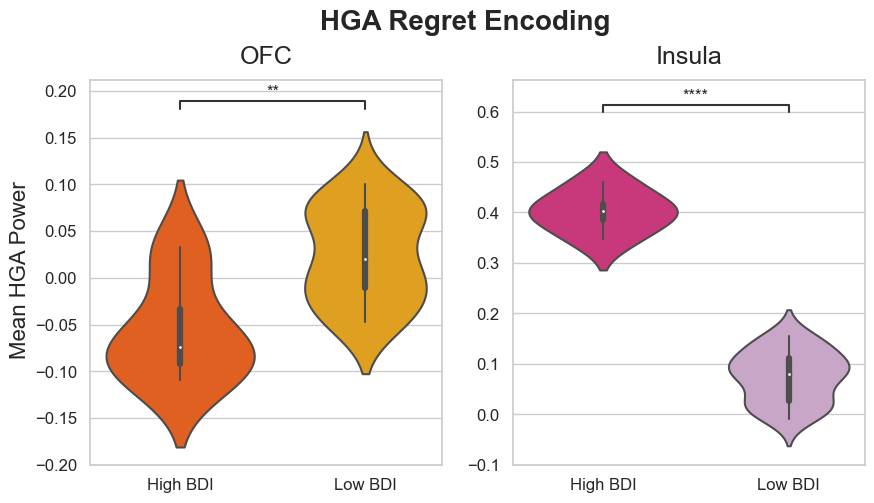

In [686]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5)) #,sharex=True,sharey=True
sns.set_theme(style="whitegrid",font='Arial') #palette='mako_r'
sns.violinplot(data=ofc_hga_df,ax=ax1,x='Depression',y='av_pow',palette='autumn')
sns.violinplot(data=ins_hga_df,ax=ax2,x='Depression',y='av_pow',palette='PuRd_r')

ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('OFC',weight='medium',fontsize=18,y=1.02)

ax2.set_ylim(-0.1,0.6)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Insula',weight='medium',fontsize=18,y=1.02)


fig.supylabel('Mean HGA Power',x=0.045,weight='medium',fontsize=16)
fig.suptitle('HGA Regret Encoding',y=1.02,weight='semibold',fontsize=20)

ofc_results = add_stat_annotation(ax1, data=ofc_hga_df, x='Depression',y='av_pow',
                                    box_pairs=[("High BDI", "Low BDI")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2,line_offset_to_box=0.2)
ins_results = add_stat_annotation(ax2, data=ins_hga_df, x='Depression',y='av_pow', 
                                    box_pairs=[("High BDI", "Low BDI")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2,line_offset_to_box=0.2)

ofc_results
ins_results

plt.savefig(f'{proj_dir}figs/depression_ephys_results/regret_hga.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   

#https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00
#https://seaborn.pydata.org/generated/seaborn.violinplot.html

#### Beta plot

In [363]:
regret_dep_plot_info_dict

{'HGA': ['ofc_regret_dep_plot', 'ins_regret_dep_plot'],
 'beta': ['ofc_regret_dep_plot', 'cing_regret_dep_plot'],
 'theta': ['cing_regret_dep_plot']}

In [485]:
ofc_regret_dep_plot['beta']['dep_df']['Depression'] = 'High BDI'
ofc_regret_dep_plot['beta']['nodep_df']['Depression'] = 'Low BDI'
ofc_beta_df = pd.concat((ofc_regret_dep_plot['beta']['dep_df'],ofc_regret_dep_plot['beta']['nodep_df']))
ofc_beta_df.head()

subj_id           elec       freq                             yba  \
60   MS027  lmolf5-lacas3  15.413871  [['Left frontal orbital 3 D']]   
61   MS027  lmolf5-lacas3  17.639931  [['Left frontal orbital 3 D']]   
71   MS027  lmolf7-lacas3  26.439449     [['Left pars orbitalis A']]   
0    MS002  lloif2-lmoif5  26.439449  [['Left frontal orbital 4 D']]   
20   MS016  lmolf1-lacas3  13.468727                   [['Unknown']]   

      av_pow  regret_coeff   p_value  r_squared freq_band  bdi Depression  
60 -0.089120      0.106920  0.021745   0.040461      beta   22   High BDI  
61 -0.095484      0.113026  0.018614   0.042500      beta   22   High BDI  
71  0.041828     -0.166860  0.030453   0.031254      beta   22   High BDI  
0   0.037201     -0.178107  0.005011   0.051991      beta   14    Low BDI  
20 -0.119970     -0.204653  0.007177   0.048140      beta   10    Low BDI

In [486]:
cing_regret_dep_plot['beta']['dep_df']['Depression'] = 'High BDI'
cing_regret_dep_plot['beta']['nodep_df']['Depression'] = 'Low BDI'
cing_beta_df = pd.concat((cing_regret_dep_plot['beta']['dep_df'],cing_regret_dep_plot['beta']['nodep_df']))
cing_beta_df.head()

subj_id           elec       freq                           yba    av_pow  \
35   MS017  lacas4-lmolf1  13.468727  [['Left cingulate gyrus F']]  0.018795   
36   MS017  lacas4-lmolf1  15.413871  [['Left cingulate gyrus F']]  0.003460   
44   MS017         lpcwr1  13.468727  [['Left cingulate gyrus P']] -0.048585   
45   MS017         lpcwr1  15.413871  [['Left cingulate gyrus P']] -0.041833   
46   MS017         lpcwr1  17.639931  [['Left cingulate gyrus P']] -0.051589   

    regret_coeff   p_value  r_squared freq_band  bdi Depression  
35     -0.269657  0.030830   0.031115      beta   26   High BDI  
36     -0.281374  0.019891   0.036088      beta   26   High BDI  
44     -0.182990  0.012065   0.042099      beta   26   High BDI  
45     -0.183591  0.005300   0.051682      beta   26   High BDI  
46     -0.151468  0.022314   0.035011      beta   26   High BDI

In [487]:
cing_beta_df #### STILL SIGNIFICANT WITHOUT LPCWR > ANTERIOR CINGULATE

subj_id           elec       freq                            yba    av_pow  \
35   MS017  lacas4-lmolf1  13.468727   [['Left cingulate gyrus F']]  0.018795   
36   MS017  lacas4-lmolf1  15.413871   [['Left cingulate gyrus F']]  0.003460   
44   MS017         lpcwr1  13.468727   [['Left cingulate gyrus P']] -0.048585   
45   MS017         lpcwr1  15.413871   [['Left cingulate gyrus P']] -0.041833   
46   MS017         lpcwr1  17.639931   [['Left cingulate gyrus P']] -0.051589   
57   MS027  racas2-racas4  20.187478  [['Right cingulate gyrus C']] -0.056354   
58   MS029  lacas2-lmolf2  17.639931   [['Left cingulate gyrus D']]  0.098745   
59   MS029  lacas2-lmolf2  20.187478   [['Left cingulate gyrus D']]  0.061759   
11   MS002  lacas3-lmoif7  13.468727   [['Left cingulate gyrus F']] -0.096379   
13   MS003  racas2-rmolf5  17.639931  [['Right cingulate gyrus D']] -0.105616   
14   MS003  racas2-rmolf5  20.187478  [['Right cingulate gyrus D']] -0.091226   
15   MS003  racas2-rmolf5  23.102939  [['Right cingulate gyrus D']] -0.097866   
16   MS003  racas2-rmolf5  26.439449  [['Right cingulate gyrus D']] -0.089064   
18   MS003  racas3-rmolf5  23.102939  [['Right cingulate gyrus E']] -0.125172   
19   MS003  racas3-rmolf5  26.439449  [['Right cingulate gyrus E']] -0.113046   
54   MS022  lacas1-lacas5  13.468727   [['Left cingulate gyrus D']]  0.003454   
55   MS022  lacas1-lacas5  15.413871   [['Left cingulate gyrus D']] -0.003248   

    regret_coeff   p_value  r_squared freq_band  bdi Depression  
35     -0.269657  0.030830   0.031115      beta   26   High BDI  
36     -0.281374  0.019891   0.036088      beta   26   High BDI  
44     -0.182990  0.012065   0.042099      beta   26   High BDI  
45     -0.183591  0.005300   0.051682      beta   26   High BDI  
46     -0.151468  0.022314   0.035011      beta   26   High BDI  
57      0.068564  0.044309   0.033556      beta   22   High BDI  
58     -0.207187  0.020297   0.036097      beta   32   High BDI  
59     -0.202149  0.022282   0.035027      beta   32   High BDI  
11      0.191024  0.015627   0.038847      beta   14    Low BDI  
13      0.191133  0.025134   0.033426      beta    8    Low BDI  
14      0.243704  0.012056   0.041829      beta    8    Low BDI  
15      0.285477  0.007132   0.047895      beta    8    Low BDI  
16      0.283811  0.006306   0.049322      beta    8    Low BDI  
18      0.226704  0.024569   0.033909      beta    8    Low BDI  
19      0.250940  0.011944   0.042216      beta    8    Low BDI  
54     -0.084833  0.019605   0.036253      beta   10    Low BDI  
55     -0.084447  0.025960   0.033059      beta   10    Low BDI

In [488]:
list(np.unique(cing_beta_df.yba))

[array(["['Left cingulate gyrus D']"], dtype=object),
 array(["['Left cingulate gyrus F']"], dtype=object),
 array(["['Left cingulate gyrus P']"], dtype=object),
 array(["['Right cingulate gyrus C']"], dtype=object),
 array(["['Right cingulate gyrus D']"], dtype=object),
 array(["['Right cingulate gyrus E']"], dtype=object)]

In [489]:
cing_beta_df = cing_beta_df[cing_beta_df.elec !='lpcwr1']

In [490]:
cing_beta_df

subj_id           elec       freq                            yba    av_pow  \
35   MS017  lacas4-lmolf1  13.468727   [['Left cingulate gyrus F']]  0.018795   
36   MS017  lacas4-lmolf1  15.413871   [['Left cingulate gyrus F']]  0.003460   
57   MS027  racas2-racas4  20.187478  [['Right cingulate gyrus C']] -0.056354   
58   MS029  lacas2-lmolf2  17.639931   [['Left cingulate gyrus D']]  0.098745   
59   MS029  lacas2-lmolf2  20.187478   [['Left cingulate gyrus D']]  0.061759   
11   MS002  lacas3-lmoif7  13.468727   [['Left cingulate gyrus F']] -0.096379   
13   MS003  racas2-rmolf5  17.639931  [['Right cingulate gyrus D']] -0.105616   
14   MS003  racas2-rmolf5  20.187478  [['Right cingulate gyrus D']] -0.091226   
15   MS003  racas2-rmolf5  23.102939  [['Right cingulate gyrus D']] -0.097866   
16   MS003  racas2-rmolf5  26.439449  [['Right cingulate gyrus D']] -0.089064   
18   MS003  racas3-rmolf5  23.102939  [['Right cingulate gyrus E']] -0.125172   
19   MS003  racas3-rmolf5  26.439449  [['Right cingulate gyrus E']] -0.113046   
54   MS022  lacas1-lacas5  13.468727   [['Left cingulate gyrus D']]  0.003454   
55   MS022  lacas1-lacas5  15.413871   [['Left cingulate gyrus D']] -0.003248   

    regret_coeff   p_value  r_squared freq_band  bdi Depression  
35     -0.269657  0.030830   0.031115      beta   26   High BDI  
36     -0.281374  0.019891   0.036088      beta   26   High BDI  
57      0.068564  0.044309   0.033556      beta   22   High BDI  
58     -0.207187  0.020297   0.036097      beta   32   High BDI  
59     -0.202149  0.022282   0.035027      beta   32   High BDI  
11      0.191024  0.015627   0.038847      beta   14    Low BDI  
13      0.191133  0.025134   0.033426      beta    8    Low BDI  
14      0.243704  0.012056   0.041829      beta    8    Low BDI  
15      0.285477  0.007132   0.047895      beta    8    Low BDI  
16      0.283811  0.006306   0.049322      beta    8    Low BDI  
18      0.226704  0.024569   0.033909      beta    8    Low BDI  
19      0.250940  0.011944   0.042216      beta    8    Low BDI  
54     -0.084833  0.019605   0.036253      beta   10    Low BDI  
55     -0.084447  0.025960   0.033059      beta   10    Low BDI

In [491]:
ofc_beta_df

subj_id           elec       freq                              yba  \
60   MS027  lmolf5-lacas3  15.413871   [['Left frontal orbital 3 D']]   
61   MS027  lmolf5-lacas3  17.639931   [['Left frontal orbital 3 D']]   
71   MS027  lmolf7-lacas3  26.439449      [['Left pars orbitalis A']]   
0    MS002  lloif2-lmoif5  26.439449   [['Left frontal orbital 4 D']]   
20   MS016  lmolf1-lacas3  13.468727                    [['Unknown']]   
47   MS016  lmolf5-lacas3  13.468727   [['Left frontal orbital 3 D']]   
53   MS026  rmolf1-racas3  26.439449  [['Right frontal orbital 4 A']]   

      av_pow  regret_coeff   p_value  r_squared freq_band  bdi Depression  
60 -0.089120      0.106920  0.021745   0.040461      beta   22   High BDI  
61 -0.095484      0.113026  0.018614   0.042500      beta   22   High BDI  
71  0.041828     -0.166860  0.030453   0.031254      beta   22   High BDI  
0   0.037201     -0.178107  0.005011   0.051991      beta   14    Low BDI  
20 -0.119970     -0.204653  0.007177   0.048140      beta   10    Low BDI  
47 -0.016845     -0.103767  0.024399   0.033762      beta   10    Low BDI  
53  0.008047     -0.290777  0.007607   0.047461      beta    9    Low BDI

In [608]:
ofc_regret_dep_beta2 = ofc_regret_dep_beta[ofc_regret_dep_beta.elec !="lmolf7-lacas3"]

In [612]:
ofc_pvalue = [float(stats.ttest_ind(ofc_regret_dep_beta2.regret_coeff, ofc_regret_nodep_beta.regret_coeff, equal_var=False).pvalue)]

In [496]:
ofc_beta_df2 = 	ofc_beta_df[(ofc_beta_df.elec !="lmolf7-lacas3")] #remove non frontal orbital gyrus elec

In [622]:
cing_pvalue = [float(cing_regret_dep_plot['beta']['p'])]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: Custom statistical test, P_val:4.103e-03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: Custom statistical test, P_val:6.428e-05


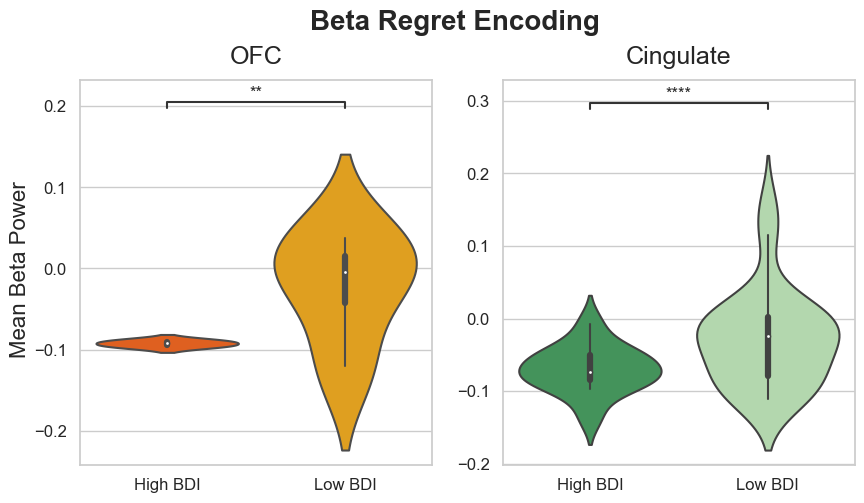

In [694]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5)) 
sns.set_theme(style="whitegrid",font='Arial') 
sns.violinplot(data=ofc_beta_df2,ax=ax1,x='Depression',y='av_pow',palette='autumn',scale='width')
sns.violinplot(data=cing_beta_df,ax=ax2,x='Depression',y='av_pow',palette='Greens_r',scale='width')


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('OFC',weight='medium',fontsize=18,y=1.02)

ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Cingulate',weight='medium',fontsize=18,y=1.02)


fig.supylabel('Mean Beta Power',x=0.055,weight='medium',fontsize=16)
fig.suptitle('Beta Regret Encoding',y=1.02,weight='semibold',fontsize=20)


ofc_results = add_stat_annotation(ax1, data=ofc_beta_df2, x='Depression',y='av_pow',
                                    box_pairs=[("High BDI", "Low BDI")],
                                   text_format='star',
                                   perform_stat_test=False, pvalues=ofc_pvalue, 
                                   loc='inside', verbose=2,line_offset_to_box=0.4)

acc_results = add_stat_annotation(ax2, data=cing_beta_df, x='Depression',y='av_pow', 
                                    box_pairs=[("High BDI", "Low BDI")],
                                   text_format='star',
                                   perform_stat_test=False, pvalues=cing_pvalue,
                                   loc='inside', verbose=2,line_offset_to_box=0.3)

ofc_results
acc_results

plt.savefig(f'{proj_dir}figs/depression_ephys_results/regret_beta.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   

#### Theta Plot

In [513]:
cing_regret_dep_plot['theta']['dep_df']['Depression'] = 'High BDI'
cing_regret_dep_plot['theta']['nodep_df']['Depression'] = 'Low BDI'
cing_theta_df = pd.concat((cing_regret_dep_plot['theta']['dep_df'],cing_regret_dep_plot['theta']['nodep_df']))
cing_theta_df

subj_id           elec      freq                            yba    av_pow  \
39   MS017         lpcwr1  5.238782   [['Left cingulate gyrus P']] -0.113912   
40   MS017         lpcwr1  5.995363   [['Left cingulate gyrus P']] -0.084487   
41   MS017         lpcwr1  6.861210   [['Left cingulate gyrus P']] -0.060147   
42   MS017         lpcwr1  7.852101   [['Left cingulate gyrus P']] -0.059163   
65   MS029  rmcms2-rmcms4  4.577677  [['Right cingulate gyrus I']] -0.105499   
66   MS029  rmcms2-rmcms4  5.238782  [['Right cingulate gyrus I']] -0.099426   
0    DA023      lac2-lmc1  4.000000   [['Left cingulate gyrus H']] -0.002221   
1    DA023      lac2-lmc1  4.577677   [['Left cingulate gyrus H']] -0.002038   
2    DA023      lac2-lmc1  5.238782   [['Left cingulate gyrus H']]  0.006473   
3    DA023      lac2-lmc1  5.995363   [['Left cingulate gyrus H']]  0.019949   
4    DA023      lac2-lmc1  6.861210   [['Left cingulate gyrus H']]  0.011335   
7    MS002  lacas1-lmoif6  4.000000   [['Left cingulate gyrus D']]  0.118700   
8    MS002  lacas1-lmoif6  4.577677   [['Left cingulate gyrus D']]  0.104207   
9    MS002  lacas1-lmoif6  5.238782   [['Left cingulate gyrus D']]  0.047072   
12   MS002  lacas4-lmoif5  4.000000   [['Left cingulate gyrus F']]  0.095844   
49   MS019  rmcms1-rpioc3  5.995363  [['Right cingulate gyrus K']]  0.020323   
50   MS019  rmcms1-rpioc3  6.861210  [['Right cingulate gyrus K']]  0.017102   

    regret_coeff   p_value  r_squared freq_band  bdi Depression  
39     -0.247368  0.013847   0.040505     theta   26   High BDI  
40     -0.258116  0.016570   0.038432     theta   26   High BDI  
41     -0.251268  0.019800   0.036382     theta   26   High BDI  
42     -0.246730  0.016460   0.038509     theta   26   High BDI  
65     -0.182402  0.015941   0.038620     theta   32   High BDI  
66     -0.211184  0.021853   0.035015     theta   32   High BDI  
0      -0.333100  0.027909   0.032239     theta   14    Low BDI  
1      -0.411605  0.004737   0.052646     theta   14    Low BDI  
2      -0.464535  0.000492   0.079051     theta   14    Low BDI  
3      -0.421934  0.001065   0.070045     theta   14    Low BDI  
4      -0.301323  0.016047   0.038544     theta   14    Low BDI  
7      -0.345695  0.005215   0.051527     theta   14    Low BDI  
8      -0.400624  0.002247   0.061334     theta   14    Low BDI  
9      -0.304756  0.013033   0.040932     theta   14    Low BDI  
12     -0.246842  0.033545   0.030164     theta   14    Low BDI  
49     -0.125840  0.029796   0.031500     theta   12    Low BDI  
50     -0.135711  0.027798   0.032284     theta   12    Low BDI

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.616e-04 U_stat=0.000e+00


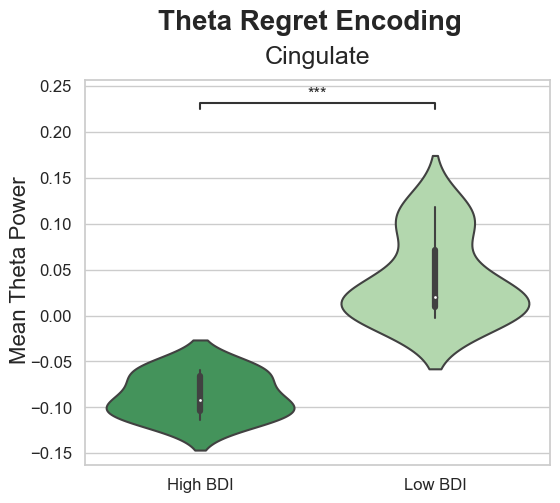

In [693]:
fig,(ax1) = plt.subplots(1,1,figsize=(6,5)) #,sharex=True,sharey=True
sns.set_theme(style="whitegrid",font='Arial') 
sns.violinplot(data=cing_theta_df,ax=ax1,x='Depression',y='av_pow',palette='Greens_r',scale='width')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Cingulate',weight='medium',fontsize=18,y=1.02)


fig.supylabel('Mean Theta Power',x=0,weight='medium',fontsize=16)
fig.suptitle('Theta Regret Encoding',y=1.02,weight='semibold',fontsize=20)

cing_results = add_stat_annotation(ax1, data=cing_theta_df, x='Depression',y='av_pow', 
                                    box_pairs=[("High BDI", "Low BDI")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2,line_offset_to_box=0.3)

cing_results

plt.savefig(f'{proj_dir}figs/depression_ephys_results/regret_theta.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   

## Relief Plot

In [285]:
print(ofc_relief_dep_plot.keys())
print(ins_relief_dep_plot.keys())
print(cing_relief_dep_plot.keys())
print(amy_relief_dep_plot.keys())

dict_keys(['gamma', 'beta'])
dict_keys(['gamma', 'beta'])
dict_keys(['gamma', 'beta'])
dict_keys(['gamma'])


In [290]:
relief_dep_plot_freqs = ['gamma','beta']
relief_dep_plot_info_dict = {}
relief_dep_plot_info_dict['gamma'] = ['ofc_relief_dep_plot','ins_relief_dep_plot','cing_relief_dep_plot','amy_relief_dep_plot']
relief_dep_plot_info_dict['beta'] = ['ofc_relief_dep_plot','ins_relief_dep_plot','cing_relief_dep_plot']


In [291]:
relief_dep_plot_info_dict

{'gamma': ['ofc_relief_dep_plot',
  'ins_relief_dep_plot',
  'cing_relief_dep_plot',
  'amy_relief_dep_plot'],
 'beta': ['ofc_relief_dep_plot',
  'ins_relief_dep_plot',
  'cing_relief_dep_plot']}

#### Gamma

In [516]:
ofc_relief_dep_plot['gamma']['dep_df']['Depression'] = 'High BDI'
ofc_relief_dep_plot['gamma']['nodep_df']['Depression'] = 'Low BDI'
ofc_gamma_df = pd.concat((ofc_relief_dep_plot['gamma']['dep_df'],ofc_relief_dep_plot['gamma']['nodep_df']))
ofc_gamma_df.head()


subj_id           elec       freq                             yba  \
55   MS027  lmolf6-lacas3  30.257816  [['Left frontal orbital 3 D']]   
56   MS027  lmolf6-lacas3  34.627629  [['Left frontal orbital 3 D']]   
57   MS027  lmolf6-lacas3  39.628527  [['Left frontal orbital 3 D']]   
58   MS027  lmolf6-lacas3  45.351651  [['Left frontal orbital 3 D']]   
59   MS027  lmolf6-lacas3  51.901304  [['Left frontal orbital 3 D']]   

      av_pow  relief_coeff   p_value  r_squared freq_band  bdi Depression  
55  0.066850     -0.245271  0.010841   0.043631     gamma   22   High BDI  
56  0.060094     -0.300409  0.001224   0.069323     gamma   22   High BDI  
57  0.057893     -0.322711  0.000313   0.085420     gamma   22   High BDI  
58  0.067027     -0.312674  0.000594   0.077863     gamma   22   High BDI  
59  0.075997     -0.272581  0.004248   0.054633     gamma   22   High BDI

In [517]:
ins_relief_dep_plot['gamma']['dep_df']['Depression'] = 'High BDI'
ins_relief_dep_plot['gamma']['nodep_df']['Depression'] = 'Low BDI'
ins_gamma_df = pd.concat((ins_relief_dep_plot['gamma']['dep_df'],ins_relief_dep_plot['gamma']['nodep_df']))
ins_gamma_df.head()

subj_id           elec       freq            yba    av_pow  relief_coeff  \
261   MS017  lalps1-lalps6  30.257816  [['Unknown']]  0.121598      0.266060   
262   MS017  lalps1-lalps6  34.627629  [['Unknown']]  0.134516      0.265323   
263   MS017  lalps1-lalps6  39.628527  [['Unknown']]  0.148623      0.246153   
264   MS017  lalps1-lalps6  45.351651  [['Unknown']]  0.163117      0.222666   
265   MS017  lalps1-lalps6  51.901304  [['Unknown']]  0.170605      0.199195   

          p_value  r_squared freq_band  bdi Depression  
261  1.993226e-09   0.217750     gamma   26   High BDI  
262  1.394542e-09   0.221458     gamma   26   High BDI  
263  3.203282e-08   0.188382     gamma   26   High BDI  
264  9.306139e-07   0.151486     gamma   26   High BDI  
265  1.051255e-05   0.124120     gamma   26   High BDI

In [520]:
cing_relief_dep_plot['gamma']['dep_df']['Depression'] = 'High BDI'
cing_relief_dep_plot['gamma']['nodep_df']['Depression'] = 'Low BDI'
cing_gamma_df = pd.concat((cing_relief_dep_plot['gamma']['dep_df'],cing_relief_dep_plot['gamma']['nodep_df']))
cing_gamma_df

subj_id             elec       freq                            yba  \
110   MS027    lmcms2-lmcms5  30.257816   [['Left cingulate gyrus I']]   
111   MS027    lmcms2-lmcms5  34.627629   [['Left cingulate gyrus I']]   
117   MS029    lacas2-lmolf2  34.627629   [['Left cingulate gyrus D']]   
118   MS029    lacas2-lmolf2  39.628527   [['Left cingulate gyrus D']]   
119   MS029    lacas2-lmolf2  45.351651   [['Left cingulate gyrus D']]   
120   MS029    lmcms3-lmcms5  34.627629   [['Left cingulate gyrus J']]   
121   MS029    lmcms3-lmcms5  39.628527   [['Left cingulate gyrus J']]   
19    MS002    racas2-raims7  30.257816  [['Right cingulate gyrus D']]   
20    MS002    racas2-raims7  34.627629  [['Right cingulate gyrus D']]   
21    MS002    racas2-raims7  39.628527  [['Right cingulate gyrus D']]   
22    MS002    racas2-raims7  45.351651  [['Right cingulate gyrus D']]   
23    MS002    racas2-raims7  51.901304  [['Right cingulate gyrus D']]   
24    MS002    racas2-raims7  59.396854  [['Right cingulate gyrus D']]   
29    MS002    racas3-raims7  30.257816                  [['Unknown']]   
30    MS002    racas3-raims7  34.627629                  [['Unknown']]   
31    MS002    racas3-raims7  39.628527                  [['Unknown']]   
32    MS002    racas3-raims7  45.351651                  [['Unknown']]   
33    MS002    racas3-raims7  51.901304                  [['Unknown']]   
34    MS002    racas3-raims7  59.396854                  [['Unknown']]   
41    MS003    racas2-rmolf5  30.257816  [['Right cingulate gyrus D']]   
46    MS003    racas5-rmolf2  30.257816  [['Right cingulate gyrus F']]   
47    MS003    racas5-rmolf2  34.627629  [['Right cingulate gyrus F']]   
48    MS003    racas5-rmolf2  39.628527  [['Right cingulate gyrus F']]   
49    MS003    racas5-rmolf2  45.351651  [['Right cingulate gyrus F']]   
50    MS003    racas5-rmolf2  51.901304  [['Right cingulate gyrus F']]   
51    MS003    racas5-rmolf2  59.396854  [['Right cingulate gyrus F']]   
52    MS003    racas5-rmolf2  67.974906  [['Right cingulate gyrus F']]   
59    MS003    rmcms1-rmcms5  30.257816  [['Right cingulate gyrus I']]   
60    MS003    rmcms1-rmcms5  34.627629  [['Right cingulate gyrus I']]   
61    MS003    rmcms1-rmcms5  39.628527  [['Right cingulate gyrus I']]   
62    MS003    rmcms1-rmcms5  45.351651  [['Right cingulate gyrus I']]   
63    MS003    rmcms1-rmcms5  51.901304  [['Right cingulate gyrus I']]   
71    MS016    lacas1-lacas3  30.257816   [['Left cingulate gyrus D']]   
72    MS016    lmcms3-lmcms2  51.901304   [['Left cingulate gyrus J']]   
73    MS016    lmcms3-lmcms2  59.396854   [['Left cingulate gyrus J']]   
74    MS016    lmcms3-lmcms2  67.974906   [['Left cingulate gyrus J']]   
125   MS030  lacas1-lmoporb3  30.257816   [['Left cingulate gyrus C']]   
140   MS030  lacas6-lmoporb3  30.257816   [['Left cingulate gyrus F']]   
141   MS030  lacas6-lmoporb3  34.627629   [['Left cingulate gyrus F']]   
142   MS030  lacas6-lmoporb3  39.628527   [['Left cingulate gyrus F']]   
143   MS030  lacas6-lmoporb3  45.351651   [['Left cingulate gyrus F']]   
144   MS030  lacas6-lmoporb3  51.901304   [['Left cingulate gyrus F']]   
145   MS030  lacas6-lmoporb3  59.396854   [['Left cingulate gyrus F']]   
146   MS030  lacas6-lmoporb3  67.974906   [['Left cingulate gyrus F']]   
156   MS030    lmcms2-lcmmf8  30.257816   [['Left cingulate gyrus I']]   
157   MS030    lmcms2-lcmmf8  34.627629   [['Left cingulate gyrus I']]   
158   MS030    lmcms2-lcmmf8  39.628527   [['Left cingulate gyrus I']]   
159   MS030    lmcms2-lcmmf8  45.351651   [['Left cingulate gyrus I']]   
160   MS030    lmcms3-lcmmf9  67.974906   [['Left cingulate gyrus I']]   

       av_pow  relief_coeff   p_value  r_squared freq_band  bdi Depression  
110 -0.084212     -0.079475  0.019967   0.038071     gamma   22   High BDI  
111 -0.081147     -0.095093  0.022362   0.036709     gamma   22   High BDI  
117  0.008763     -0.200346  0.026150   0.033198     gamma   32   High B

In [519]:
amy_relief_dep_plot['gamma']['dep_df']['Depression'] = 'High BDI'
amy_relief_dep_plot['gamma']['nodep_df']['Depression'] = 'Low BDI'
amy_gamma_df = pd.concat((amy_relief_dep_plot['gamma']['dep_df'],amy_relief_dep_plot['gamma']['nodep_df']))
amy_gamma_df.head()

subj_id           elec       freq                            yba    av_pow  \
30   MS017  laglt1-ltplt4  51.901304   [['Left amygdala superior']] -0.296992   
31   MS017  laglt1-ltplt4  59.396854   [['Left amygdala superior']] -0.281330   
0    DA023      lam4-lam6  30.257816  [['Left amygdala superior ']] -0.012705   
1    DA023      lam4-lam6  34.627629  [['Left amygdala superior ']] -0.002168   
2    DA023      lam4-lam6  39.628527  [['Left amygdala superior ']]  0.018012   

    relief_coeff   p_value  r_squared freq_band  bdi Depression  
30      0.175637  0.033888   0.030049     gamma   26   High BDI  
31      0.178488  0.032294   0.030592     gamma   26   High BDI  
0      -0.175062  0.014151   0.039986     gamma   14    Low BDI  
1      -0.216421  0.002666   0.059337     gamma   14    Low BDI  
2      -0.224480  0.003275   0.056941     gamma   14    Low BDI

In [528]:
cing_relief_dep_plot['gamma']['p']

0.007606188611564797

In [538]:
str(cing_relief_dep_plot['gamma']['p'])

'0.007606188611564797'

In [606]:
ofc_pval = [float(ofc_relief_dep_plot['gamma']['p'])]
cing_pval = [float(cing_relief_dep_plot['gamma']['p'])]

In [605]:
cing_pval

[0]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: Custom statistical test, P_val:3.058e-03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: t-test independent samples with Bonferroni correction, P_val=3.004e-03 stat=3.037e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: Custom statistical test, P_val:7.606e-03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: t-test independent samples with Bonferroni correction, P_val=1.672e-09 stat=-1.073e+

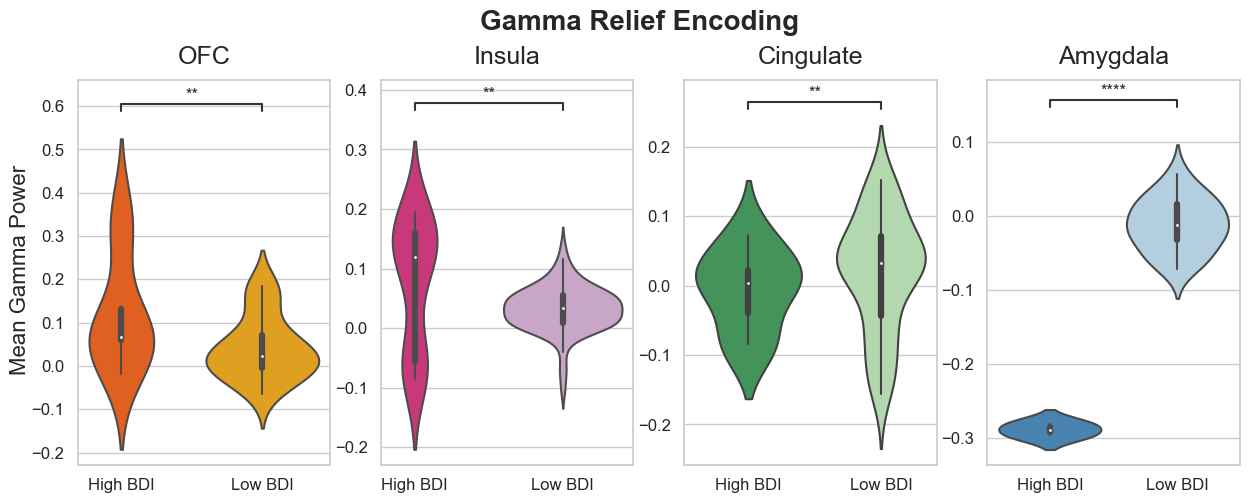

In [691]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5)) #,sharex=True,sharey=True
sns.set_theme(style="whitegrid",font='Arial') 
sns.violinplot(data=ofc_gamma_df,ax=ax1,x='Depression',y='av_pow',palette='autumn')
sns.violinplot(data=ins_gamma_df,ax=ax2,x='Depression',y='av_pow',palette='PuRd_r')
sns.violinplot(data=cing_gamma_df,ax=ax3,x='Depression',y='av_pow',palette='Greens_r')
sns.violinplot(data=amy_gamma_df,ax=ax4,x='Depression',y='av_pow',palette='Blues_r',scale='width')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('OFC',weight='medium',fontsize=18,y=1.02)

#ax2.set_ylim(-0.1,0.6)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Insula',weight='medium',fontsize=18,y=1.02)

#ax2.set_ylim(-0.1,0.6)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Cingulate',weight='medium',fontsize=18,y=1.02)

#ax2.set_ylim(-0.1,0.6)
ax4.set_ylabel(None)
ax4.set_xlabel(None)
ax4.tick_params(labelsize=12)
ax4.set_title('Amygdala',weight='medium',fontsize=18,y=1.02)

fig.supylabel('Mean Gamma Power',x=0.08,weight='medium',fontsize=16)
fig.suptitle('Gamma Relief Encoding',y=1.02,weight='semibold',fontsize=20)

ofc_results = add_stat_annotation(ax1, data=ofc_gamma_df, x='Depression',y='av_pow',
                                    box_pairs=[("High BDI", "Low BDI")],
                                   text_format='star',
                                   perform_stat_test=False, pvalues=ofc_pval, 
                                   loc='inside', verbose=2,line_offset_to_box=0.3)
ins_results = add_stat_annotation(ax2, data=ins_gamma_df, x='Depression',y='av_pow', 
                                    box_pairs=[("High BDI", "Low BDI")],
                                   test='t-test_ind', text_format='star',
                                   loc='inside', verbose=2,line_offset_to_box=0.3)

cing_results = add_stat_annotation(ax3, data=cing_gamma_df, x='Depression',y='av_pow', 
                                    box_pairs=[("High BDI", "Low BDI")],
                                    text_format='star',
                                   perform_stat_test=False, pvalues=cing_pval, 
                                   loc='inside', verbose=2,line_offset_to_box=0.2)

amy_results = add_stat_annotation(ax4, data=amy_gamma_df, x='Depression',y='av_pow', 
                                    box_pairs=[("High BDI", "Low BDI")],
                                   test='t-test_ind', text_format='star',
                                   loc='inside', verbose=2,line_offset_to_box=0.2)

ofc_results
ins_results
cing_results
amy_results

plt.savefig(f'{proj_dir}figs/depression_ephys_results/relief_gamma.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   

#### Beta

In [582]:
ofc_relief_dep_plot['beta']['dep_df']['Depression'] = 'High BDI'
ofc_relief_dep_plot['beta']['nodep_df']['Depression'] = 'Low BDI'
ofc_beta_df = pd.concat((ofc_relief_dep_plot['beta']['dep_df'],ofc_relief_dep_plot['beta']['nodep_df']))
ofc_beta_df

subj_id           elec       freq                              yba  \
60   MS027  rmolf5-rmolf7  20.187478  [['Right frontal orbital 3 D']]   
61   MS027  rmolf5-rmolf7  23.102939  [['Right frontal orbital 3 D']]   
62   MS027  rmolf5-rmolf7  26.439449  [['Right frontal orbital 3 D']]   
71   MS029  lmolf4-lacas4  13.468727   [['Left frontal orbital 3 C']]   
72   MS029  lmolf4-lacas4  15.413871   [['Left frontal orbital 3 C']]   
73   MS029  lmolf4-lacas4  17.639931   [['Left frontal orbital 3 C']]   
0    MS002  lloif2-lmoif5  15.413871   [['Left frontal orbital 4 D']]   
1    MS002  lloif2-lmoif5  17.639931   [['Left frontal orbital 4 D']]   
2    MS002  lloif2-lmoif5  20.187478   [['Left frontal orbital 4 D']]   
20   MS003  lmolf5-lmolf6  20.187478      [['Left pars orbitalis B']]   
21   MS003  lmolf5-lmolf6  23.102939      [['Left pars orbitalis B']]   
22   MS003  rmolf3-rmolf2  26.439449  [['Right frontal orbital 4 C']]   
44   MS016  lmolf3-lacas2  15.413871   [['Left frontal orbital 3 C']]   
45   MS016  lmolf3-lacas2  17.639931   [['Left frontal orbital 3 C']]   
46   MS016  lmolf3-lacas2  20.187478   [['Left frontal orbital 3 C']]   
47   MS016  lmolf3-lacas2  23.102939   [['Left frontal orbital 3 C']]   
48   MS016  lmolf3-lacas2  26.439449   [['Left frontal orbital 3 C']]   
50   MS016  lmolf5-lacas3  17.639931   [['Left frontal orbital 3 D']]   
51   MS016  lmolf5-lacas3  20.187478   [['Left frontal orbital 3 D']]   
52   MS016  lmolf5-lacas3  23.102939   [['Left frontal orbital 3 D']]   
53   MS016  lmolf5-lacas3  26.439449   [['Left frontal orbital 3 D']]   

      av_pow  relief_coeff       p_value  r_squared freq_band  bdi Depression  
60 -0.192470     -0.128667  4.520110e-03   0.053901      beta   22   High BDI  
61 -0.148205     -0.185355  3.192375e-03   0.058002      beta   22   High BDI  
62 -0.057344     -0.186838  2.500547e-02   0.033936      beta   22   High BDI  
71 -0.010491      0.286362  6.944202e-04   0.075028      beta   32   High BDI  
72  0.006843      0.243219  2.253485e-03   0.061298      beta   32   High BDI  
73  0.022240      0.168229  2.442116e-02   0.033752      beta   32   High BDI  
0  -0.000621      0.139470  1.412178e-02   0.040010      beta   14    Low BDI  
1   0.027160      0.170072  6.494395e-03   0.048981      beta   14    Low BDI  
2   0.038584      0.150583  1.552892e-02   0.038920      beta   14    Low BDI  
20 -0.062271      0.145997  3.305477e-02   0.030330      beta    8    Low BDI  
21 -0.052509      0.166094  2.620009e-02   0.032955      beta    8    Low BDI  
22 -0.061263      0.218607  1.686301e-02   0.037975      beta    8    Low BDI  
44 -0.023550      0.162239  1.101983e-03   0.070566      beta   10    Low BDI  
45 -0.020895      0.224616  4.049873e-06   0.135825      beta   10    Low BDI  
46 -0.014804      0.283650  8.508588e-08   0.178930      beta   10    Low BDI  
47 -0.002495      0.327544  1.209302e-07   0.175081      beta   10    Low BDI  
48  0.000561      0.277354  1.397169e-04   0.094886      beta   10    Low BDI  
50 -0.023093      0.115133  1.545272e-02   0.038976      beta   10    Low BDI  
51 -0.017823      0.177968  4.592779e-04   0.079844      beta   10    Low BDI  
52 -0.005940      0.165709  6.933234e-04   0.075046      beta   10    Low BDI  
53 -0.001531      0.094989  2.600585e-02   0.033039      beta   10    Low BDI

In [583]:
ins_relief_dep_plot['beta']['dep_df']['Depression'] = 'High BDI'
ins_relief_dep_plot['beta']['nodep_df']['Depression'] = 'Low BDI'
ins_beta_df = pd.concat((ins_relief_dep_plot['beta']['dep_df'],ins_relief_dep_plot['beta']['nodep_df']))
ins_beta_df

subj_id            elec       freq  \
259   MS017   lalps1-lalps6  23.102939   
260   MS017   lalps1-lalps6  26.439449   
270   MS017   lalps2-lalps6  26.439449   
277   MS027  raisp7-raisp11  13.468727   
278   MS027  raisp7-raisp11  15.413871   
..      ...             ...        ...   
256   MS016   laimm4-lagit4  20.187478   
257   MS016   laimm4-lagit4  23.102939   
258   MS016   laimm4-lagit4  26.439449   
298   MS030   lpipo2-lpipo1  20.187478   
307   MS030   lsipt2-lsipt3  23.102939   

                                            yba    av_pow  relief_coeff  \
259                               [['Unknown']]  0.095257      0.179691   
260                               [['Unknown']]  0.108028      0.236233   
270   [['Left anterior short insular gyrus A']]  0.069606      0.174017   
277   [['Right anterior long insular gyrus A']] -0.238925     -0.184714   
278   [['Right anterior long insular gyrus A']] -0.186737     -0.216799   
..                                          ...       ...           ...   
256  [['Left posterior short insular gyrus A']]  0.002410      0.130361   
257  [['Left posterior short insular gyrus A']]  0.003721      0.088401   
258  [['Left posterior short insular gyrus A']] -0.002031      0.064075   
298    [['Left anterior long insular gyrus A']] -0.012214      0.202575   
307     [['Left middle short insular gyrus A']] -0.027874      0.129353   

          p_value  r_squared freq_band  bdi Depression  
259  3.384961e-04   0.083939      beta   26   High BDI  
260  3.295000e-07   0.163001      beta   26   High BDI  
270  1.360299e-03   0.067186      beta   26   High BDI  
277  9.996686e-03   0.044580      beta   22   High BDI  
278  9.212786e-03   0.045535      beta   22   High BDI  
..            ...        ...       ...  ...        ...  
256  1.592675e-04   0.092744      beta   10    Low BDI  
257  4.013270e-03   0.054936      beta   10    Low BDI  
258  2.905078e-02   0.031999      beta   10    Low BDI  
298  2.000117e-02   0.036025      beta   19    Low BDI  
307  1.357491e-02   0.041286      beta   19    Low BDI  

[102 rows x 11 columns]

In [584]:
cing_relief_dep_plot['beta']['dep_df']['Depression'] = 'High BDI'
cing_relief_dep_plot['beta']['nodep_df']['Depression'] = 'Low BDI'
cing_beta_df = pd.concat((cing_relief_dep_plot['beta']['dep_df'],cing_relief_dep_plot['beta']['nodep_df']))
cing_beta_df


subj_id             elec       freq                            yba  \
87    MS017           lpcwr1  13.468727   [['Left cingulate gyrus P']]   
88    MS017           lpcwr1  15.413871   [['Left cingulate gyrus P']]   
89    MS017           lpcwr1  17.639931   [['Left cingulate gyrus P']]   
90    MS017           lpcwr1  20.187478   [['Left cingulate gyrus P']]   
91    MS017           lpcwr1  23.102939   [['Left cingulate gyrus P']]   
92    MS017           lpcwr1  26.439449   [['Left cingulate gyrus P']]   
105   MS027    lmcms2-lmcms5  15.413871   [['Left cingulate gyrus I']]   
106   MS027    lmcms2-lmcms5  17.639931   [['Left cingulate gyrus I']]   
107   MS027    lmcms2-lmcms5  20.187478   [['Left cingulate gyrus I']]   
108   MS027    lmcms2-lmcms5  23.102939   [['Left cingulate gyrus I']]   
109   MS027    lmcms2-lmcms5  26.439449   [['Left cingulate gyrus I']]   
123   MS029    rmcms2-rmcms4  13.468727  [['Right cingulate gyrus I']]   
13    MS002    lacas3-lmoif7  15.413871   [['Left cingulate gyrus F']]   
14    MS002    lacas3-lmoif7  17.639931   [['Left cingulate gyrus F']]   
15    MS002    lacas3-lmoif7  20.187478   [['Left cingulate gyrus F']]   
28    MS002    racas3-raims7  26.439449                  [['Unknown']]   
38    MS003    racas2-rmolf5  20.187478  [['Right cingulate gyrus D']]   
39    MS003    racas2-rmolf5  23.102939  [['Right cingulate gyrus D']]   
40    MS003    racas2-rmolf5  26.439449  [['Right cingulate gyrus D']]   
42    MS003    racas4-racas9  13.468727  [['Right cingulate gyrus E']]   
44    MS003    racas5-rmolf2  23.102939  [['Right cingulate gyrus F']]   
45    MS003    racas5-rmolf2  26.439449  [['Right cingulate gyrus F']]   
56    MS003    rmcms1-rmcms5  20.187478  [['Right cingulate gyrus I']]   
57    MS003    rmcms1-rmcms5  23.102939  [['Right cingulate gyrus I']]   
58    MS003    rmcms1-rmcms5  26.439449  [['Right cingulate gyrus I']]   
67    MS003    rmcms3-rmcms2  13.468727  [['Right cingulate gyrus I']]   
68    MS003    rmcms3-rmcms2  15.413871  [['Right cingulate gyrus I']]   
69    MS016    lacas1-lacas3  23.102939   [['Left cingulate gyrus D']]   
70    MS016    lacas1-lacas3  26.439449   [['Left cingulate gyrus D']]   
93    MS019    lacas3-lmoif1  13.468727   [['Left cingulate gyrus E']]   
94    MS019    lacas3-lmoif1  15.413871   [['Left cingulate gyrus E']]   
96    MS019    lacas5-lmoif1  13.468727   [['Left cingulate gyrus F']]   
124   MS030  lacas1-lmoporb3  26.439449   [['Left cingulate gyrus C']]   
139   MS030  lacas6-lmoporb3  26.439449   [['Left cingulate gyrus F']]   
155   MS030    lmcms2-lcmmf8  26.439449   [['Left cingulate gyrus I']]   

       av_pow  relief_coeff   p_value  r_squared freq_band  bdi Depression  
87  -0.048585     -0.166857  0.006247   0.049759      beta   26   High BDI  
88  -0.041833     -0.180459  0.001022   0.070984      beta   26   High BDI  
89  -0.051589     -0.179732  0.001104   0.070078      beta   26   High BDI  
90  -0.066168     -0.191112  0.001673   0.065196      beta   26   High BDI  
91  -0.058771     -0.215707  0.002763   0.059311      beta   26   High BDI  
92  -0.006953     -0.192894  0.026570   0.033016      beta   26   High BDI  
105 -0.097538     -0.072158  0.030771   0.032892      beta   22   High BDI  
106 -0.087047     -0.083014  0.016295   0.040522      beta   22   High BDI  
107 -0.081053     -0.083836  0.012903   0.043349      beta   22   High BDI  
108 -0.082499     -0.080403  0.012333   0.043898      beta   22   High BDI  
109 -0.082962     -0.076322  0.016352   0.040480      beta   22   High BDI  
123 -0.134317      0.214568  0.013955   0.040146      beta   32   High BDI  
13  -0.048522      0.175830  0.030172   0.031358      beta   14    Low BDI  
14  -0.013522      0.218889  0.008827   0.045427      beta   14    Low BDI  
15   0.007675      0.214423  0.011254   0.042621      beta   14    Low BDI  
28   0.000993      0.113617  0.024393   0.033992      beta   14    Low BDI  
38  -0.091226      0.196844  0

In [598]:
float(ofc_relief_dep_plot['beta']['p'])

0.15091548892118473

In [601]:
ofc_pval = [float(ofc_relief_dep_plot['beta']['p'])]
cing_pval = [float(cing_relief_dep_plot['beta']['p'])]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: t-test independent samples with Bonferroni correction, P_val=3.004e-03 stat=3.037e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

High BDI v.s. Low BDI: Custom statistical test, P_val:7.606e-03


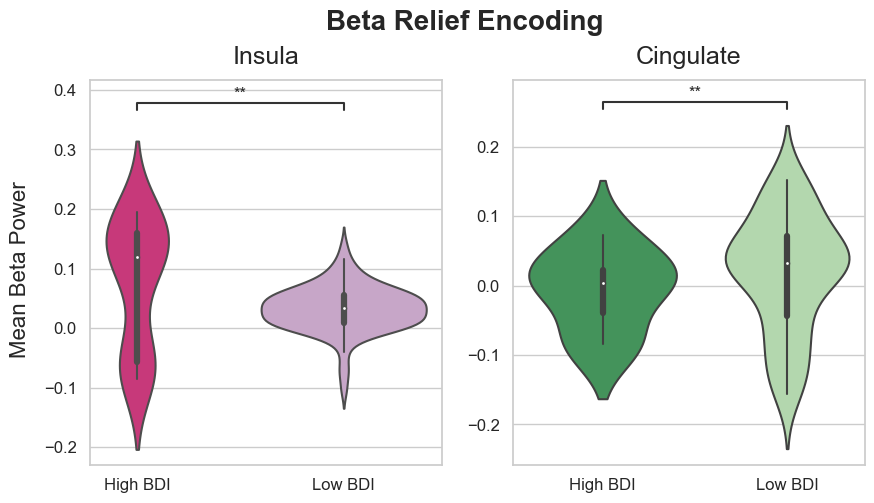

In [692]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5)) #,sharex=True,sharey=True
sns.set_theme(style="whitegrid",font='Arial') 
sns.violinplot(data=ins_gamma_df,ax=ax1,x='Depression',y='av_pow',palette='PuRd_r')
sns.violinplot(data=cing_gamma_df,ax=ax2,x='Depression',y='av_pow',palette='Greens_r')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Insula',weight='medium',fontsize=18,y=1.02)

#ax2.set_ylim(-0.1,0.6)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Cingulate',weight='medium',fontsize=18,y=1.02)



fig.supylabel('Mean Beta Power',x=0.045,weight='medium',fontsize=16)
fig.suptitle('Beta Relief Encoding',y=1.02,weight='semibold',fontsize=20)

ins_results = add_stat_annotation(ax1, data=ins_gamma_df, x='Depression',y='av_pow', 
                                    box_pairs=[("High BDI", "Low BDI")],
                                   test='t-test_ind', text_format='star',
                                   loc='inside', verbose=2,line_offset_to_box=0.3)

cing_results = add_stat_annotation(ax2, data=cing_gamma_df, x='Depression',y='av_pow', 
                                    box_pairs=[("High BDI", "Low BDI")],
                                   # test='t-test_ind', text_format='star',
                                    text_format='star',
                                   perform_stat_test=False, pvalues=cing_pval, 
                                   loc='inside', verbose=2,line_offset_to_box=0.2)



ins_results
cing_results

plt.savefig(f'{proj_dir}figs/depression_ephys_results/relief_beta.png', dpi=500, format='png', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)   